In [1]:
#TODO
segments_amount={"rnai60":4,"wt":6,"pole":1,"pole_segments":list(range(3,8))}

In [2]:
import pickle
import numpy as np
from sklearn.linear_model import LinearRegression

def get_file(name,
            gain_ratio= 0.5,
            active_gain= 0.5,
            decay= 0.15,
            pin_decay= 0.05,
            pin_production_1= 1.0,
            pin_production_2=0.02,
            dt= 0.01,):
    failed = True
    ex =None
    errors=[]
    for d in [0.,0.001,-0.001,0.002,-0.002,]:
        try:
            dormant_gain = round(gain_ratio*active_gain,3)+d
            filename =  f"./{name}/active_gain {active_gain:.3f} dormant_gain {dormant_gain:.3f} decay {decay:.3f} pin_decay {pin_decay:.3f} pin_production_1 {pin_production_1:.3f} pin_production_2 {pin_production_2:.2}"

            with open(filename,"rb") as file:
                return pickle.load(file)
        except Exception as e:
            errors.append(str(e))
            ex=e
    for error in errors:
        print(error)
    raise ex
            

def get_file2(name,
            gain_ratio= 0.5,
            active_gain= 0.5,
            decay= 0.15,
            pin_decay= 0.05,
            pin_production_1= 1.0,
            pin_production_2=0.02,
            dt= 0.01,):
    dormant_gain = gain_ratio*active_gain
    filename =  f"./v2/{name}/active_gain {active_gain:.3f} dormant_gain {dormant_gain:.3f} decay {decay:.3f} pin_decay {pin_decay:.3f} pin_production_1 {pin_production_1:.3f} pin_production_2 {pin_production_2:.2}"
    #return filename
    with open(filename,"rb") as file:
        return pickle.load(file)
from math import ceil

def get_values_average(datas,index,name):
    X = []
    Y = []
    Y2 = [[] for i in range(ceil(max([len(data) for data in datas])/segments_amount[name]))]
    for data in datas:
        start=0
        for i in range(segments_amount[name]):
            if data[start][0]<data[i][0]:
                start=i
        for i in range(0,len(data),segments_amount[name]):
            Y.append(data[i][0])
            X.append(i)
            Y2[i//segments_amount[name]].append(data[i][0])
    Y2 = [sum(x)/len(x) for x in Y2]
    X2 = list(range(0,len(data),segments_amount[name]))
    return X,Y,X2,Y2

def calculate_regression(X,Y):
    x=np.array(X).reshape((-1, 1))
    y=np.array(Y)
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    y_pred = model.predict(x)
    return model.intercept_,model.coef_[0],x,y_pred

def strip_avg(X2,Y2,ratio=0.5,strip_left=True,strip_right=True):
    X,Y=X2[:],Y2[:]
    avg_slope=abs((Y2[0]-Y2[-1])/len(X2))
    if abs(Y2[0]-Y2[1])<avg_slope*ratio and strip_left:
        X,Y=X2[1:],Y2[1:]
    if abs(Y2[-2]-Y2[-1])<avg_slope*ratio and strip_right:
        X,Y=X2[:-1],Y2[:-1]
    return X,Y

def strip_avg_full(X2,Y2,ratio=0.5,strip_left=True,strip_right=True):
    X,Y=strip_avg(X2,Y2,ratio,strip_left,strip_right)
    old_l=len(X2)
    while len(X)!=old_l:
        old_l=len(X)
        X,Y=strip_avg(X,Y)
    return X,Y

from matplotlib import cm
colormap = cm.get_cmap("Set3")
def get_color(i):
    return (colormap((i%colormap.N)/12))

In [3]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="",xlabel="",ylabel="",label_fontsize=10, **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))

    ax.set_xlabel(xlabel,fontsize=label_fontsize)
    ax.set_ylabel(ylabel,fontsize=label_fontsize)
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("white","black"),color_range=(0,),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            ci=0
            for r in color_range:
                if data[i, j]<r:
                    break
                ci+=1
            kw.update(color=textcolors[ci])
            text = im.axes.text(j, i, valfmt(data[i, j], (i,j)), **kw)
            texts.append(text)

    return texts

In [4]:
import matplotlib.pyplot as plt
starting_values = []
active_gain = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
for gain in active_gain:
    data = get_file("pole_segments",active_gain=gain,gain_ratio=1.)[0]
    #print(data)
    starting_values.append(data[0][0])
    plt.plot([x[0] for x in data])
    #plt.plot([x[1] for x in data])
plt.show()
plt.plot(active_gain,starting_values)


[Errno 2] No such file or directory: './pole_segments/active_gain 0.100 dormant_gain 0.100 decay 0.150 pin_decay 0.050 pin_production_1 1.000 pin_production_2 0.02'
[Errno 2] No such file or directory: './pole_segments/active_gain 0.100 dormant_gain 0.101 decay 0.150 pin_decay 0.050 pin_production_1 1.000 pin_production_2 0.02'
[Errno 2] No such file or directory: './pole_segments/active_gain 0.100 dormant_gain 0.099 decay 0.150 pin_decay 0.050 pin_production_1 1.000 pin_production_2 0.02'
[Errno 2] No such file or directory: './pole_segments/active_gain 0.100 dormant_gain 0.102 decay 0.150 pin_decay 0.050 pin_production_1 1.000 pin_production_2 0.02'
[Errno 2] No such file or directory: './pole_segments/active_gain 0.100 dormant_gain 0.098 decay 0.150 pin_decay 0.050 pin_production_1 1.000 pin_production_2 0.02'


FileNotFoundError: [Errno 2] No such file or directory: './pole_segments/active_gain 0.100 dormant_gain 0.098 decay 0.150 pin_decay 0.050 pin_production_1 1.000 pin_production_2 0.02'

In [ ]:
from matplotlib import cm
colormap = cm.get_cmap("Set3")
def get_color(i):
    return (colormap((i%colormap.N)/12))

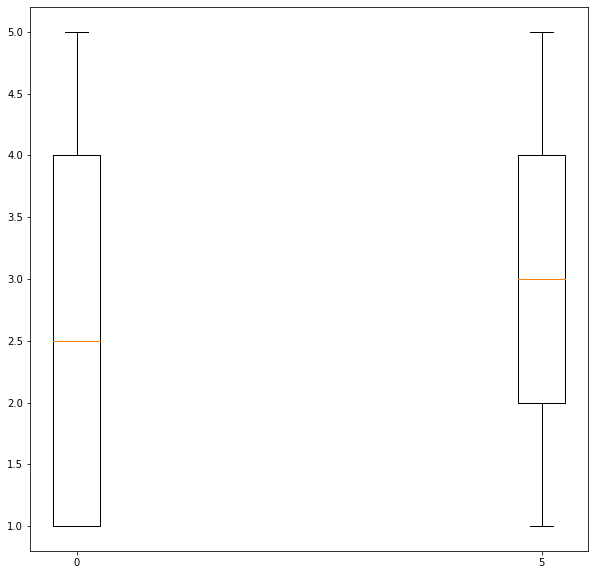

In [ ]:
plt.boxplot([[1,1,1,4,4,5],[1,2,3,4,5]],positions=[0,5])
plt.show()

wt

rnai60

svg
wt

rnai60

pdf


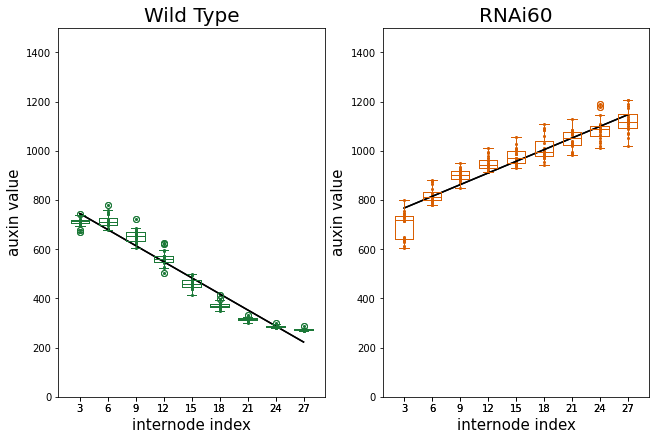

In [27]:
from math import ceil
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=[10,10]
starting_values = []
active_gain = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.]
temp=None
names=["wt","rnai60"]
nice_names = ["Wild Type","RNAi60"]
handles=[]
colors_idx = [5,0]
gain=active_gain[5]
segments_amount
fig= plt.figure(figsize=(9,6),constrained_layout=True)
ax = fig.subplots(nrows=1, ncols=2)

def filter_accepted(start,step,X,Y):
    accepted = set(range(start,max(X)+1,step))
    X0,Y0=[],[]
    for x,y in zip(X,Y):
        if x in accepted:
            X0.append(x)
            Y0.append(y)
    return X0,Y0
import matplotlib.colors as mcolors
def rgb_to_pyplot_color(red, green, blue, alpha=1):
    # Normalize RGB values
    red_norm = red/255
    green_norm = green/255
    blue_norm = blue/255

    # Create color object
    color = mcolors.to_rgba((red_norm, green_norm, blue_norm), alpha=alpha)

    return color
import pandas as pd
colorsX=[rgb_to_pyplot_color(27,120,55),rgb_to_pyplot_color(217,95,2)]
for filetype in ["svg","pdf"]:
    for i,name in enumerate(names):
        ii=colors_idx[i]
        datas = get_file(name,
                        active_gain=0.7,
                        gain_ratio=0.17,
                        decay=0.155,
                        pin_decay=0.05,
                        pin_production_1=1.,
                        pin_production_2=0.06,)
        print(name)
        print("")
        X,Y,X2,Y2=get_values_average(datas,0,name)
        X=[int(x/segments_amount[name]) for x in X]
        X2=list(map(lambda x: int(x/segments_amount[name]),X2))
        start=3
        step=3
        X,Y=filter_accepted(start,step,X,Y)
        X2,Y2=filter_accepted(start,step,X2,Y2)
        
        Y2=np.array(Y2)*2000
        Y=np.array(Y)*2000
        positions = sorted(map(int,set(X)))
        boxes = [[] for i in positions]
        for x,y in zip(X,Y):
            boxes[positions.index(int(x))].append(y)
        ax[i].scatter(X,Y,s=3,color=colorsX[i])
        #handles=[ax[i].plot(X2,Y2,color=get_color(ii),label=f"{nice_names[i]}")[0]]
        #ax[i].plot(X2,Y2,color=get_color(ii))
        a,b,X3,Y3=calculate_regression(X,Y)
        ax[i].plot(X3,Y3,color="black")
        #plt.plot([x[1] for x in data])
        ax[i].set_xlabel("internode index",fontsize=15)
        ax[i].set_ylabel("auxin value",fontsize=15)
        bp = ax[i].boxplot(boxes,positions=positions,widths=[2]*len(positions),flierprops={'marker': 'o', 'markeredgecolor': colorsX[i]})    
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color=colorsX[i])
        ax[i].set_title(nice_names[i],fontsize=20)
        ax[i].set_ylim(0,1500)
        TT=pd.DataFrame([(x,y) for x,y in zip(X,Y)])
        TT.to_csv(f"auxin value {name}.tsv",index=False,sep="\t")
        #ax[i].legend(handles=handles)
    print(filetype)
    plt.savefig(f"auxin value D.{filetype}")
#plt.plot(active_gain,starting_values)

In [23]:
TT["0"==3]

KeyError: False

In [10]:
from math import ceil
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=[10,10]
starting_values = []
active_gain = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.]
temp=None
names=["rnai60","wt","pole"]
handles=[]
for name in names:
    for ii,gain in enumerate(active_gain):
        datas = get_file(name,active_gain=gain,gain_ratio=0.5)
        X,Y,X2,Y2=get_values_average(datas,0,name)
        if name == "wt" and gain==0.5:
            temp=X2,Y2
        plt.scatter(X,Y,s=0.8,color=get_color(ii))
        handles.append(plt.plot(X2,Y2,color=get_color(ii),label=f"auxin production value {gain}")[0])
        plt.plot(X2,Y2,color=get_color(ii))
        a,b,X3,Y3=calculate_regression(*strip_avg_full(X2,Y2))
        plt.plot(X3,Y3,color=get_color(ii),alpha=0.3)
        #plt.plot([x[1] for x in data])
    plt.xlabel("segment index")
    plt.ylabel("auxin value")
    plt.legend(handles=handles)
    plt.show()
#plt.plot(active_gain,starting_values)


FileNotFoundError: [Errno 2] No such file or directory: './rnai60/active_gain 0.100 dormant_gain 0.050 decay 0.150 pin_decay 0.050 pin_production_1 1.000 pin_production_2 0.02'

gain 0.1
0.11748475183156273 -0.006626243623239653
0.12075168693970358 -0.005522380747078431
0.13070572967685407 -0.006230330325308301
0.11837716727621027 -0.003127946632189884
0.1264122988614771 -0.002994830451077885
0.12541813746094704 -0.0021785711207323605
0.13070908521612484 -0.0016989144889844794
0.1268114210547585 -0.0003878935452616005
0.1346877451662136 3.755248847450657e-05
0.14358076478535012 0.00048190775298812


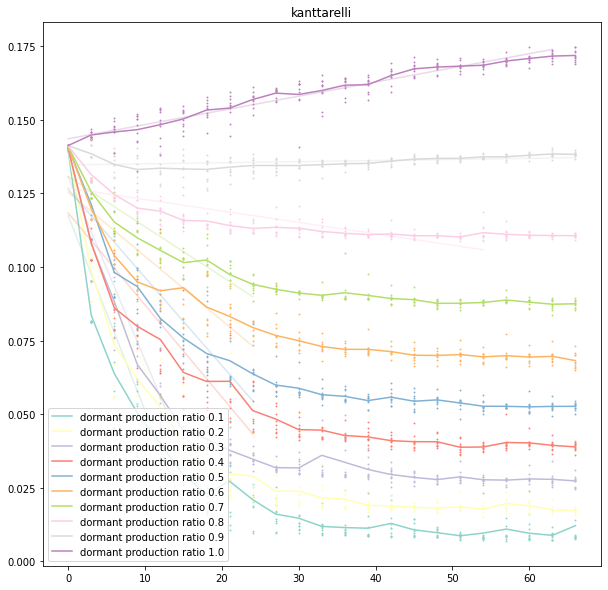

0.12858617197101313 -0.010464422544464466
0.12865343500549592 -0.009932577656581995
0.1285570837246875 -0.009680518802876271
0.13065404010315734 -0.009577360500892002
0.12992590079084038 -0.009366308509682614
0.13042311742901802 -0.009003631211817263
0.13063845951110126 -0.008768736353764931
0.12423180829733611 -0.006563652533416948
0.13460003165528178 -0.008674411739533145
0.1347942886253198 -0.008420810227592786


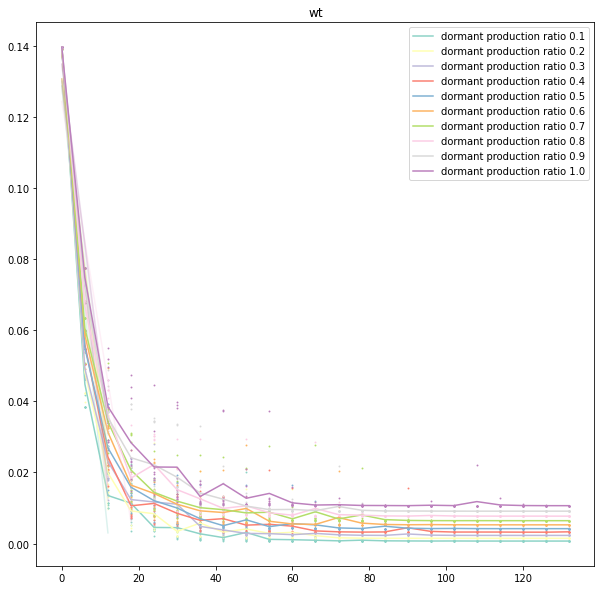

0.12933532986789942 -0.01601326691785029
0.12933532986789942 -0.01601326691785029
0.12933532986789942 -0.01601326691785029
0.12933532986789942 -0.01601326691785029
0.12933532986789942 -0.01601326691785029
0.12933532986789942 -0.01601326691785029
0.12933532986789942 -0.01601326691785029
0.12933532986789942 -0.01601326691785029
0.12933532986789942 -0.01601326691785029
0.12933532986789942 -0.01601326691785029


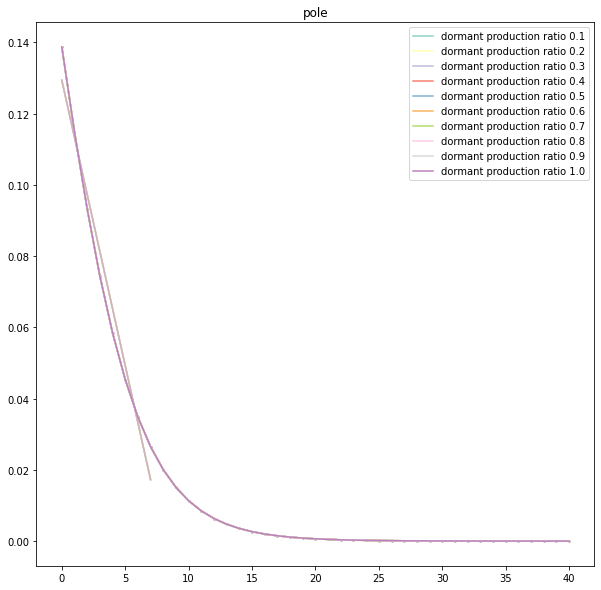

gain 0.2
0.19594167996705933 -0.006251995182511481
0.1921465115994215 -0.004097553690274557
0.19534645598621397 -0.0029146026116406596
0.20960651167175348 -0.0020867762922802398
0.2266800704739782 -0.0008496003096080782
0.2301091571842437 0.0009172863968006977
0.23649845330022537 0.002502017076823664
0.2463079037166867 0.0038437763897573433
0.2492663671376677 0.005050913026143036
0.2581565146507482 0.006193747645310263


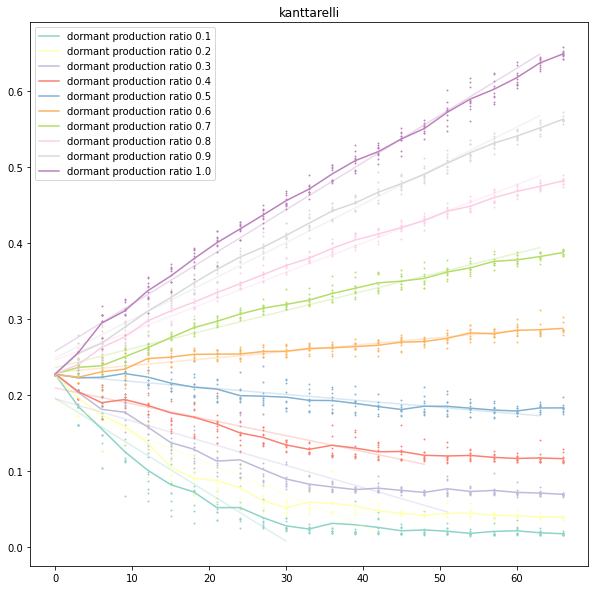

0.20343622906133535 -0.011294558076187972
0.21950378504892185 -0.014803973895808056
0.2094022050499916 -0.010896975469465059
0.21889377025266488 -0.013903660016755262
0.2096130122616887 -0.010059154527261855
0.2110145238786936 -0.009312373064458371
0.20517356235533957 -0.007521336910625302
0.16785973086125322 -0.003449703432723052
0.1613901962949471 -0.0026637294798186333
0.20711295579870548 -0.0052903595194220545


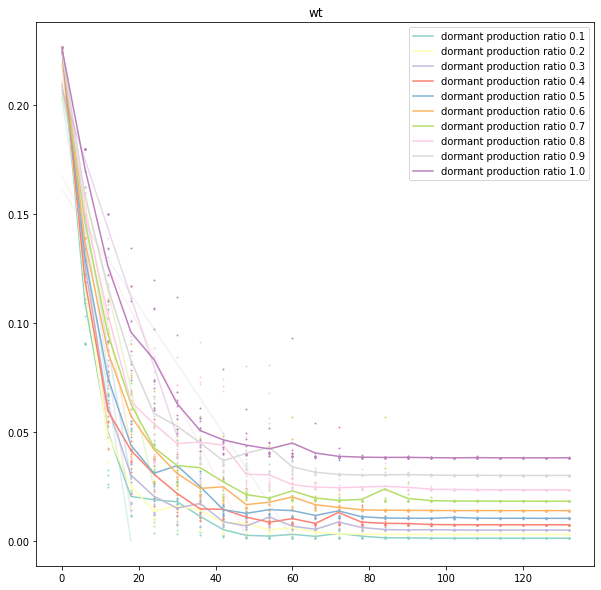

0.2131775644692508 -0.020058244940909475
0.2131775644692508 -0.020058244940909475
0.2131775644692508 -0.020058244940909475
0.2131775644692508 -0.020058244940909475
0.2131775644692508 -0.020058244940909475
0.2131775644692508 -0.020058244940909475
0.2131775644692508 -0.020058244940909475
0.2131775644692508 -0.020058244940909475
0.2131775644692508 -0.020058244940909475
0.2131775644692508 -0.020058244940909475


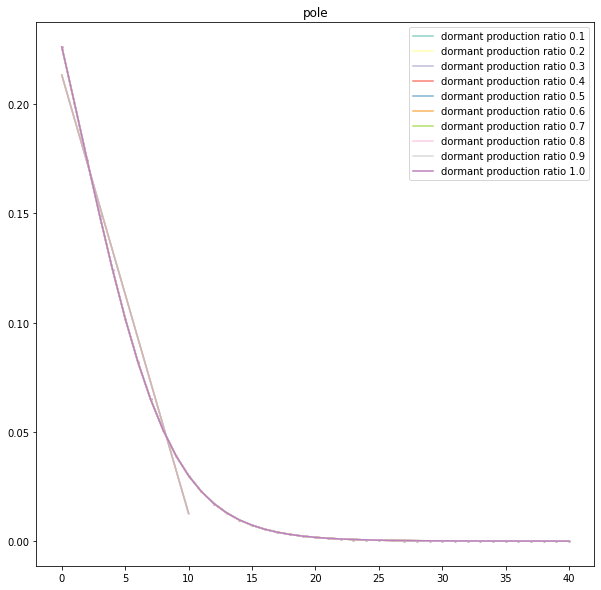

gain 0.3
0.26081951548317994 -0.005767102139161937
0.2706245632592218 -0.003696143652647089
0.2901342309334062 -0.00234179249702594
0.30521599389612675 0.00016096519240041987
0.30119726568342664 0.002759192527496005
0.3057092369427322 0.004603936431346451
0.3017846771232461 0.0063863164969819326
0.29249620447340213 0.008707791033823029
0.2648403075402197 0.011411006445352269
0.24226909577846528 0.014349446297477197


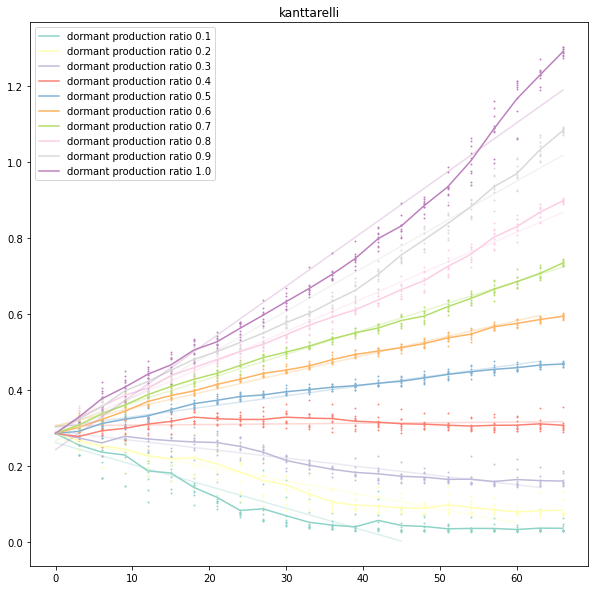

0.2761173405498266 -0.014214911594366036
0.24734290909199486 -0.008399378181036029
0.2560781183093786 -0.00940557222813368
0.25152627233238445 -0.007745877080375241
0.2641627882208143 -0.0076230230404152775
0.22173504783687265 -0.003734097612287962
0.24083270815285762 -0.004073812502502189
0.2481154011562467 -0.0035518997461732598
0.27015736512839794 -0.004370627623228799
0.25294788754084596 -0.0022173508919857343


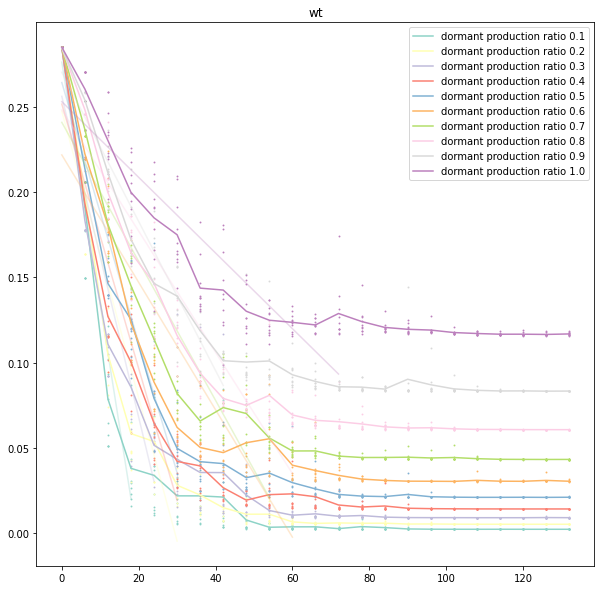

0.2767760109688554 -0.021841680835727798
0.2767760109688554 -0.021841680835727798
0.2767760109688554 -0.021841680835727798
0.2767760109688554 -0.021841680835727798
0.2767760109688554 -0.021841680835727798
0.2767760109688554 -0.021841680835727798
0.2767760109688554 -0.021841680835727798
0.2767760109688554 -0.021841680835727798
0.2767760109688554 -0.021841680835727798
0.2767760109688554 -0.021841680835727798


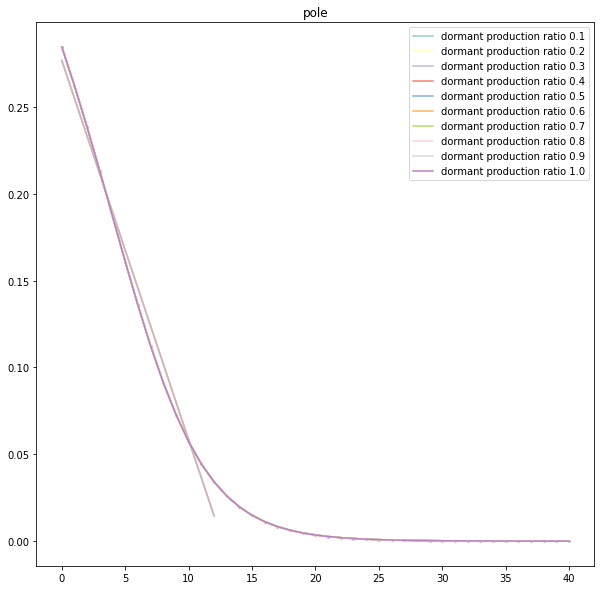

gain 0.4
0.32167573782648495 -0.005194318337997385
0.35530108374215863 -0.003530829076727254
0.35405802645761036 0.00018798403137600326
0.3503870919346809 0.0031048504240585094
0.3439518853698088 0.005678066787001957
0.32156819114866464 0.008825563313500838
0.2865072357589784 0.012690245768494599
0.2208316375295838 0.01754391861964861
0.1810672899345297 0.021947756202100207
0.11501300025295913 0.026355284589305784


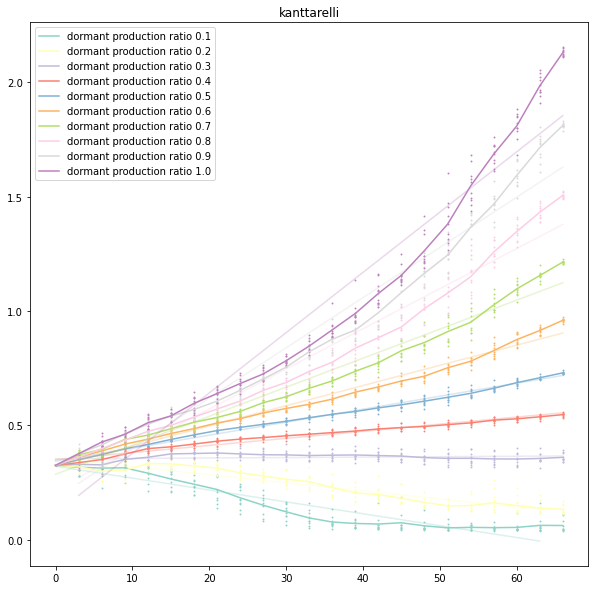

0.22255206986402087 -0.004088590855372087
0.3054276323045737 -0.008611405257778686
0.2975033971214934 -0.007287222095986919
0.2748685562610625 -0.0049178340617153345
0.30578190626369584 -0.005508761066529486
0.30085411102256987 -0.004152331294661218
0.29148373729238913 -0.0026773001776919485
0.30933655785662784 -0.0019327487559108937
0.302109208761477 -0.0002970813804007823
0.2995258971081151 0.001025569840842175


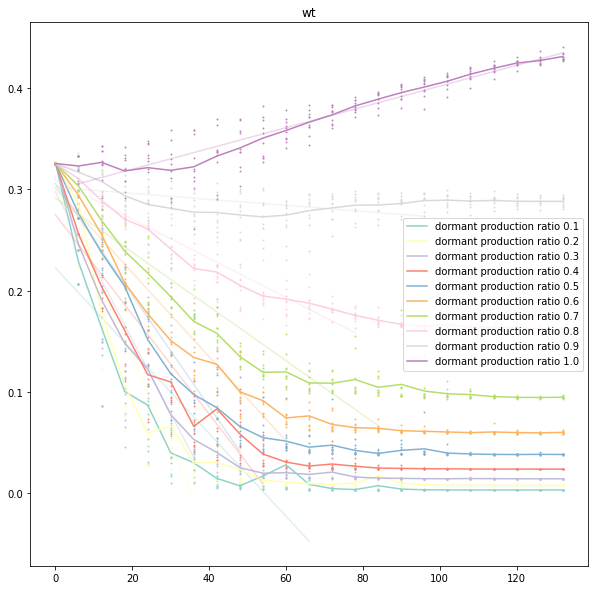

0.32625992155323424 -0.022236983451460086
0.32625992155323424 -0.022236983451460086
0.32625992155323424 -0.022236983451460086
0.32625992155323424 -0.022236983451460086
0.32625992155323424 -0.022236983451460086
0.32625992155323424 -0.022236983451460086
0.32625992155323424 -0.022236983451460086
0.32625992155323424 -0.022236983451460086
0.32625992155323424 -0.022236983451460086
0.32625992155323424 -0.022236983451460086


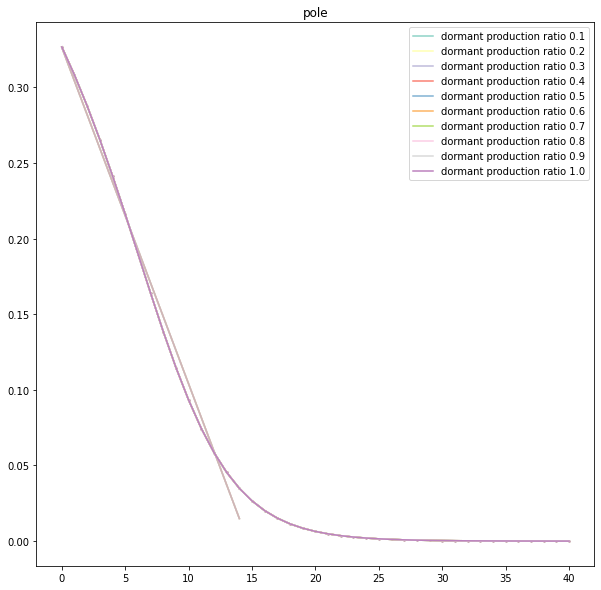

gain 0.5
0.4275369765675244 -0.006588106313902962
0.4031613121861997 -0.001067395877382658
0.3821004565996614 0.0028505731695860135
0.36801308795161863 0.00621220765534754
0.322206744977406 0.010913253254009105
0.25512408397414454 0.016180412347608877
0.1887162692361063 0.021707801192398693
0.12191680557542028 0.027686999360428635
0.053157643877066896 0.03387389111469497
-0.6062536965485883 0.052334702330477094


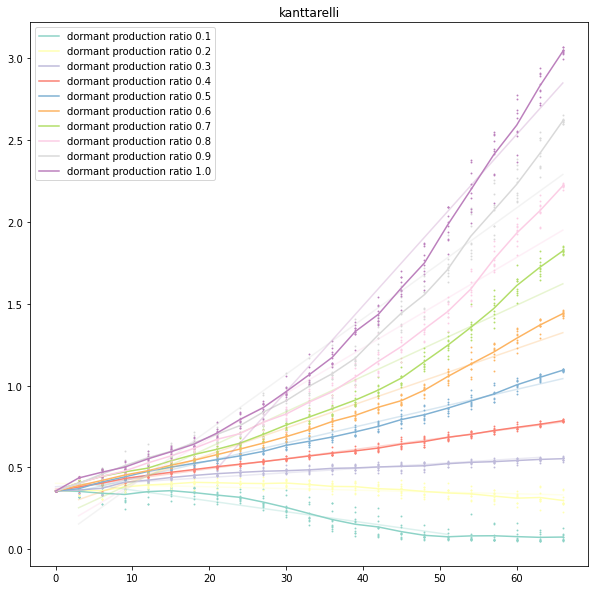

0.3015302227166565 -0.006115710950418928
0.3380701791184644 -0.007615380218282103
0.3301833168388558 -0.0052536797816137865
0.3339767463341518 -0.004490841617432485
0.35892088572757364 -0.004220477041369412
0.3552464817486265 -0.0024681330033961466
0.34918397086646713 -0.0007171563348392297
0.349770511987181 0.0007929566312976057
0.34824154005422214 0.0017441082994704106
0.3478152771034966 0.0025995263434720754


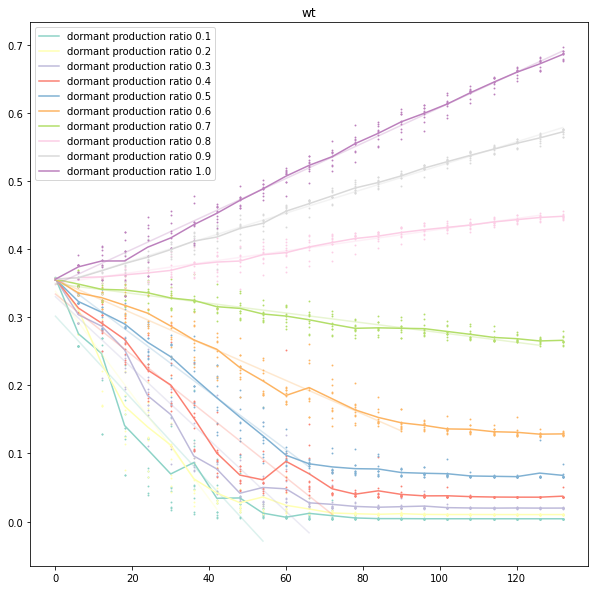

0.36652338446355337 -0.02205540161287668
0.36652338446355337 -0.02205540161287668
0.36652338446355337 -0.02205540161287668
0.36652338446355337 -0.02205540161287668
0.36652338446355337 -0.02205540161287668
0.36652338446355337 -0.02205540161287668
0.36652338446355337 -0.02205540161287668
0.36652338446355337 -0.02205540161287668
0.36652338446355337 -0.02205540161287668
0.36652338446355337 -0.02205540161287668


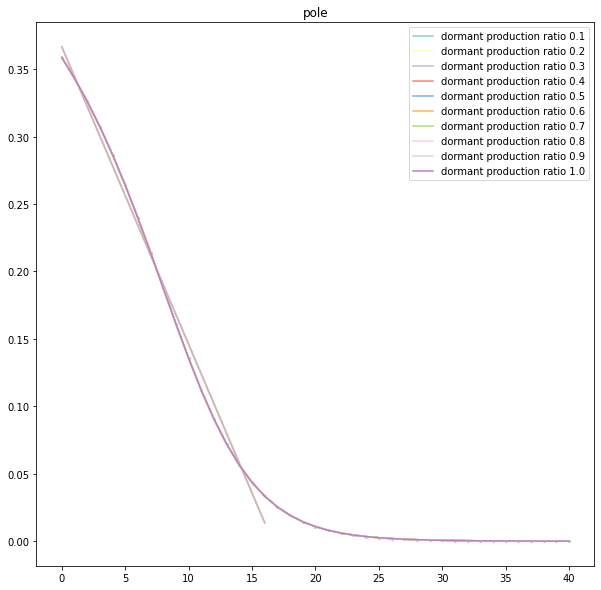

gain 0.6
0.4942145916161599 -0.0048833897137134825
0.4212221851815348 0.001032647580811472
0.40017331193970596 0.005041755261746318
0.3438483919416154 0.010632683547364775
0.255373165282336 0.017221347506652555
0.18803778050781828 0.02385455442085209
-0.2501366229326125 0.038593057991048105
-0.6471971573999948 0.052007100269907985
-0.6815736324208623 0.05899420411563387
-1.0636639923909135 0.07312155475803452


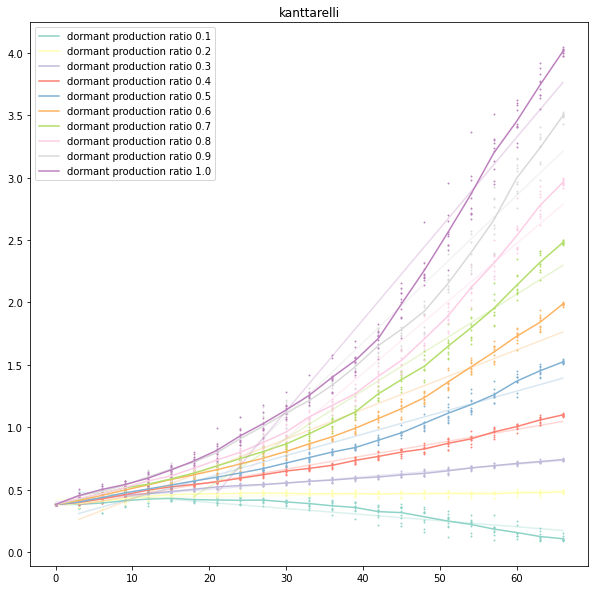

0.3422880046294776 -0.005421736832382325
0.34686134870396934 -0.004736324144981891
0.38339720236157965 -0.0052529472554095685
0.4023827090477331 -0.004518078558042748
0.4076618552295088 -0.00254681992943975
0.3910364574712256 -0.0003745973895503912
0.3846941023497355 0.0012087155265725542
0.3725001573562622 0.0022723730118535406
0.36897230540280745 0.003331644812964482
0.36028552729150526 0.00448041173073614


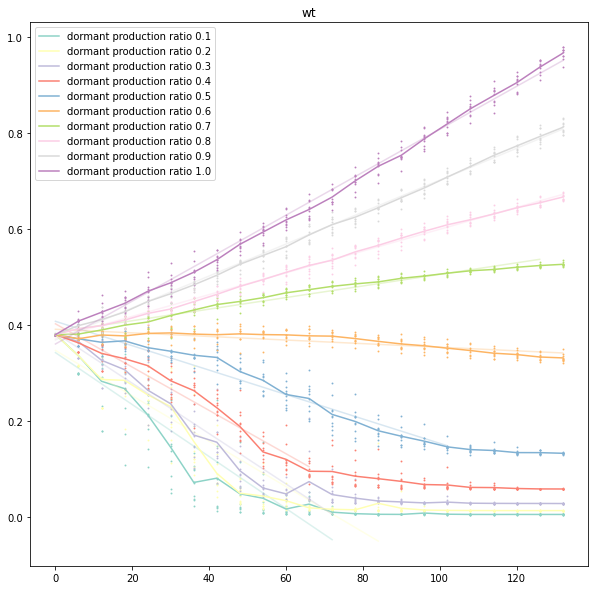

0.4001735789015105 -0.02160480379927577
0.4001735789015105 -0.02160480379927577
0.4001735789015105 -0.02160480379927577
0.4001735789015105 -0.02160480379927577
0.4001735789015105 -0.02160480379927577
0.4001735789015105 -0.02160480379927577
0.4001735789015105 -0.02160480379927577
0.4001735789015105 -0.02160480379927577
0.4001735789015105 -0.02160480379927577
0.4001735789015105 -0.02160480379927577


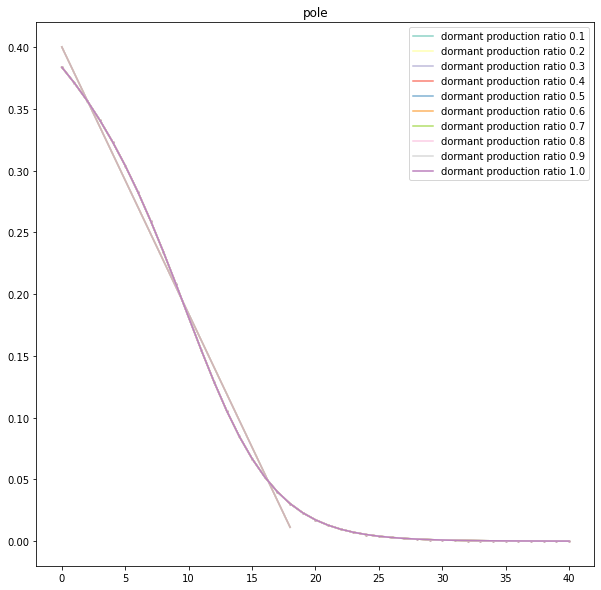

gain 0.7
0.45999163137123045 -0.001749138974400759
0.4380895963829497 0.0028142126318808445
0.3907432084498199 0.008437886040986605
0.30041159933263606 0.01602727634947605
0.1428148687195463 0.02554006829535292
-0.14008590865471482 0.037910946607999804
-0.338494544616466 0.048624945808449366
-0.8449893465638167 0.06677365213632586
-1.329942054954313 0.08318204545548985
-1.9689008039432538 0.10179461716732258


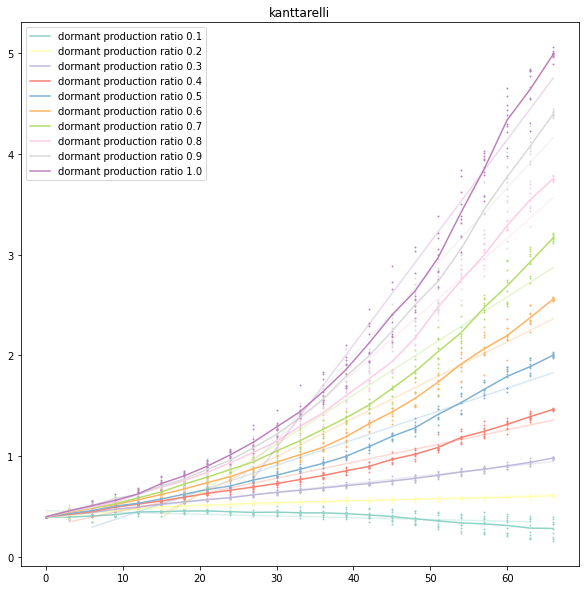

0.448567303787503 -0.00811621244168944
0.3365832340069019 -0.0033582376158147152
0.4352181141397782 -0.00462788779684257
0.5982652319019489 -0.005152459358326109
0.43770148169684725 -0.0006682180915761975
0.41206171965315225 0.0012046764145939898
0.40185074881602667 0.0024938669844511074
0.39024596991746324 0.003847383404437732
0.3482611078333545 0.0054487249902496
0.3423967685388484 0.006857626444423308


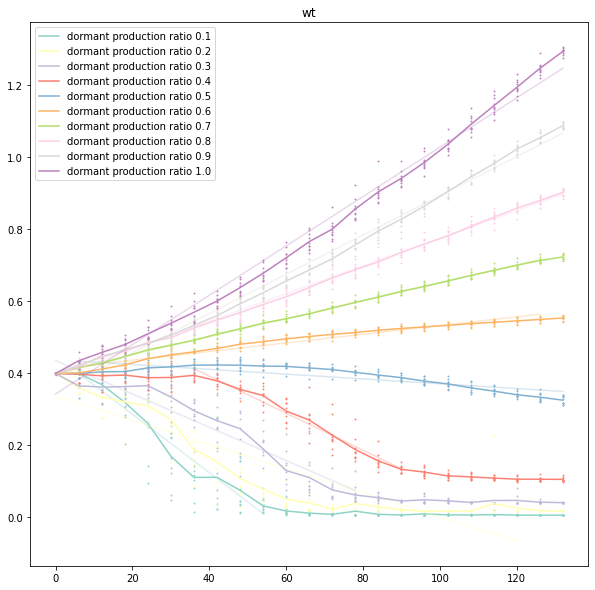

0.42926381076020853 -0.02117756353621196
0.42926381076020853 -0.02117756353621196
0.42926381076020853 -0.02117756353621196
0.42926381076020853 -0.02117756353621196
0.4292637983070953 -0.021177564107609875
0.42926381076020853 -0.02117756353621196
0.42926381076020853 -0.02117756353621196
0.42926381076020853 -0.02117756353621196
0.42926381076020853 -0.02117756353621196
0.42926381076020853 -0.02117756353621196


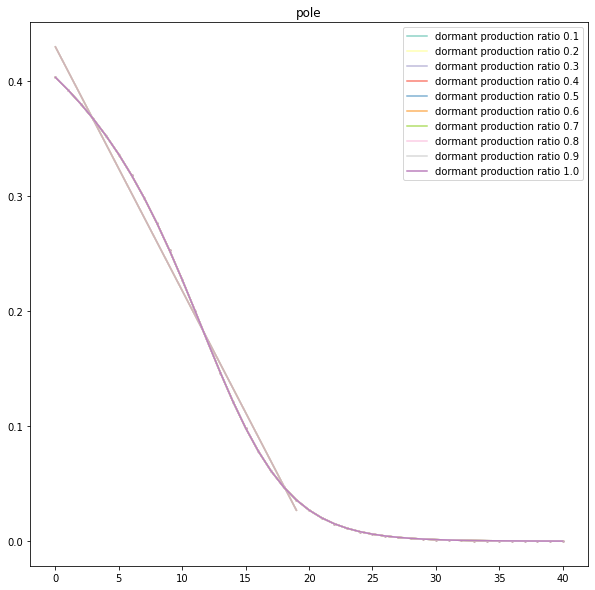

gain 0.8
0.46660329074315393 0.00016258831807118955
0.44321772730969755 0.004983719294856055
0.3605064795775848 0.012508531898377914
0.24618651406331493 0.021953269533017877
-0.18901960829309417 0.03808434710296152
-0.5662258955836299 0.05333317523201308
-0.5951301289211652 0.06255460589006673
-1.326570845785596 0.08535959334600542
-1.2851913118187137 0.09223079361459792
-2.011512767147452 0.11517109230870295


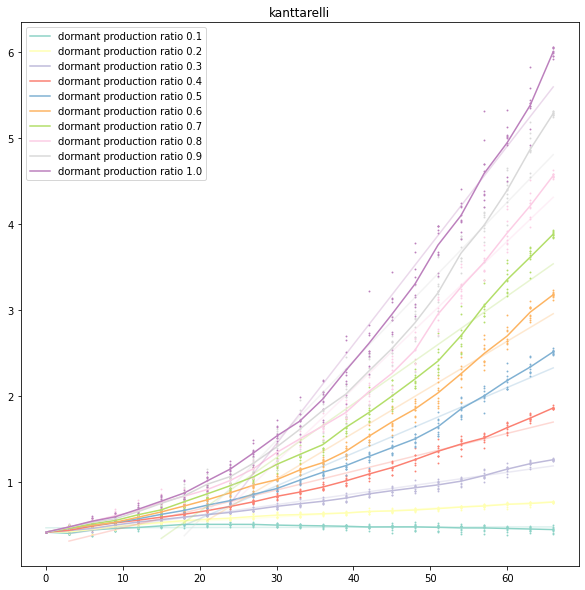

0.45848897832015945 -0.006301304980628052
0.4644036832771131 -0.00526052716969352
0.5005538308247924 -0.0042255975939698666
0.5103921247238206 -0.0019761380978993016
0.4200142980163748 0.0015188415077599618
0.4220762490755014 0.0024157713165441166
0.388670422223223 0.004108905449058071
0.37232894374952674 0.005811493912648287
0.34129451083672524 0.007541222861935905
0.27753361984506797 0.00978871949823388


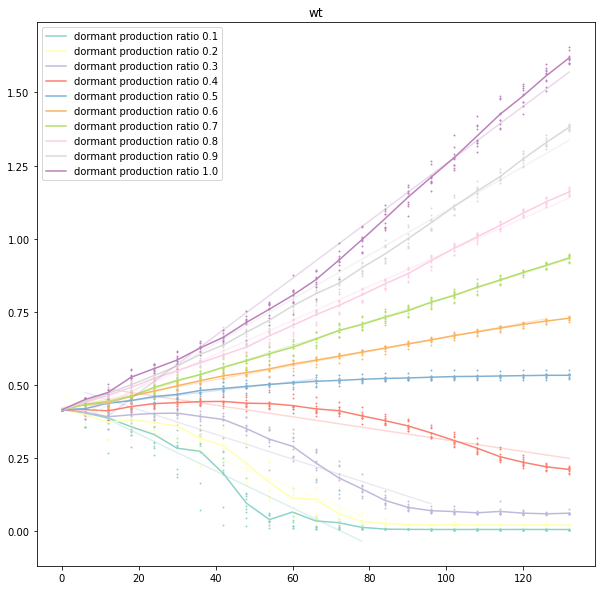

0.45203199392191973 -0.020352389375279004
0.45203199392191973 -0.020352389375279004
0.45203199392191973 -0.020352389375279004
0.45203199392191973 -0.020352389375279004
0.45203199392191973 -0.020352389375279004
0.45203199392191973 -0.020352389375279004
0.45203199392191973 -0.020352389375279004
0.45203199392191973 -0.020352389375279004
0.45203199392191973 -0.020352389375279004
0.45203199392191973 -0.020352389375279004


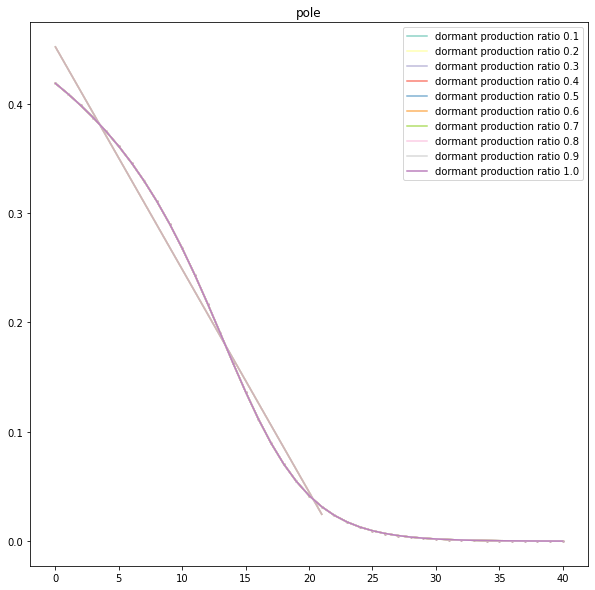

gain 0.9
0.47089032056011665 0.0017270573380189546
0.4312156736076652 0.007766673442291135
0.3335047190839595 0.01696933194975294
0.13325429578880166 0.029474031943263444
-0.6174022280176479 0.053670451144377386
-0.6649181605261925 0.06301135951105288
-1.1529183837946726 0.08095134329562094
-2.014635819838596 0.10715176368371031
-2.0890528617728337 0.11930447937477205
-2.5830481913685794 0.13797967741886774


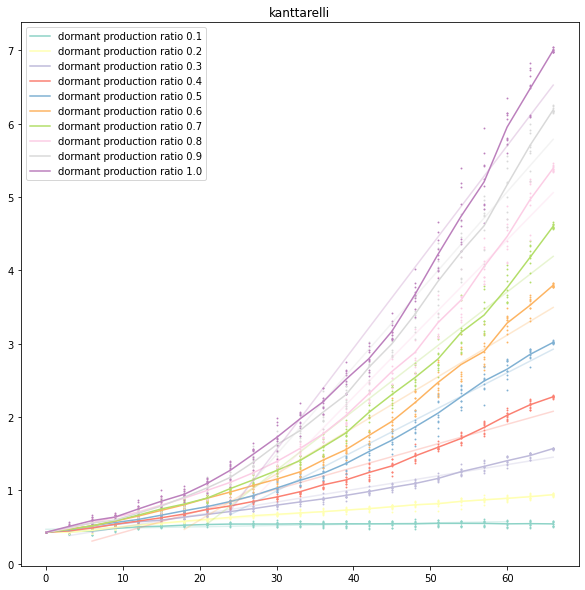

0.4983812164247148 -0.006090928372462431
0.6970966355864787 -0.007640998315376541
0.5306798792226983 -0.003187693208568226
0.47057985899888943 0.00017725817800274938
0.4463790682818107 0.0020291060242930217
0.41438897201767216 0.003793380531622105
0.37458897995484336 0.005838227673941541
0.3496383772267926 0.007833134411991415
0.3053198116166249 0.010018667716966969
0.2556782577331965 0.012226090019994059


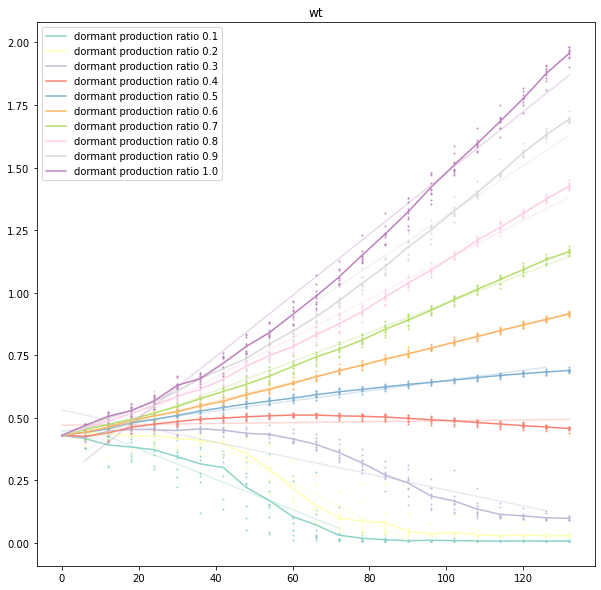

0.47169961324582493 -0.019555420326473918
0.47169961324582493 -0.019555420326473918
0.47169961324582493 -0.019555420326473918
0.47169961324582493 -0.019555420326473918
0.4716995862995585 -0.019555419731237318
0.47169961324582493 -0.019555420326473918
0.47169961324582493 -0.019555420326473918
0.47169961324582493 -0.019555420326473918
0.47169961324582493 -0.019555420326473918
0.47169961324582493 -0.019555420326473918


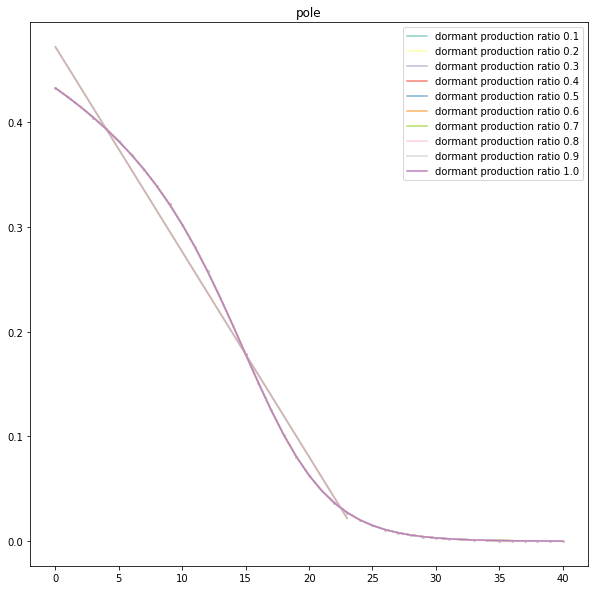

gain 1.0
0.4894152828002636 0.0029029256775175896
0.4137525778699231 0.01070833477275241
0.23882741386240158 0.022855861659173846
0.13445500143162614 0.03494478376733366
-0.7732938393311839 0.0622889437065238
-0.7159086075483589 0.0712056262430802
-1.510214087787796 0.09682740387671133
-2.05897123874653 0.11936887648843583
-2.85135147178566 0.14281256316782354
-3.5647714015677723 0.16988861745093767


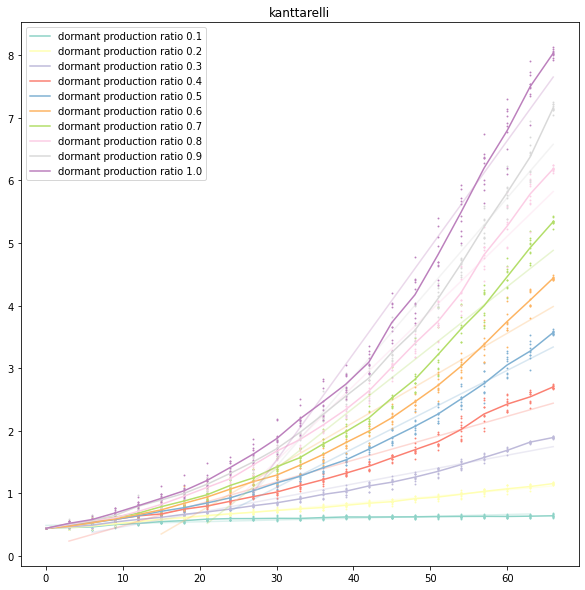

0.5036754050238156 -0.004940574075999446
0.5748432170928401 -0.004659252087250841
0.5418279213177694 -0.0017197544290513255
0.45396584485258373 0.0019307656084006516
0.45065253249236503 0.0031095592271758866
0.40963322311252753 0.005259364765679435
0.3667703448564975 0.007621925438771966
0.31446131669081645 0.01001429130033475
0.2811081320434421 0.012434705025268415
0.18326374290825465 0.015455961996342717


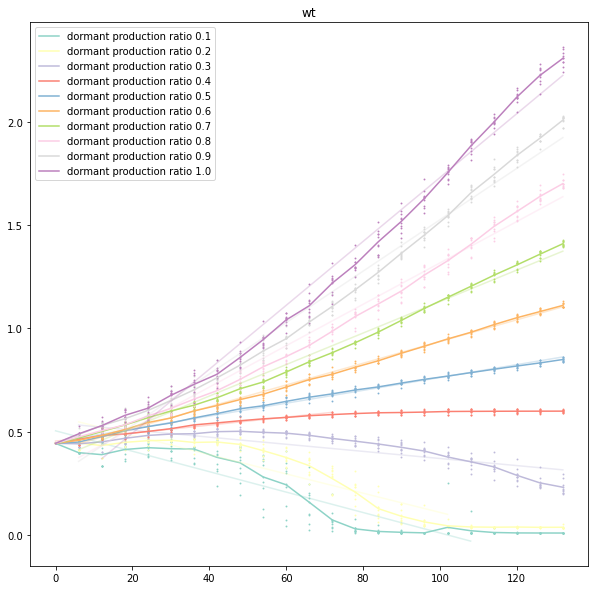

0.49735202397341305 -0.019341596654899738
0.49735202397341305 -0.019341596654899738
0.49735202397341305 -0.019341596654899738
0.49735202397341305 -0.019341596654899738
0.49735202397341305 -0.019341596654899738
0.49735202397341305 -0.019341596654899738
0.49735202397341305 -0.019341596654899738
0.49735202397341305 -0.019341596654899738
0.49735202397341305 -0.019341596654899738
0.49735202397341305 -0.019341596654899738


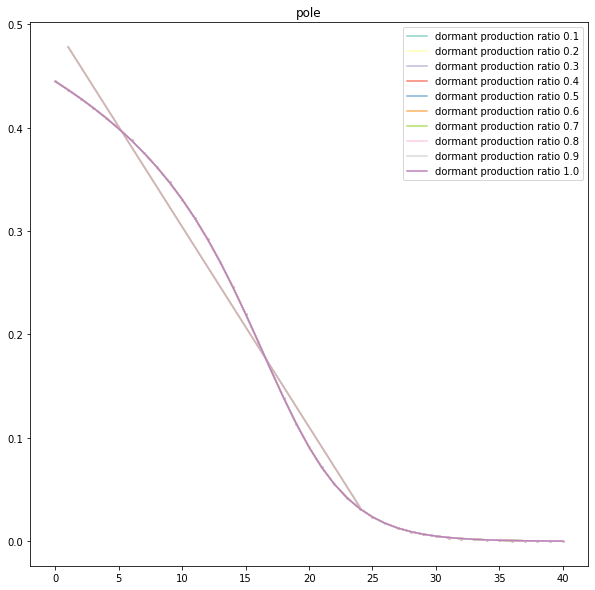

In [ ]:

from math import ceil
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=[10,10]
starting_values = []
gain_ratios = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.]
active_gain = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
names=["rnai60","wt","pole"]
for gain in gain_ratios:
    print(f"gain {gain}")
    for name in names:
        handles=[]
        for ii,gain_ratio in enumerate(gain_ratios):
            datas = get_file(name,active_gain=gain,gain_ratio=gain_ratio)
            X,Y,X2,Y2=get_values_average(datas,0,name)
            # X = []
            # Y = []
            # Y2 = [[] for i in range(ceil(max([len(data) for data in datas])/segments_amount[name]))]
            # for data in datas:
            #     for i in range(0,len(data),segments_amount[name]):
            #         Y.append(data[i][0])
            #         X.append(i)
            #         Y2[i//segments_amount[name]].append(data[i][0])
            # Y2 = [sum(x)/len(x) for x in Y2]
            # X2 = list(range(0,len(data),segments_amount[name]))
            plt.scatter(X,Y,s=0.8,color=get_color(ii))
            handles.append(plt.plot(X2,Y2,color=get_color(ii),label=f"dormant production ratio {gain_ratio}")[0])
            a,b,X3,Y3=calculate_regression(*strip_avg_full(X2,Y2,ratio=0.8))
            plt.plot(X3,Y3,color=get_color(ii),alpha=0.3)
            print(a,b)
            #plt.plot([x[1] for x in data])
        plt.title(name)
        #plt.legend([f"dormant production ratio {g}" for g in gain_ratios])
        plt.legend(handles=handles)
        plt.show()
    #plt.plot(active_gain,starting_values)


In [44]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

def get_abs_range(arr):
    return max(abs(np.max(arr)),abs(np.min(arr)))

plt.rcParams['figure.figsize']=[10,10]
starting_values = []
gain_ratios = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.]
active_gain = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,]
names=["rnai60","wt"]
for name in names:
    values_a = np.zeros((len(active_gain),len(gain_ratios)))
    values_b = np.zeros((len(active_gain),len(gain_ratios)))
    values_c = np.zeros((len(active_gain),len(gain_ratios)))
    for x,gain in enumerate(active_gain):
        for y,gain_ratio in enumerate(gain_ratios):
            datas = get_file(name,active_gain=gain,gain_ratio=gain_ratio)
            X,Y,X2,Y2=get_values_average(datas,0,name)
            b,a,X3,Y3=calculate_regression(*strip_avg_full(X2,Y2,ratio=0.7))
            values_a[x,y]=a*100
            values_b[x,y]=b
            values_c[x,y]=Y2[-1]
    # plt.imshow(values_a)
    # plt.colorbar()
    # plt.show()
    # plt.title(f"{name} b")
    # plt.imshow(values_b)
    # plt.colorbar()
    # plt.show()
    
    vmax = get_abs_range(values_a)
    fig, ax = plt.subplots()
    ax.set_title(f"{name} slope")
    im, cbar = heatmap(values_a, active_gain,gain_ratios, ax=ax,
                    cmap="magma", cbarlabel="",xlabel="gain ratio",ylabel="gain value",vmin=-vmax, vmax=vmax)
    texts = annotate_heatmap(im, valfmt="{x:.1f} t",textcolors=("white","black"))
    fig.tight_layout()
    plt.show()
    
    vmax = get_abs_range(values_c)
    fig, ax = plt.subplots()
    ax.set_title(f"{name} final value")
    im, cbar = heatmap(values_c, active_gain,gain_ratios, ax=ax,
                    cmap="magma", cbarlabel="",xlabel="gain ratio",ylabel="gain value",vmin=0, vmax=vmax)
    texts = annotate_heatmap(im, valfmt="{x:.3f} t",textcolors=("white","black"))
    fig.tight_layout()
    plt.show()

["[Errno 2] No such file or directory: './rnai60/active_gain 0.100 dormant_gain 0.010 decay 0.150 pin_decay 0.050 pin_production_1 1.000 pin_production_2 0.02'", "[Errno 2] No such file or directory: './rnai60/active_gain 0.100 dormant_gain 0.011 decay 0.150 pin_decay 0.050 pin_production_1 1.000 pin_production_2 0.02'", "[Errno 2] No such file or directory: './rnai60/active_gain 0.100 dormant_gain 0.009 decay 0.150 pin_decay 0.050 pin_production_1 1.000 pin_production_2 0.02'", "[Errno 2] No such file or directory: './rnai60/active_gain 0.100 dormant_gain 0.012 decay 0.150 pin_decay 0.050 pin_production_1 1.000 pin_production_2 0.02'", "[Errno 2] No such file or directory: './rnai60/active_gain 0.100 dormant_gain 0.008 decay 0.150 pin_decay 0.050 pin_production_1 1.000 pin_production_2 0.02'"]


FileNotFoundError: [Errno 2] No such file or directory: './rnai60/active_gain 0.100 dormant_gain 0.008 decay 0.150 pin_decay 0.050 pin_production_1 1.000 pin_production_2 0.02'

In [10]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math

def get_abs_range(arr):
    return max(abs(np.max(arr)),abs(np.min(arr)))

plt.rcParams['figure.figsize']=[10,10]
starting_values = []
gain_ratios = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.]
active_gain = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]

def formatter_creator(values1,values2):
    def format_function(x,pos):
        d=max(0,math.floor(math.log10(abs(x)))+1)
        return f"{{:.{max(0,3-d)}f}}".format(x)#+f"\n{values1[pos[0]]}\n{values2[pos[1]]}"
    return format_function

def create_heatmap(ax,values,values1,values2,name1,name2,label,neg_scale=True):
    vmax = min(3000,get_abs_range(values))
    ax.set_title(label)
    im, cbar = heatmap(values, values1,values2, ax=ax,
                    cmap="bwr", cbarlabel="",xlabel=name2,ylabel=name1,vmin=-vmax, vmax=vmax)
    

    texts = annotate_heatmap(im, valfmt=formatter_creator(values1,values2),textcolors=("white","blue","red","white"),color_range=[-vmax/2,0,vmax/2])
    #fig.tight_layout()
    #plt.show()
def draw_heatmaps(name1,name2,values1,values2,save=True,extra_parameters={},test2=False,filename=None):
    names=["rnai60","wt","pole"]
    names=["rnai60","wt"]
    subplots = 3
    fig= plt.figure(figsize=(subplots*10,len(names)*10),constrained_layout=True)
    fig.suptitle(f"{name1} vs {name2}",fontsize='xx-large')
    subfigs = fig.subfigures(nrows=len(names), ncols=1)
    
    pretty_names=["Kantarelli","Wild Type","Pole"]

    multiplier_coefficient = 1500
    for i,name in enumerate(names):
        values_a = np.zeros((len(values1),len(values2)))
        values_b = np.zeros((len(values1),len(values2)))
        values_c = np.zeros((len(values1),len(values2)))
        values_d = np.zeros((len(values1),len(values2)))
        values_e = np.zeros((len(values1),len(values2)))
        for x,v1 in enumerate(values1):
            for y,v2 in enumerate(values2):
                datas = get_file(name,**{name1:v1,name2:v2},**extra_parameters)
                X,Y,X2,Y2=get_values_average(datas,0,name)
                X3,Y3 = strip_avg_full(X2,Y2,ratio=0.65)
                b,a,X4,Y4=calculate_regression(X3,Y3)
                values_a[x,y]=a*multiplier_coefficient
                values_b[x,y]=b*multiplier_coefficient
                values_c[x,y]=(Y2[-1])*multiplier_coefficient
                values_d[x,y]=(Y2[0])*multiplier_coefficient
                values_e[x,y]=len(Y3)
        # plt.imshow(values_a)
        # plt.colorbar()
        # plt.show()
        # plt.title(f"{name} b")
        # plt.imshow(values_b)
        # plt.colorbar()
        # plt.show()
        subfigs[i].suptitle(pretty_names[i],fontsize='x-large',color="Red")
        ax = subfigs[i].subplots(nrows=1, ncols=subplots)
        create_heatmap(ax[0],values_a,values1,values2,name1,name2,f"{name} slope")
        
        create_heatmap(ax[1],values_d,values1,values2,name1,name2,f"{name} starting value")

        create_heatmap(ax[2],values_c,values1,values2,name1,name2,f"{name} final value",neg_scale=False)
        #create_heatmap(ax[3],values_e,values1,values2,name1,name2,f"{name} len",neg_scale=False)
    if save:
        if filename is None:
            filename=f"{name1} vs {name2}.png"
        plt.savefig(filename)
    else:
        plt.show()


        
#draw_heatmaps("active_gain","decay",[0.2, 0.2, 0.3, 0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
#       1.8, 1.9, 2. ],[0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])


active_gain vs decay
sss
parameters_comparison.pdf
sss
parameters_comparison.svg


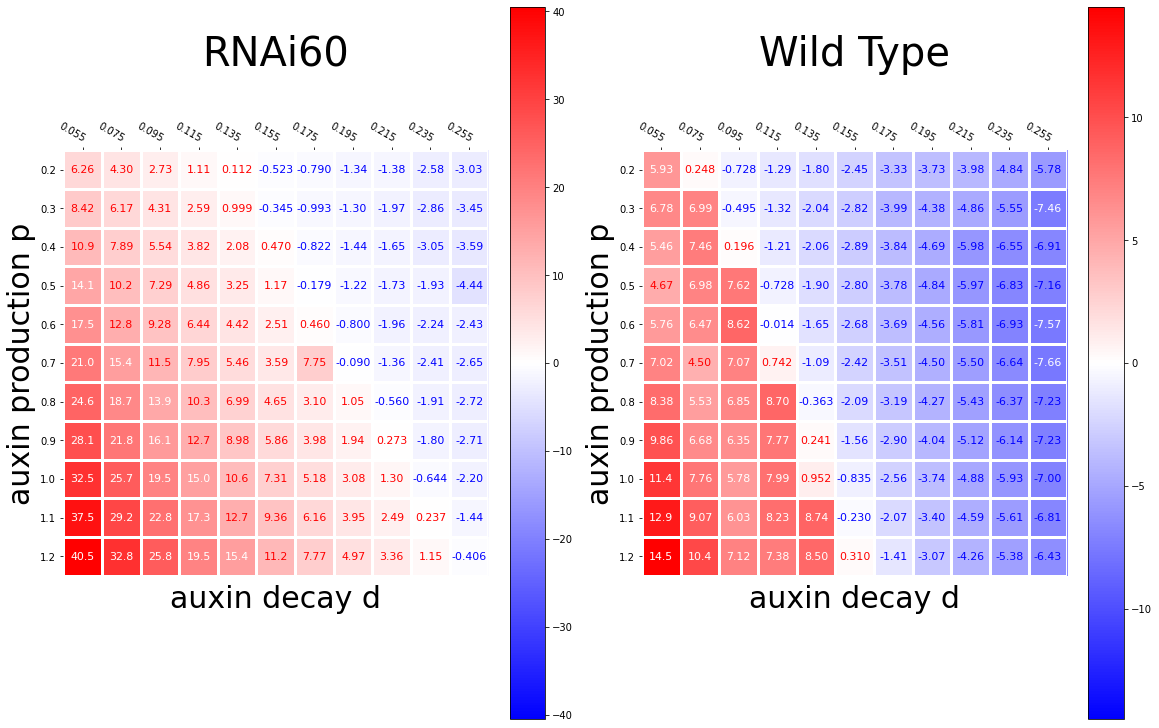

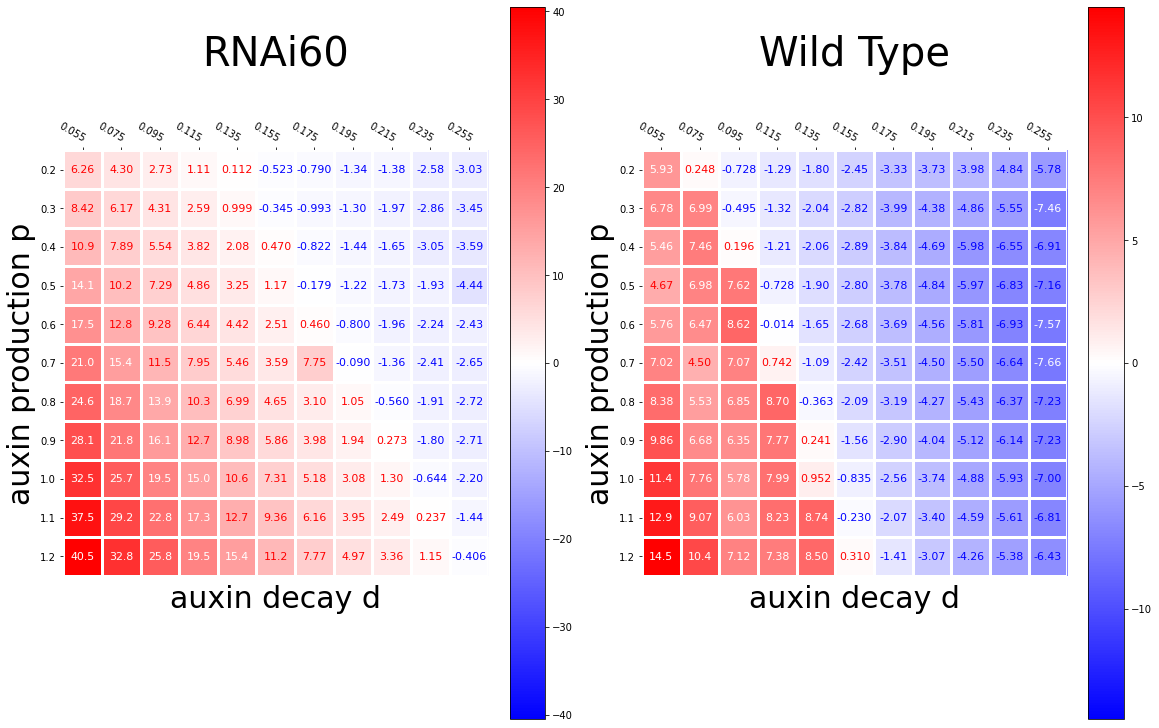

In [13]:
def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("white","black"),color_range=(0,),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            ci=0
            for r in color_range:
                if data[i, j]<r:
                    break
                ci+=1
            kw.update(color=textcolors[ci])
            text = im.axes.text(j, i, valfmt(data[i, j], (i,j)), **kw)
            texts.append(text)

    return texts

def create_heatmap2(ax,values,values1,values2,name1,name2,label,neg_scale=True):
    vmax = min(3000,get_abs_range(values))
    #ax.set_title(label,backgroundcolor=(0.7,0.7,0.7),color="white", fontsize=20)
    ax.set_title(f"{label}\n",fontsize=40)
    im, cbar = heatmap(values, values1,values2, ax=ax,
                    cmap="bwr", cbarlabel="",xlabel=name2,ylabel=name1,vmin=-vmax, vmax=vmax,label_fontsize=30)
    

    texts = annotate_heatmap(im, valfmt=formatter_creator(values1,values2),textcolors=("white","blue","red","white"),color_range=[-vmax/2,0,vmax/3],fontsize=11)




def draw_heatmaps2(name1,name2,values1,values2,save=True,extra_parameters={},test2=False,filename=None, maintitle=None):
    names=["rnai60","wt","pole"]
    names=["rnai60","wt"]
    subplots = 1
    fig= plt.figure(figsize=(len(names)*8,subplots*10),constrained_layout=True)
    if maintitle is None:
        maintitle=f"{name1} vs {name2}\n\n\n"
    #fig.suptitle(maintitle,fontsize='xx-large',backgroundcolor=(0.7,0.7,0.7),color="white")
    ax = fig.subplots(nrows=1, ncols=2)
    
    pretty_names=["RNAi60","Wild Type","Pole"]
    print("sss")
    multiplier_coefficient = 1500
    for i,name in enumerate(names):
        values_a = np.zeros((len(values1),len(values2)))
        values_b = np.zeros((len(values1),len(values2)))
        values_c = np.zeros((len(values1),len(values2)))
        values_d = np.zeros((len(values1),len(values2)))
        values_e = np.zeros((len(values1),len(values2)))
        for x,v1 in enumerate(values1):
            for y,v2 in enumerate(values2):
                datas = get_file(name,**{name1:v1,name2:v2},**extra_parameters)
                X,Y,X2,Y2=get_values_average(datas,0,name)
                X3,Y3 = strip_avg_full(X2,Y2,ratio=0.65)
                b,a,X4,Y4=calculate_regression(X3,Y3)
                values_a[x,y]=a*multiplier_coefficient
                values_b[x,y]=b*multiplier_coefficient
                values_c[x,y]=(Y2[-1])*multiplier_coefficient
                values_d[x,y]=(Y2[0])*multiplier_coefficient
                values_e[x,y]=len(Y3)
        # plt.imshow(values_a)
        # plt.colorbar()
        # plt.show()
        # plt.title(f"{name} b")
        # plt.imshow(values_b)
        # plt.colorbar()
        # plt.show()
        create_heatmap2(ax[i],values_a,values1,values2,"auxin production p","auxin decay d",f"{pretty_names[i]}")
        #create_heatmap(ax[3],values_e,values1,values2,name1,name2,f"{name} len",neg_scale=False)
    if save:
        if filename is None:
            filename=f"{name1} vs {name2}.png"
        print(filename)
        plt.savefig(filename)
    else:
        plt.show()

decay= [0.125, 0.13, 0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165]
active_gain= [0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6 ]
active_gain= [0.36, 0.38, 0.4 , 0.42, 0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 ]

decay=      [0.055, 0.075, 0.095, 0.115, 0.135, 0.155, 0.175, 0.195, 0.215, 0.235, 0.255]
active_gain=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
print("active_gain vs decay")
for filetype in ["pdf","svg"]:
    draw_heatmaps2("active_gain","decay",
               active_gain,decay,extra_parameters=dict(
                    gain_ratio=0.17,
                    pin_decay=0.05,
                    pin_production_1=1.,
                    pin_production_2=0.06,),
                    save=True,
                    filename=f"parameters_comparison.{filetype}")
        
#draw_heatmaps("active_gain","decay",[0.2, 0.2, 0.3, 0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
#       1.8, 1.9, 2. ],[0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])


In [ ]:
from math import ceil
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=[10,10]
starting_values = []
gain_ratios = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.]
names=["rnai60","wt","pole"]
for gain in gain_ratios:
    print(f"gain {gain}")
    for name in names:
        for gain_ratio in gain_ratios:
            datas = get_file(name,active_gain=0.5,gain_ratio=0.5,pin_production)
            X = []
            Y = []
            Y2 = [[] for i in range(ceil(max([len(data) for data in datas])/segments_amount[name]))]
            for data in datas:
                for i in range(0,len(data),segments_amount[name]):
                    Y.append(data[i][0])
                    X.append(i)
                    Y2[i//segments_amount[name]].append(data[i][0])
            Y2 = [sum(x)/len(x) for x in Y2]
            X2 = list(range(0,len(data),segments_amount[name]))
            plt.scatter(X,Y,s=0.8)
            plt.plot(X2,Y2)
            #plt.plot([x[1] for x in data])
        plt.title(name)
        plt.legend([f"dormant production value {g}" for g in active_gain])
        plt.show()
    #plt.plot(active_gain,starting_values)


SyntaxError: positional argument follows keyword argument (Temp/ipykernel_4172/3263403395.py, line 11)

In [65]:
from os import listdir
from os.path import isfile, join
data = {x:set() for x in listdir("wt")[0].split()[::2]}
tuples = set()
names = ""
for name in listdir("rnai60"):
    splitted = name.split()
    for a,b in zip(splitted[::2],splitted[1::2]):
        data[a].add(b)
    tuples.add(tuple(splitted[1::2]))
    names=splitted[0::2]

In [ ]:
print(names)

['active_gain', 'dormant_gain', 'decay', 'pin_decay', 'pin_production_1', 'pin_production_2']


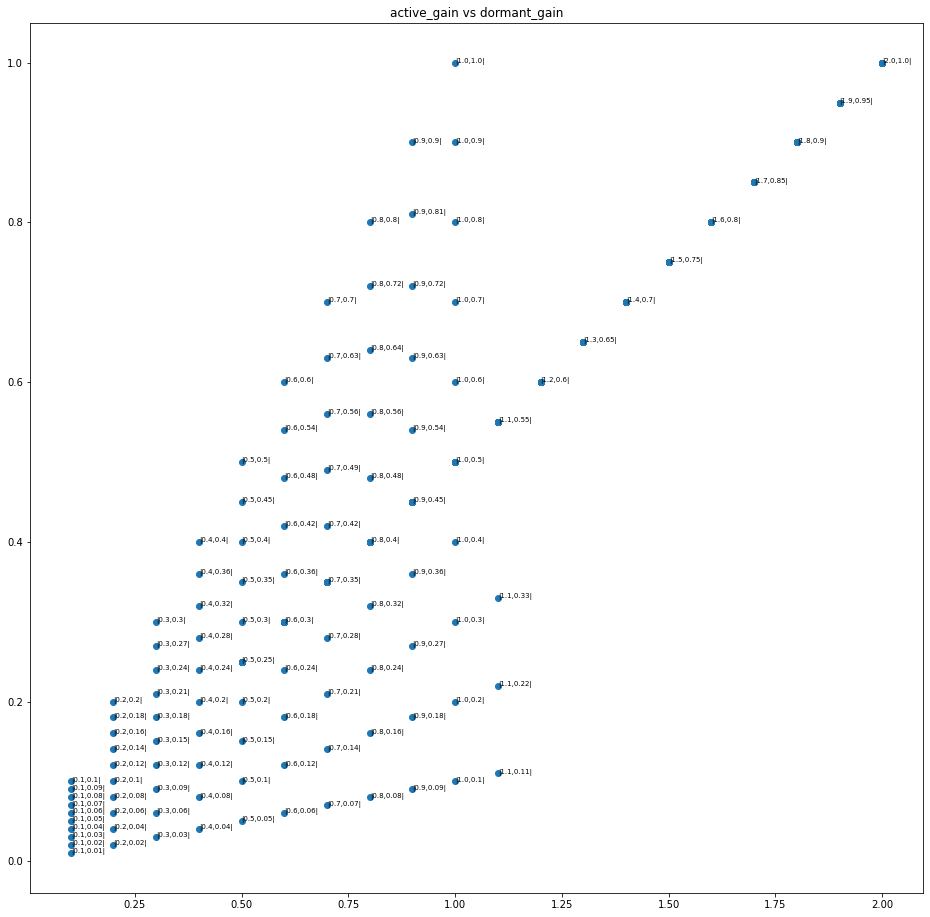

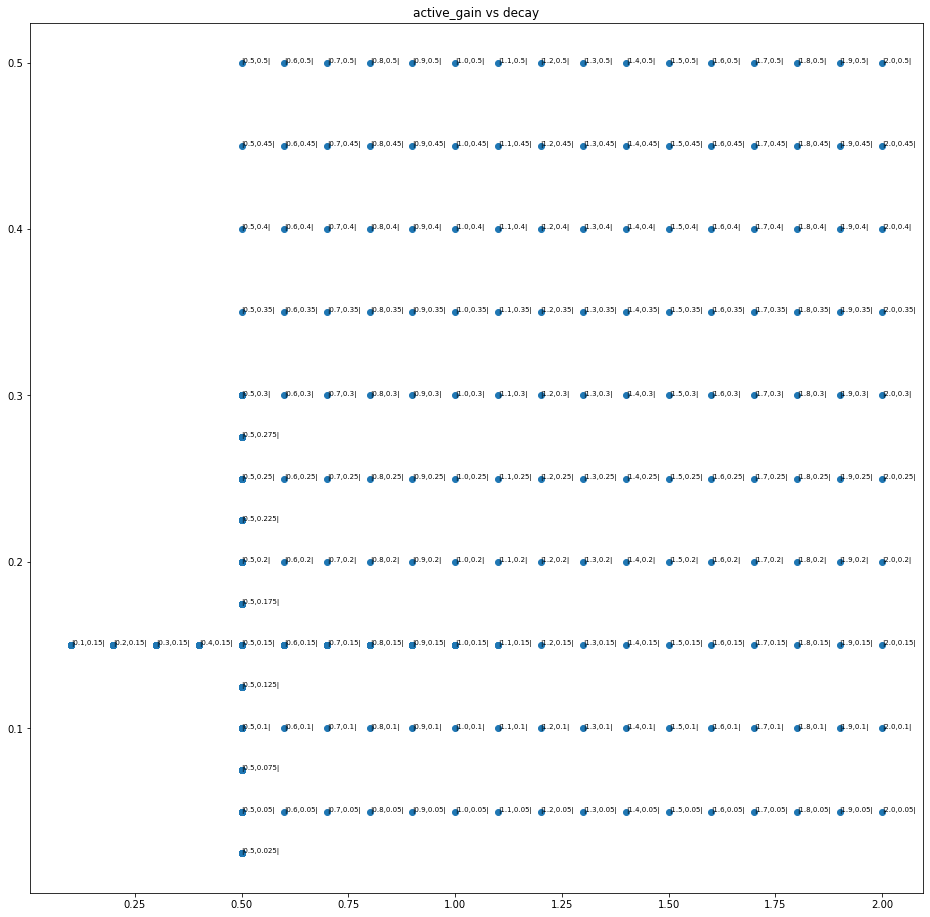

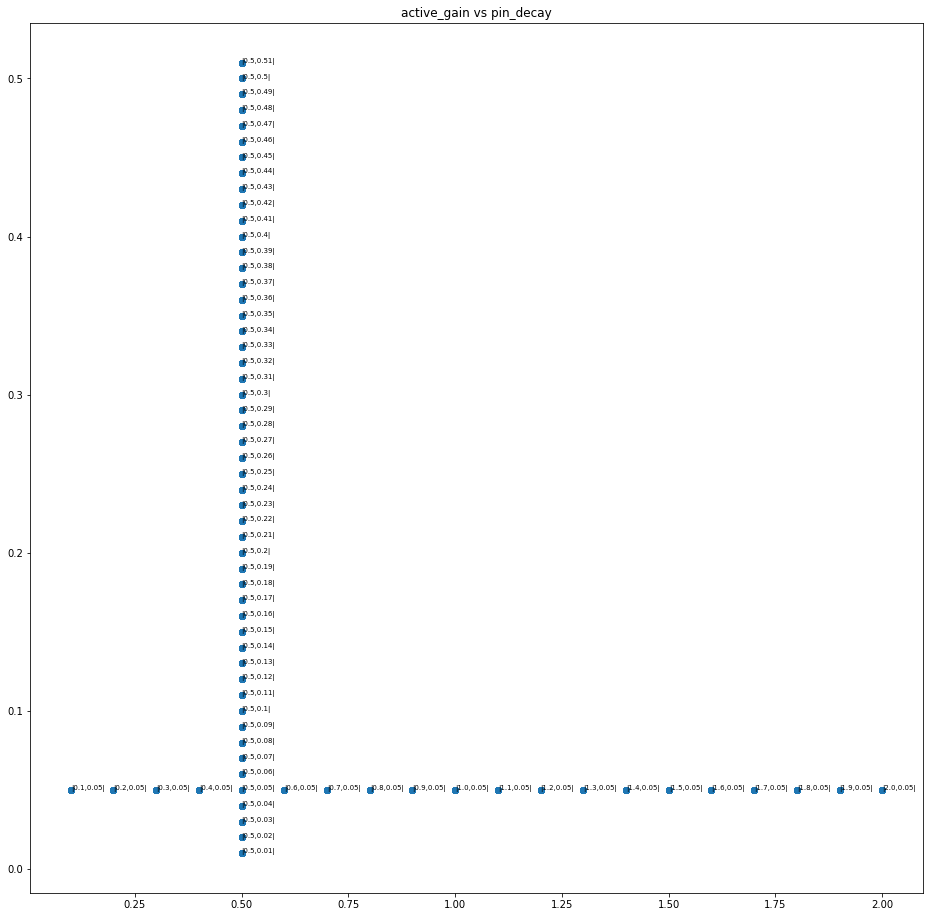

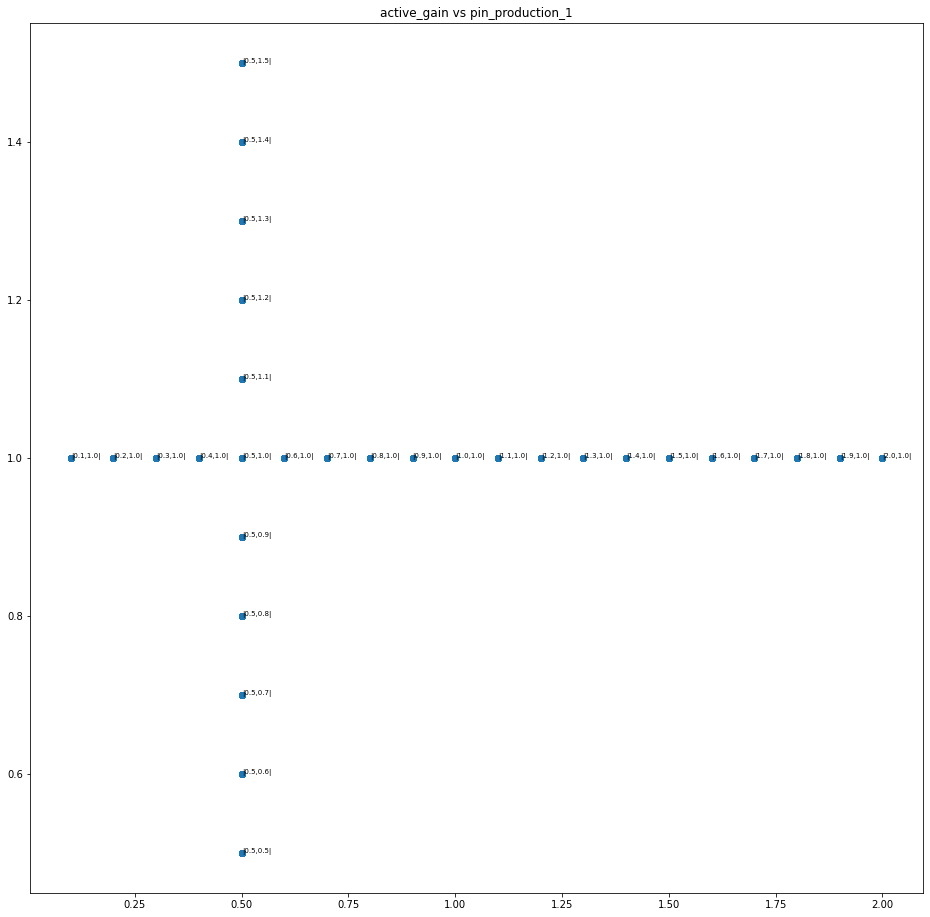

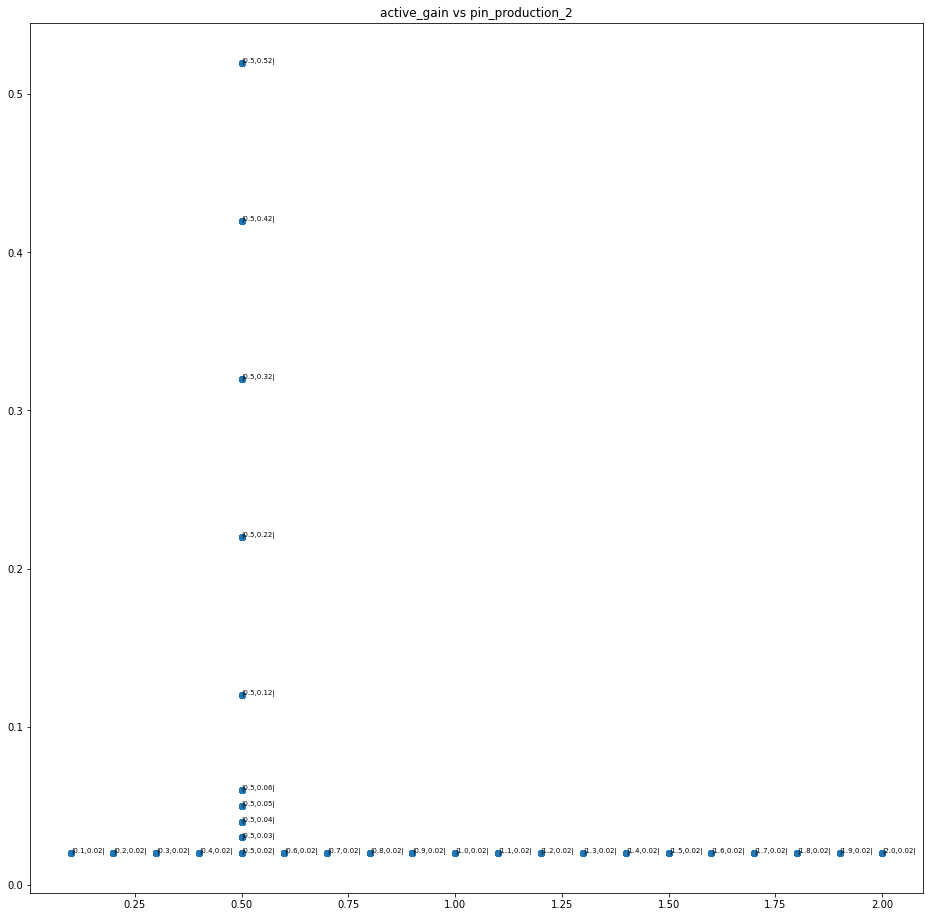

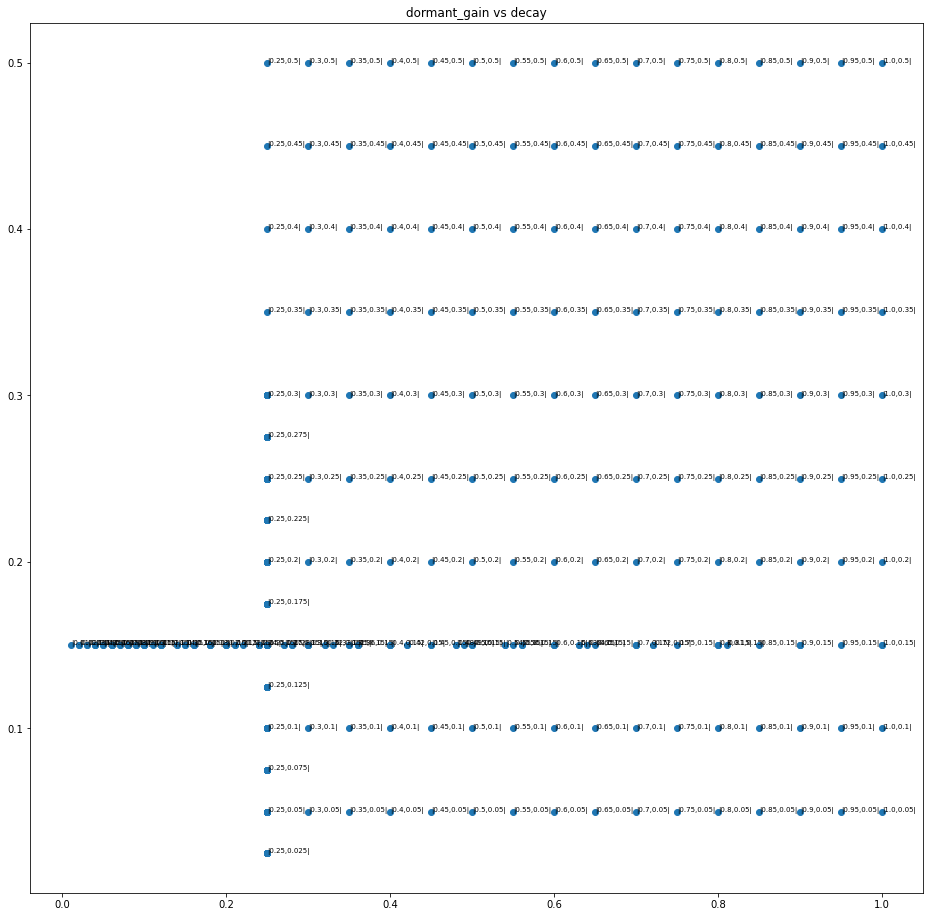

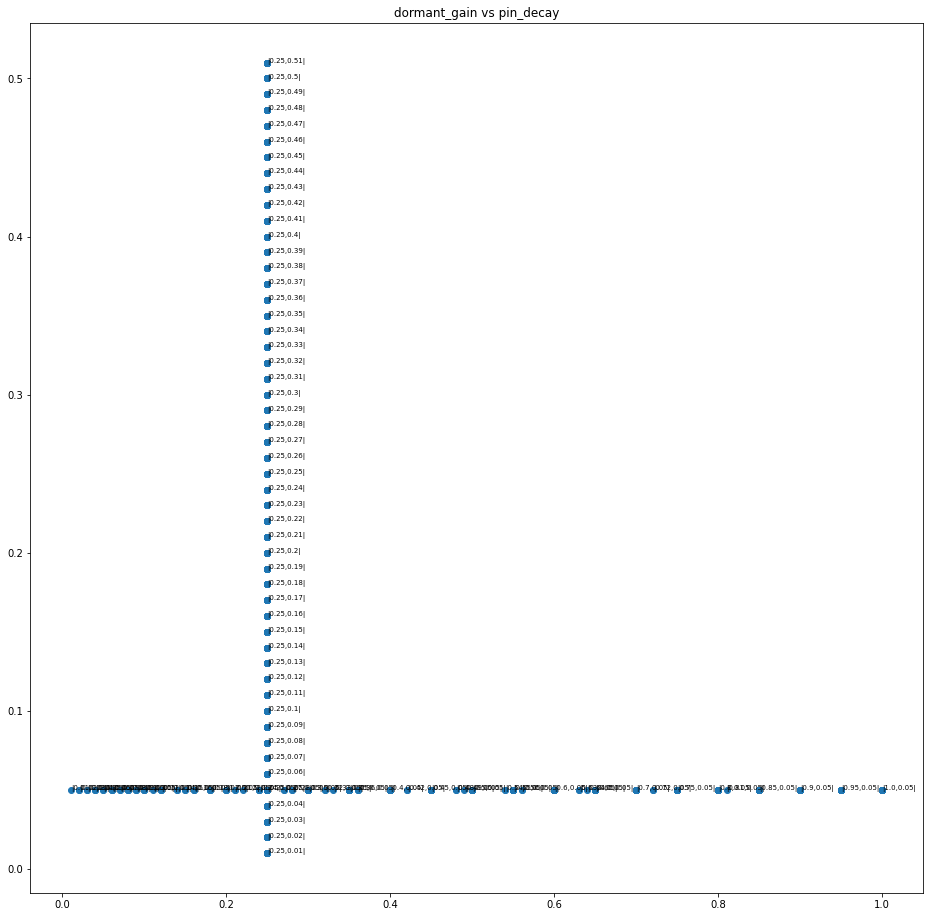

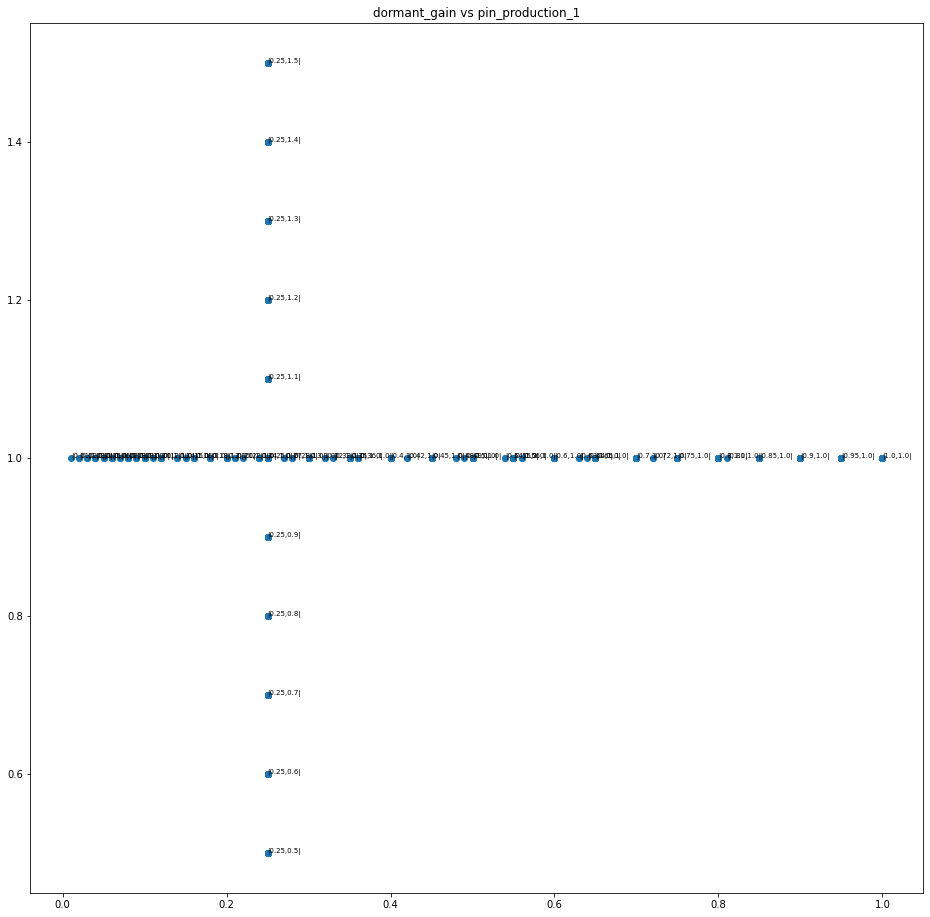

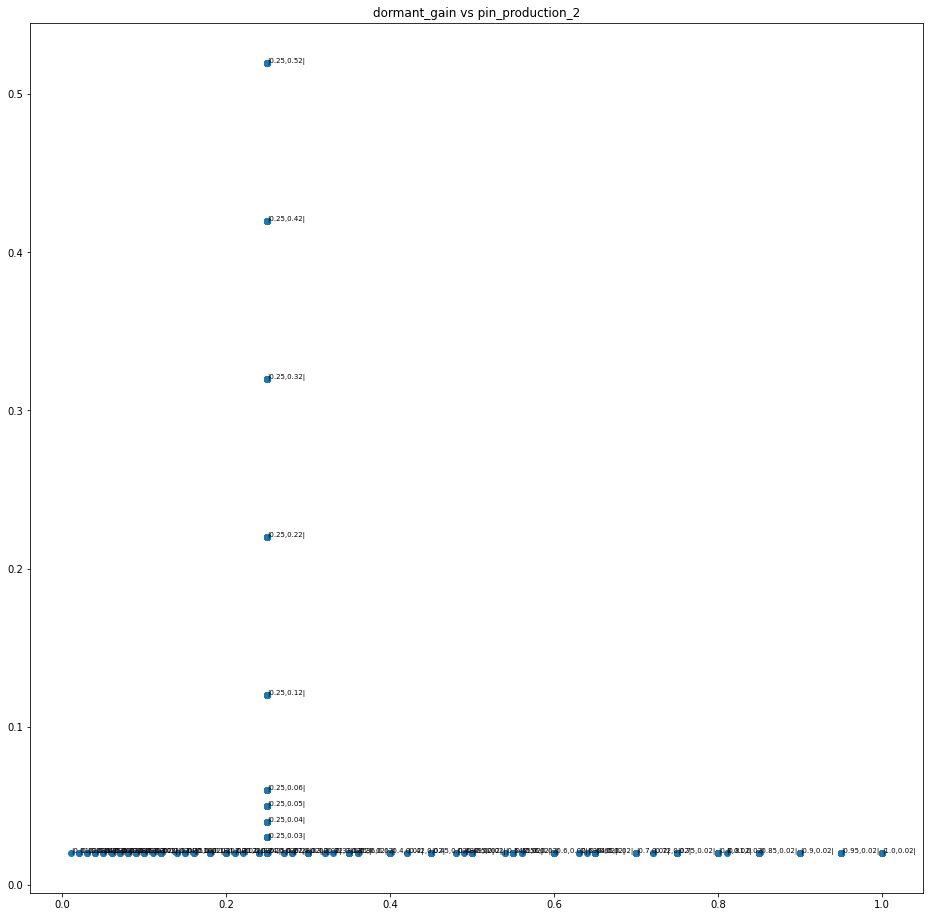

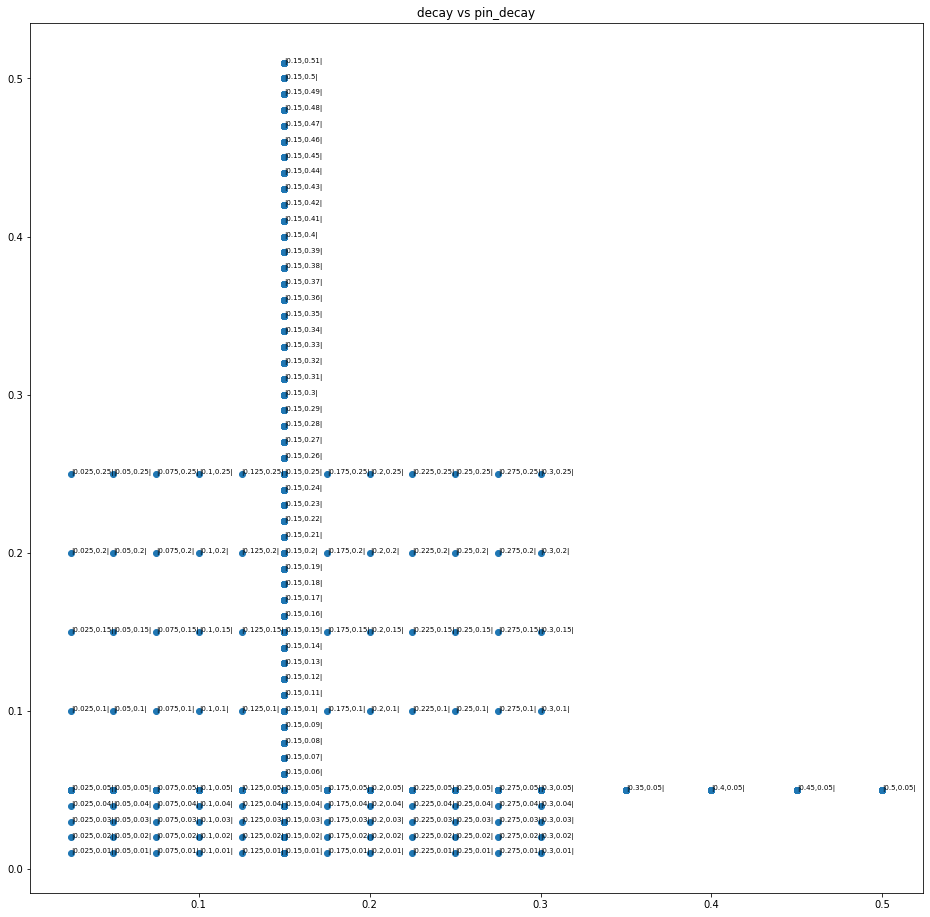

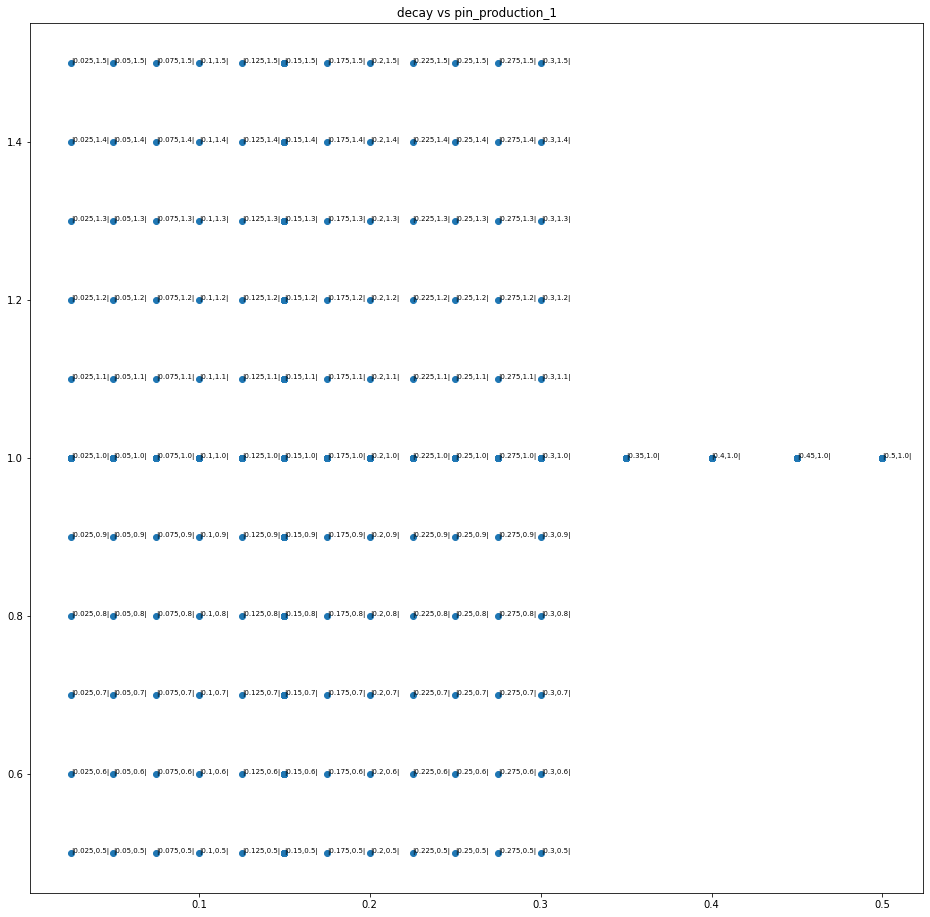

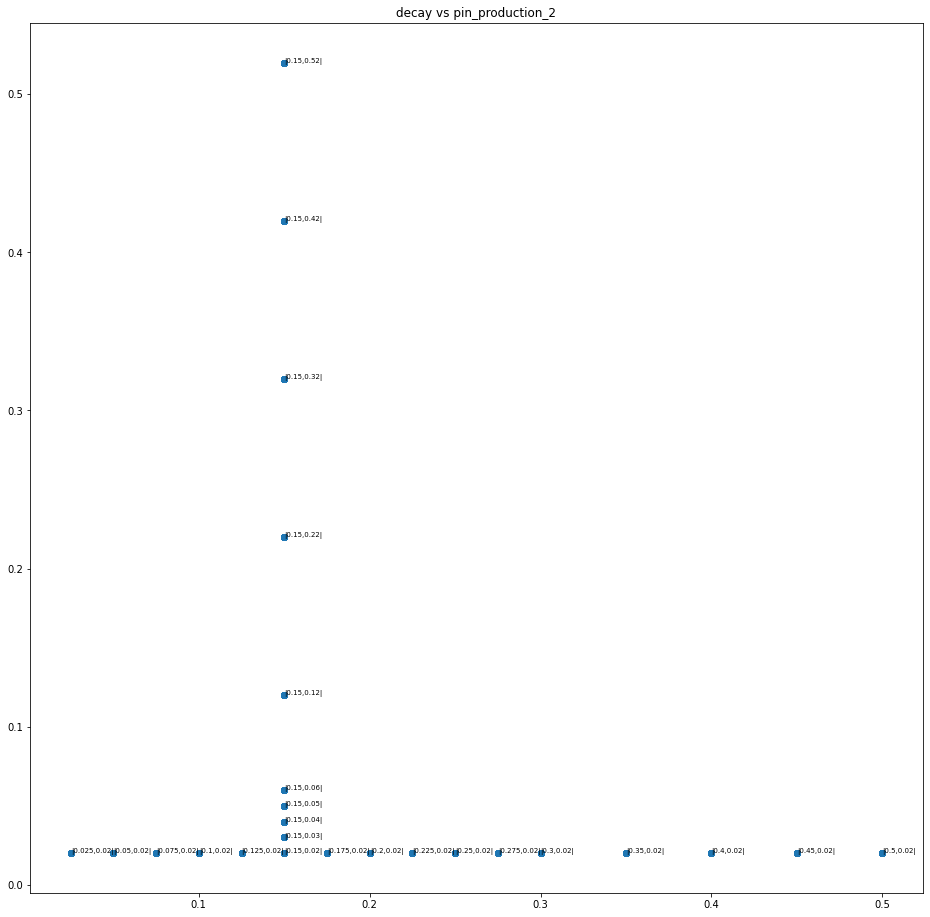

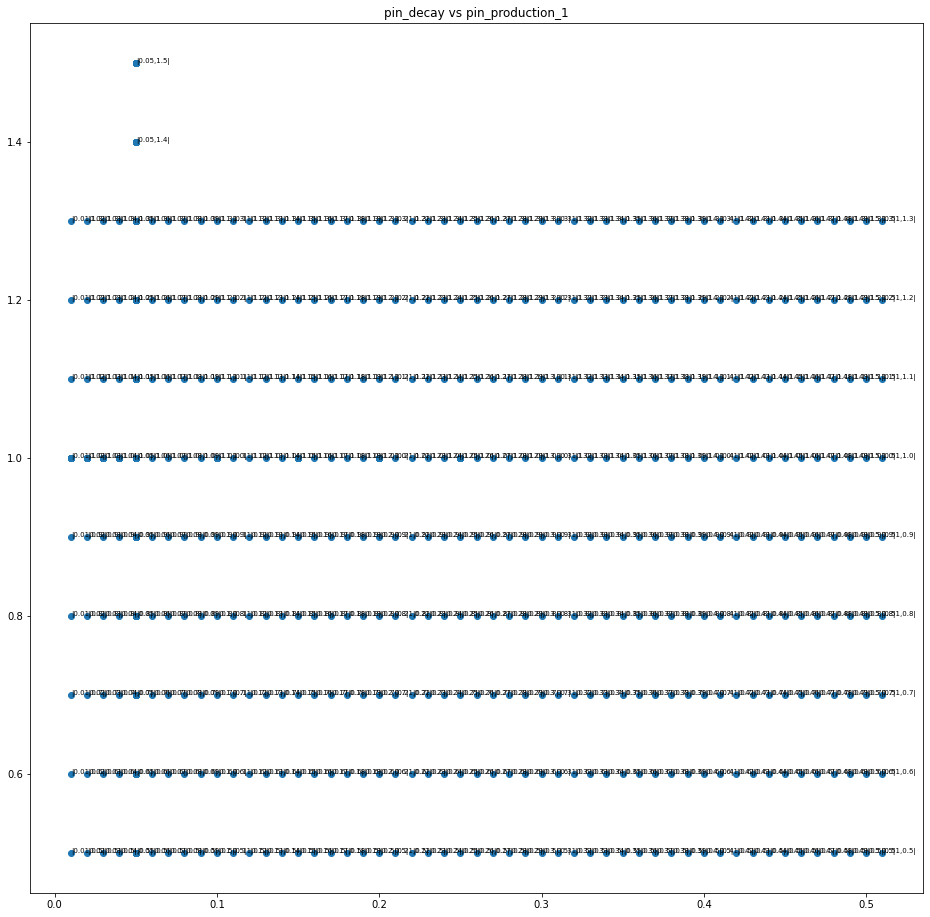

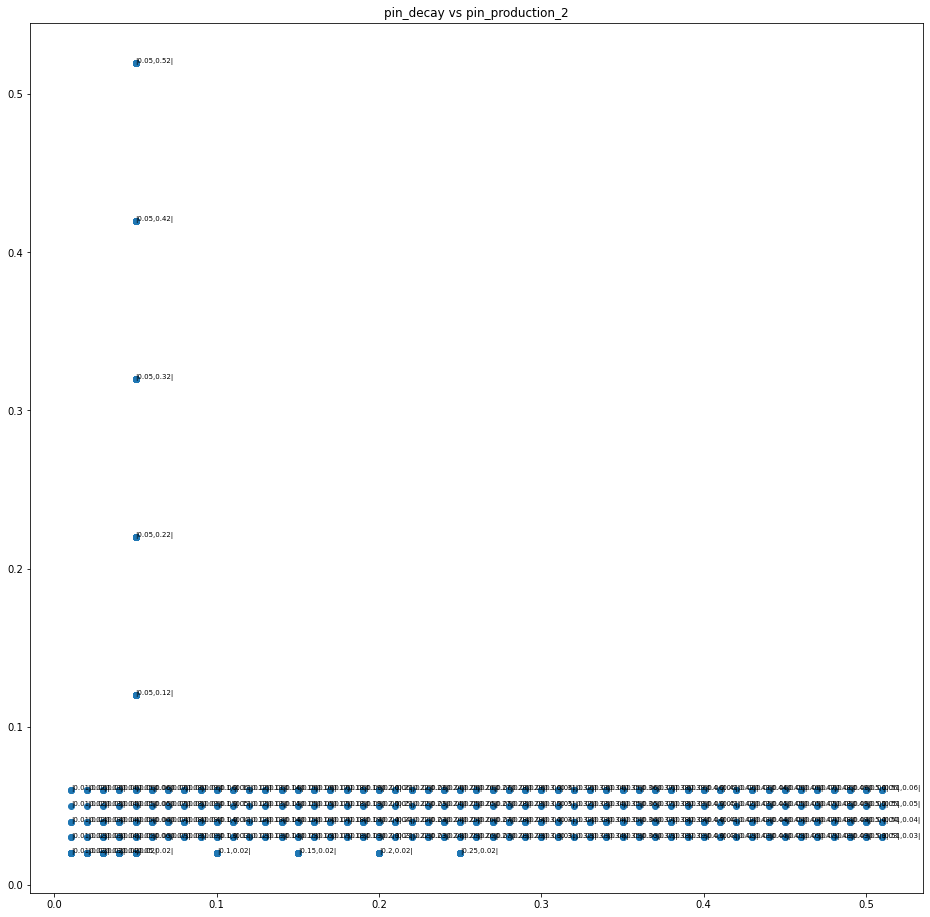

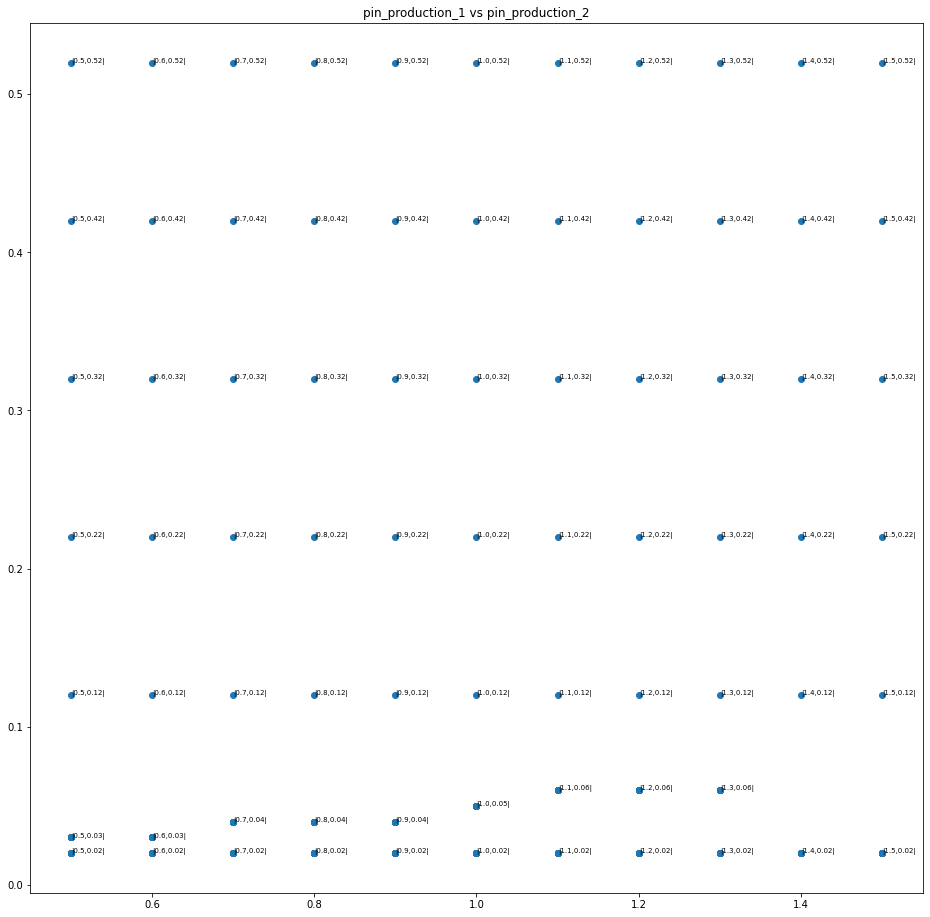

In [79]:
def show_values(a,b):
    fig = plt.figure(figsize=(16,16))
    plt.scatter([float(x[a]) for x in tuples],[float(x[b]) for x in tuples])
    for x,y in set(zip([float(x[a]) for x in tuples],[float(x[b]) for x in tuples])):
        plt.annotate(f"|{x},{y}|",(x,y),fontsize=7)
    plt.title(" vs ".join([names[a],names[b]]))
    plt.show()
for a in range(0,5):
    for b in range(a+1,6):
        # if names[a]!='decay':
        #     continue
        show_values(a,b)

coefficient of determination: 0.9535235463966916


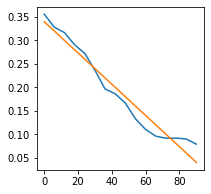

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
def calculate_regression(X,Y):
    x=np.array(X).reshape((-1, 1))
    y=np.array(Y)
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    print(f"coefficient of determination: {r_sq}")
    plt.figure(figsize=(3,3))
    y_pred = model.predict(x)
    plt.plot(x,y)
    plt.plot(x,y_pred)
    return model.intercept_,model.coef_[0],x,y_pred
def strip_avg(X2,Y2,ratio=0.5,strip_left=True,strip_right=True):
    X,Y=X2[:],Y2[:]
    avg_slope=abs((Y2[0]-Y2[-1])/len(X2))
    if abs(Y2[0]-Y2[1])<avg_slope*ratio and strip_left:
        X,Y=X2[1:],Y2[1:]
    if abs(Y2[-2]-Y2[-1])<avg_slope*ratio and strip_right:
        X,Y=X2[:-1],Y2[:-1]
    return X,Y

def strip_avg_full(X2,Y2,ratio=0.5,strip_left=True,strip_right=True):
    X,Y=strip_avg(X2,Y2,ratio,strip_left,strip_right)
    old_l=len(X2)
    while len(X)!=old_l:
        old_l=len(X)
        X,Y=strip_avg(X,Y)
    return X,Y

X2,Y2= temp
X,Y=strip_avg_full(X2,Y2)
model=calculate_regression(X,Y)


gain_ratio vs active_gain
active_gain vs decay
pin_decay vs decay
decay vs pin_production_1
pin_production_1 vs pin_production_2


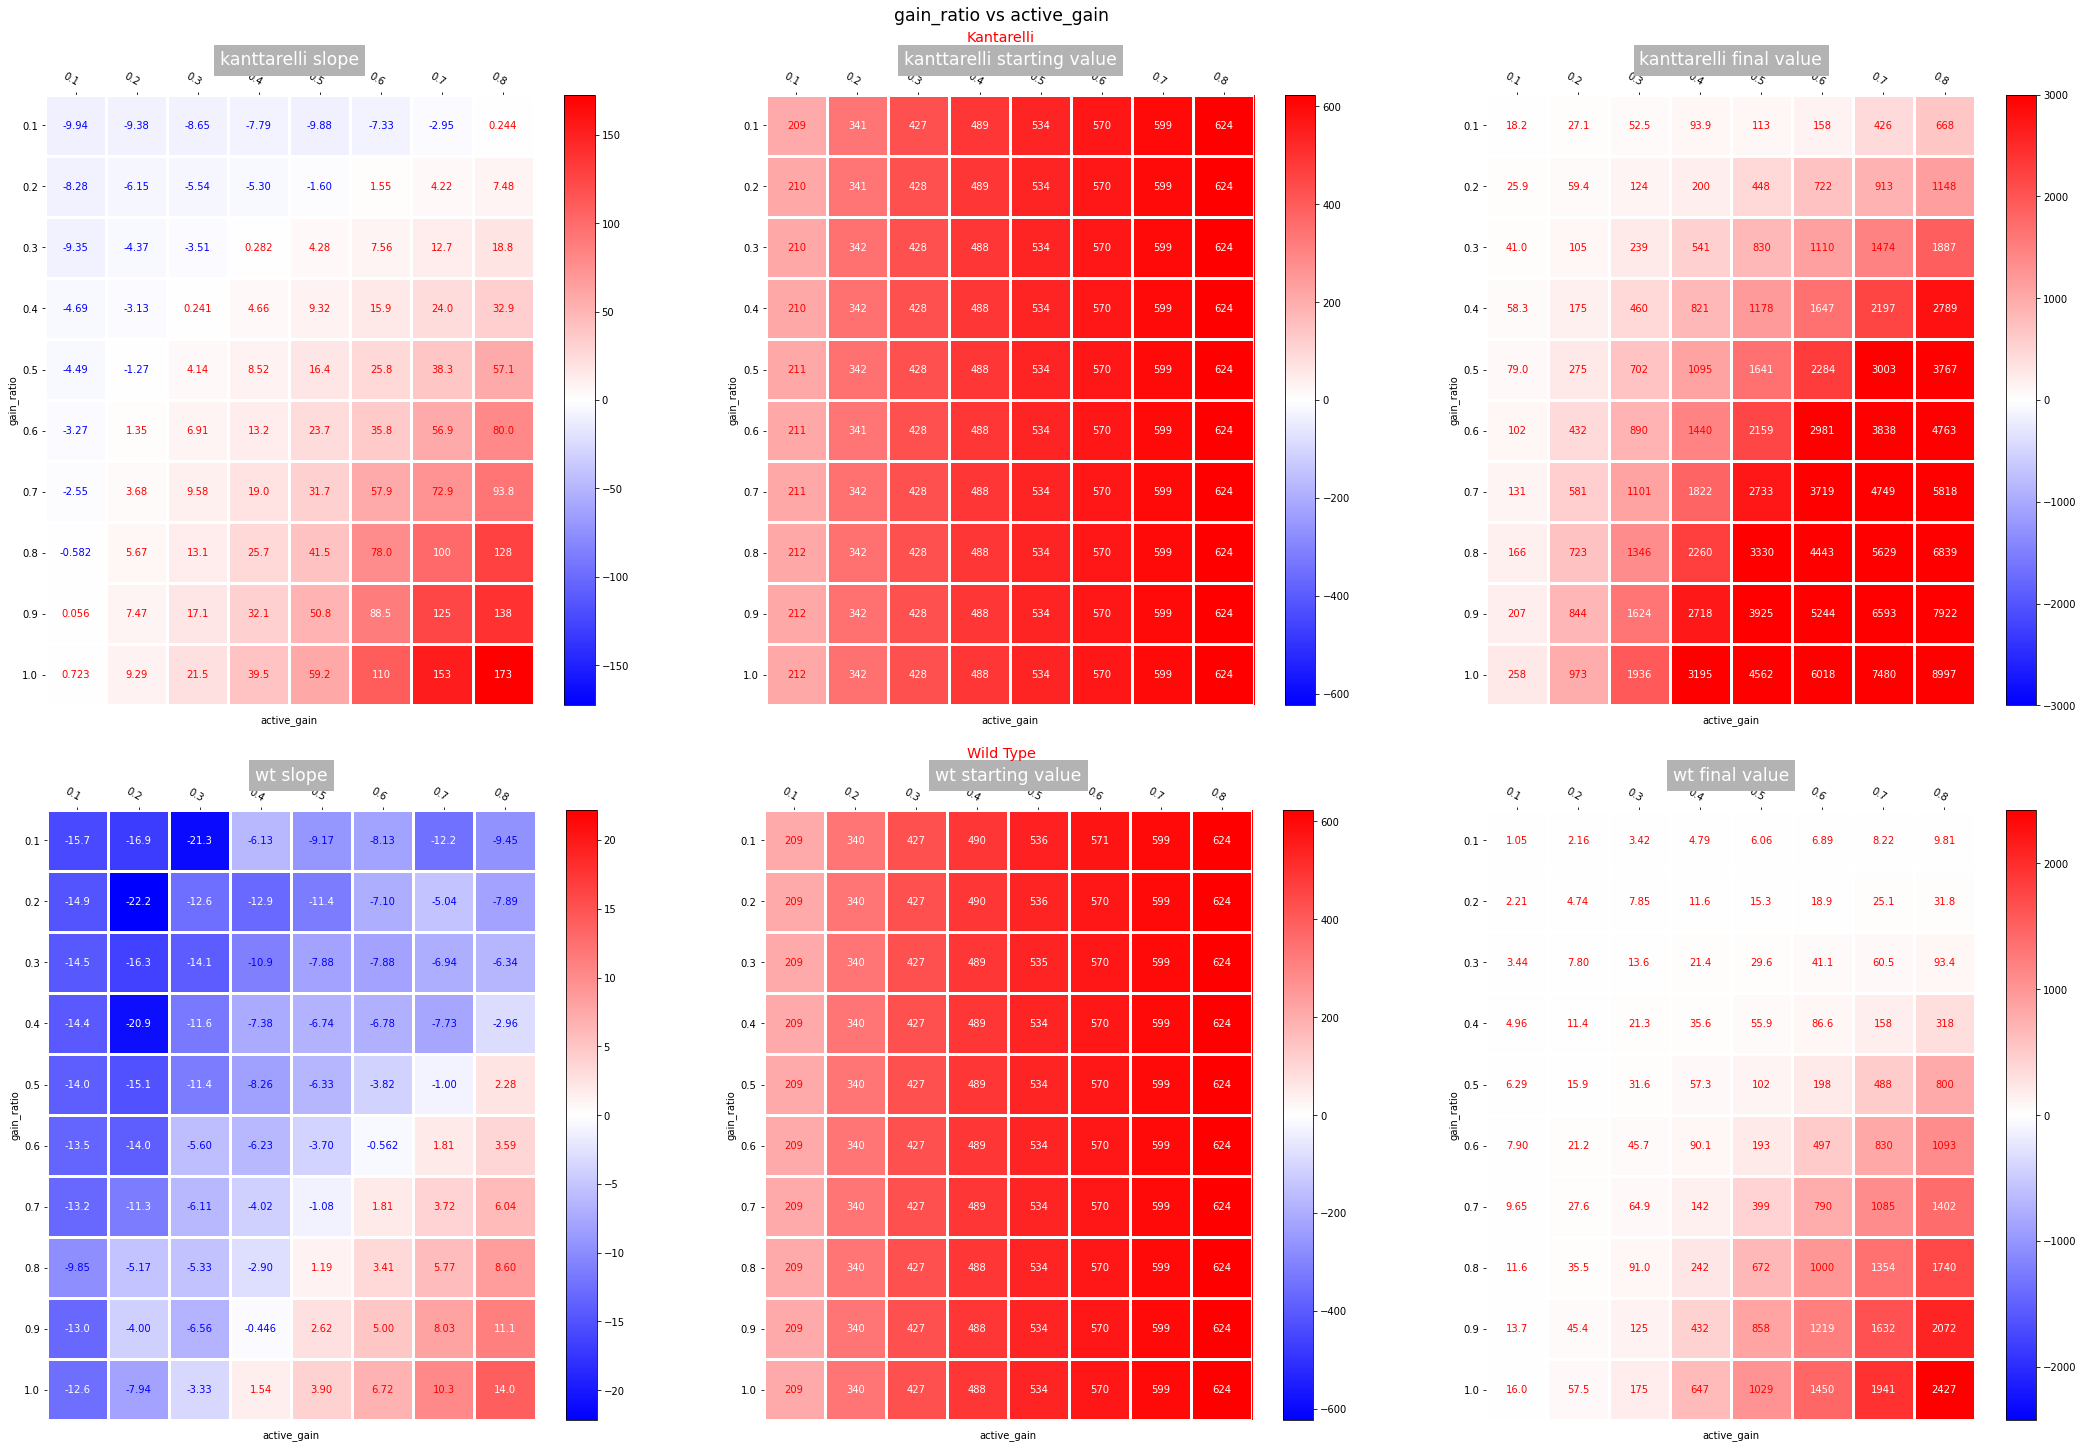

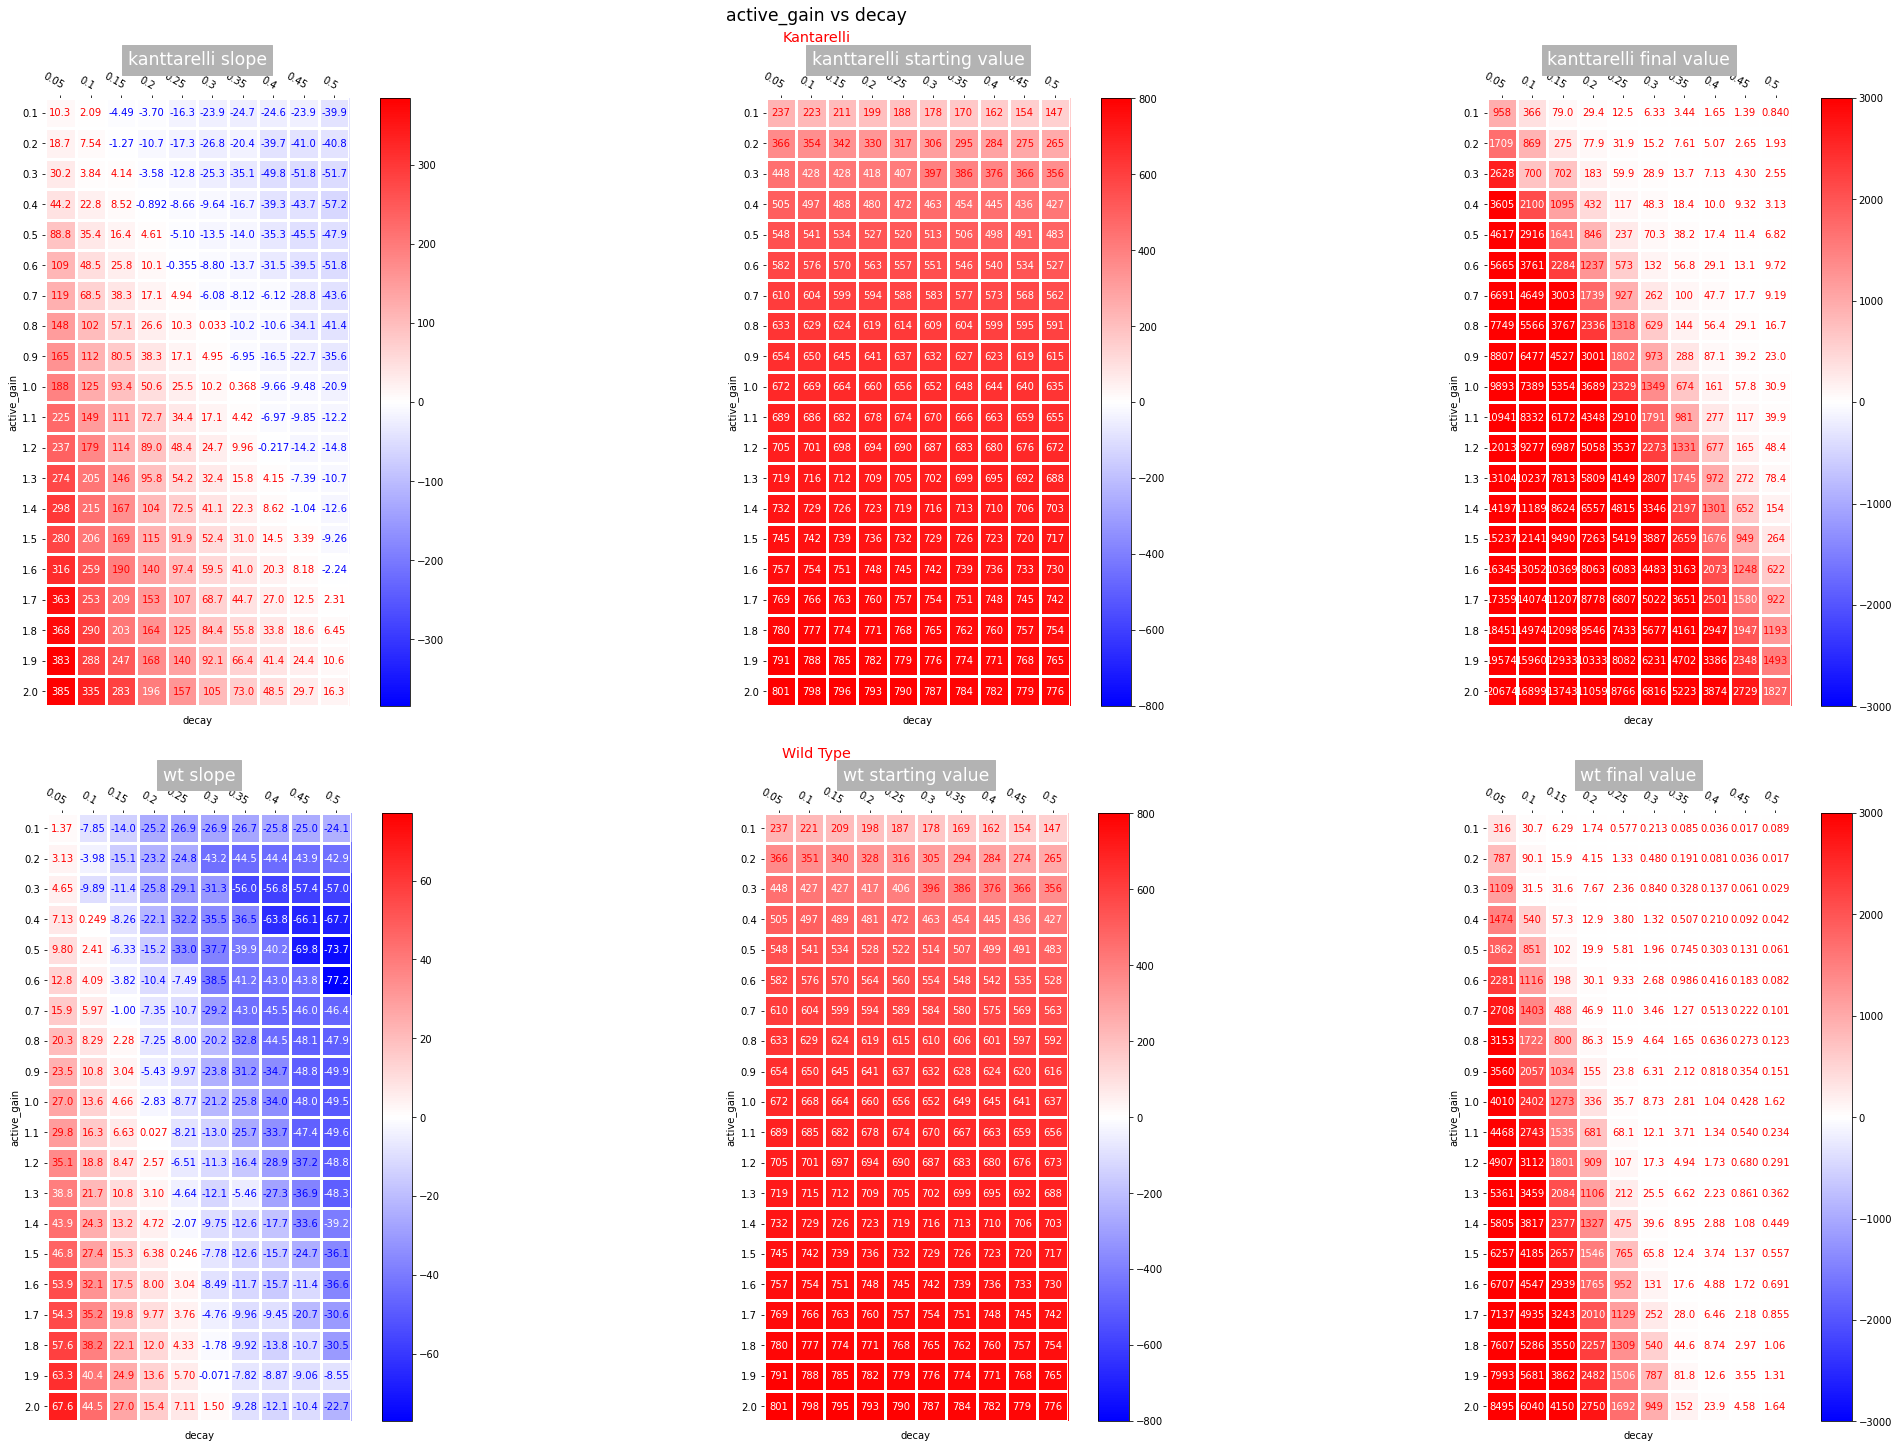

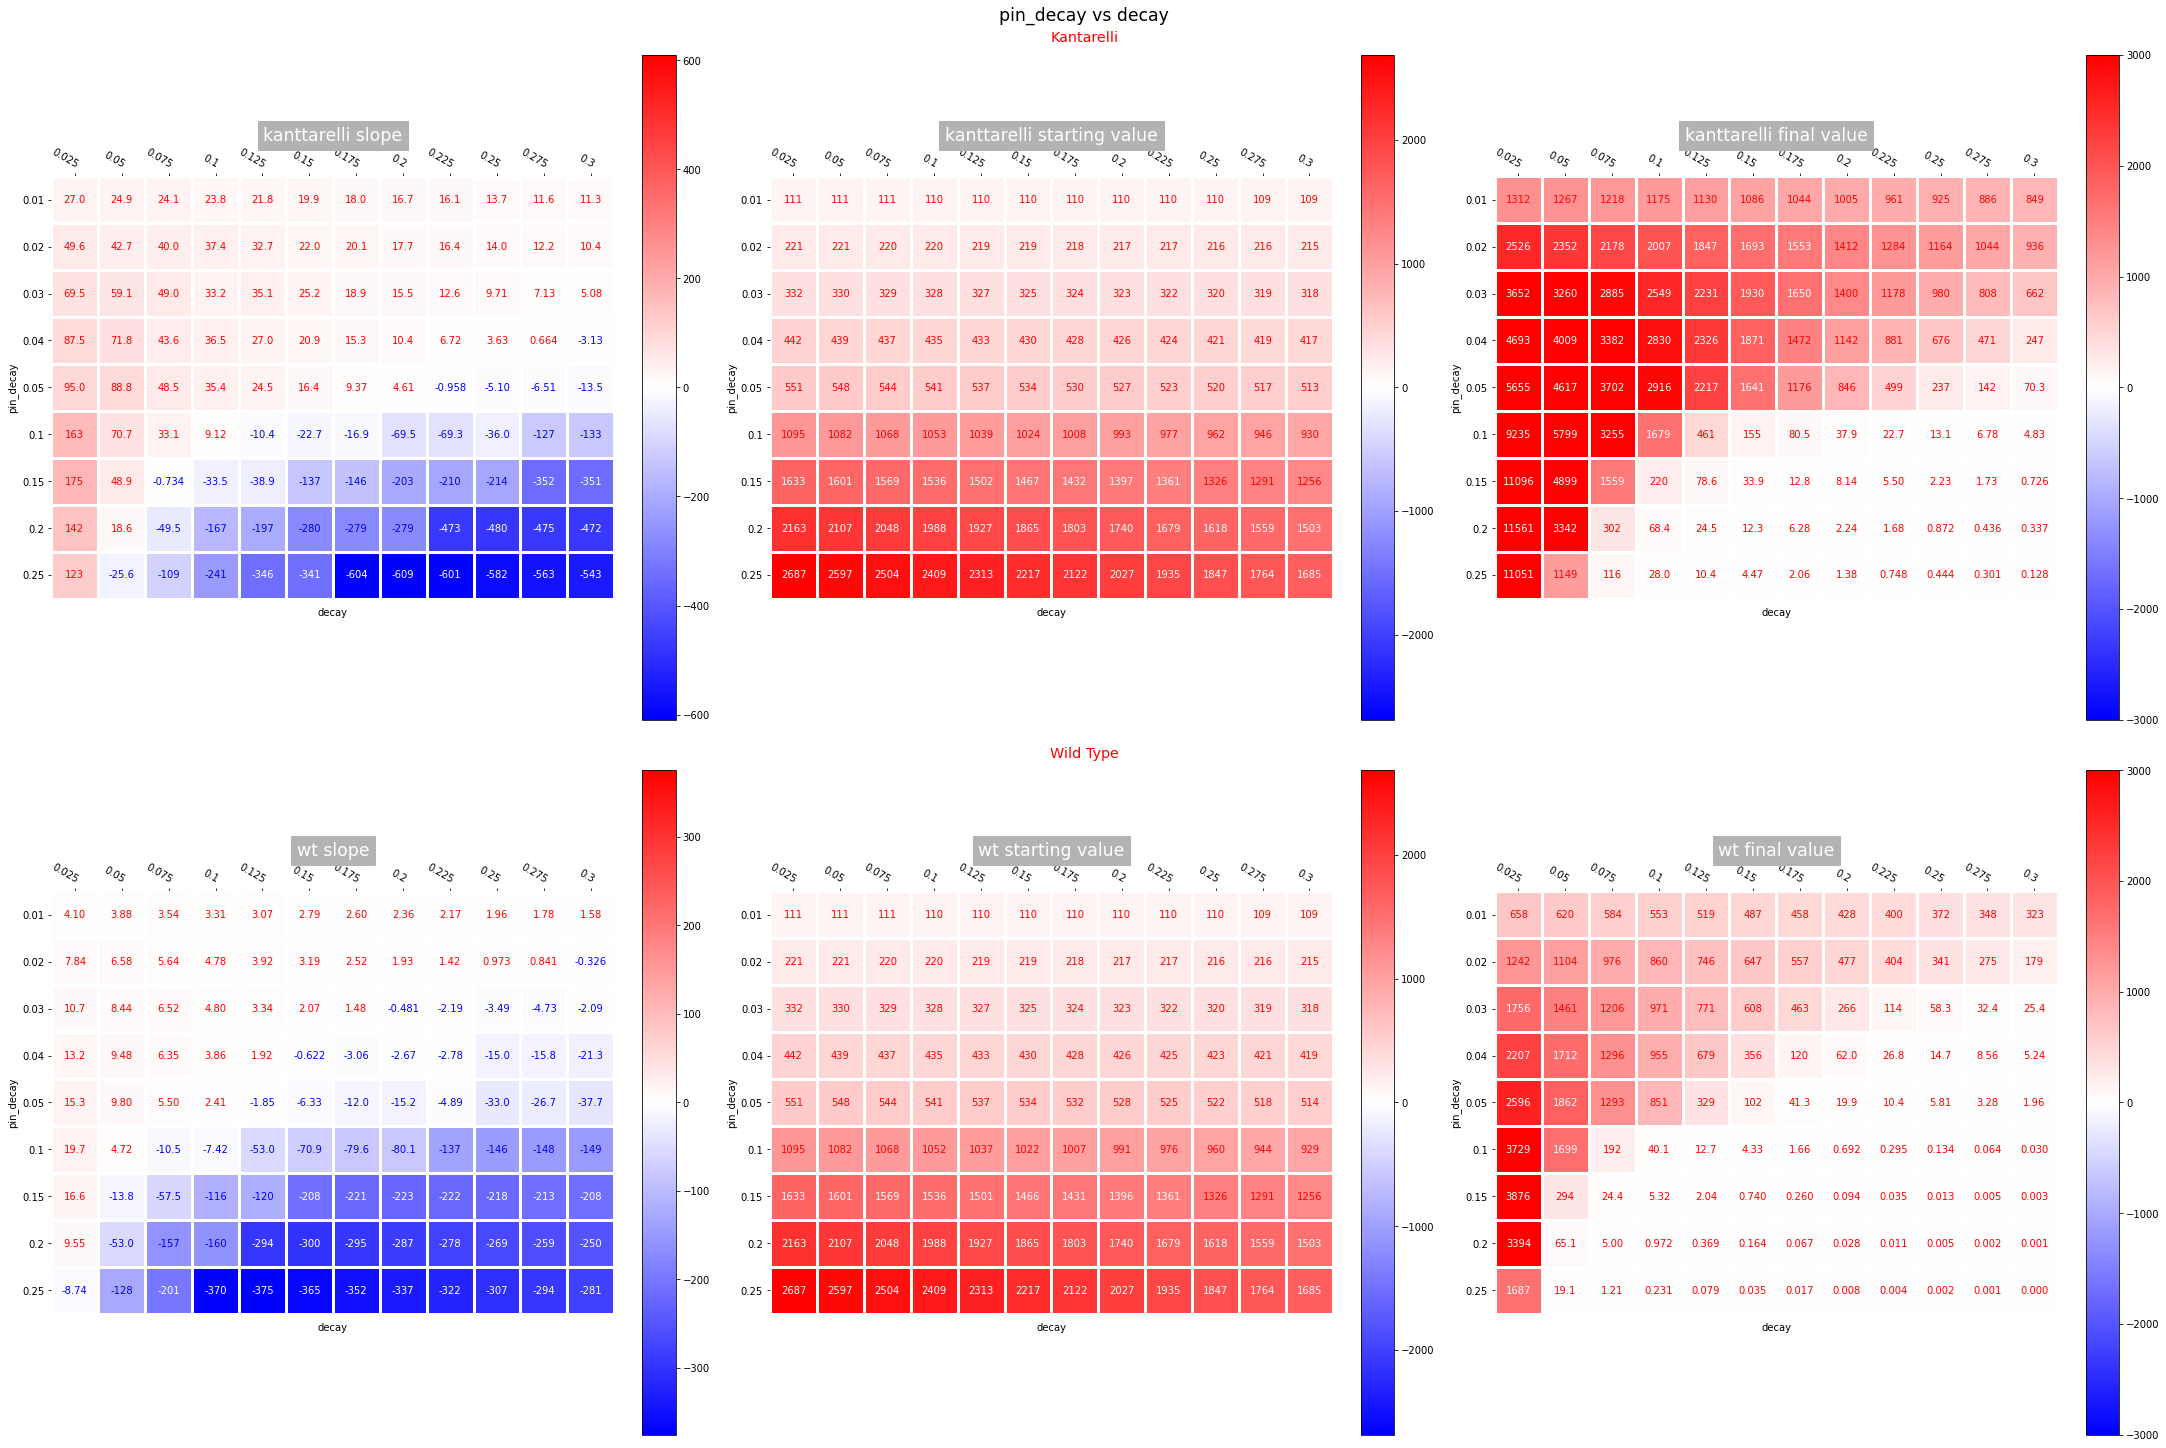

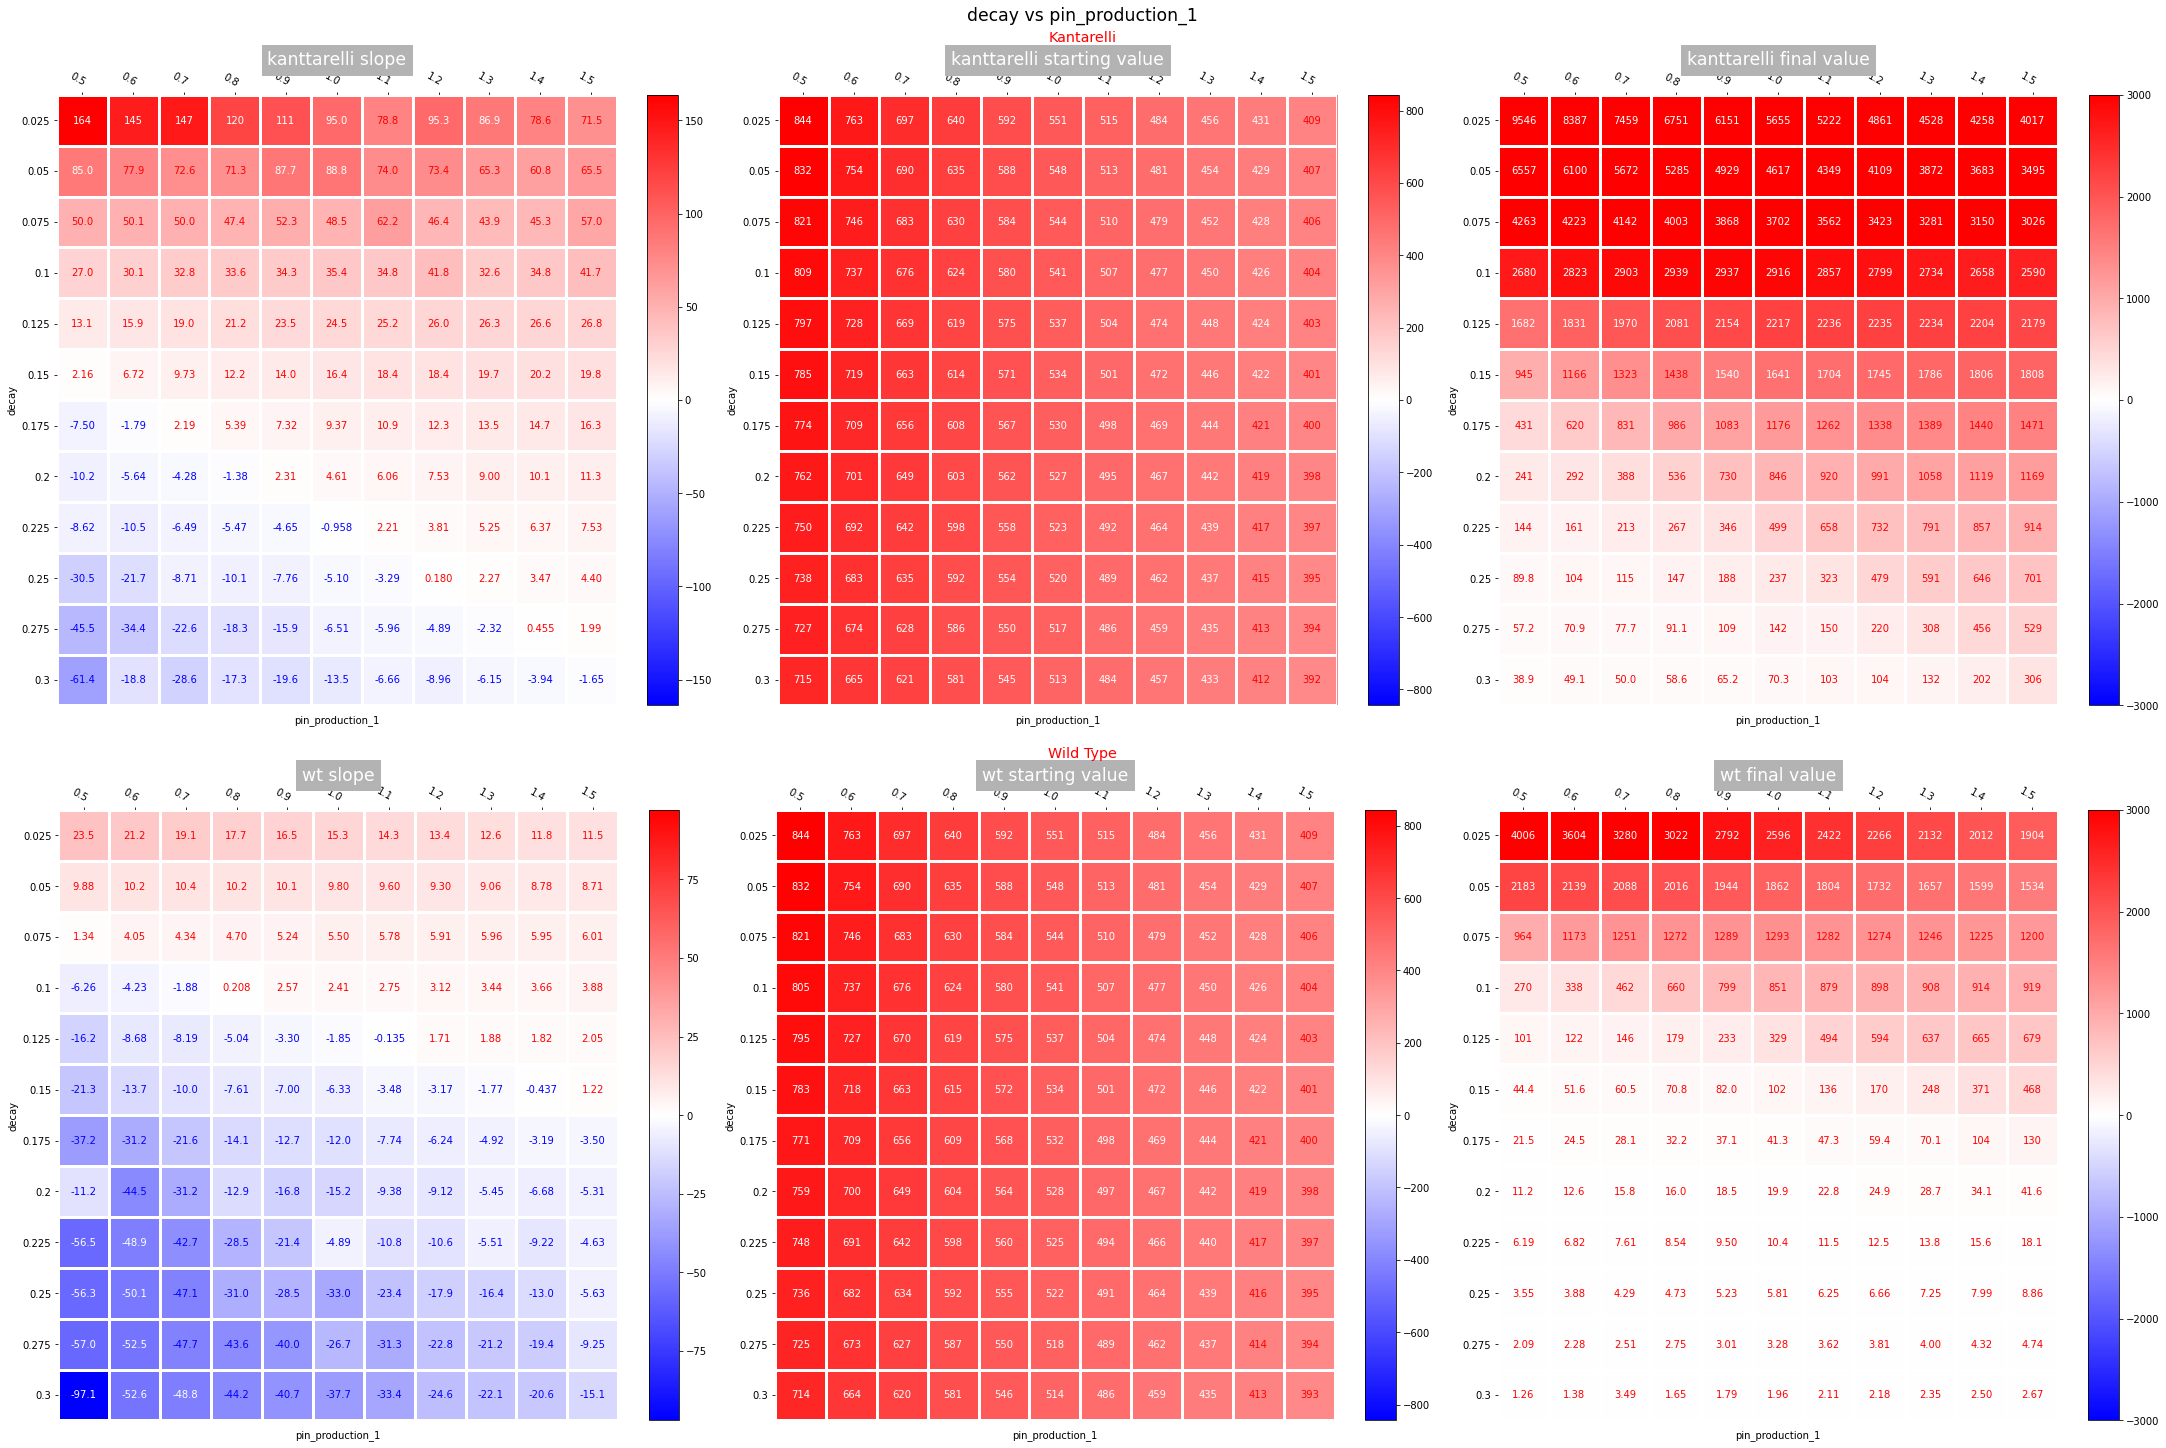

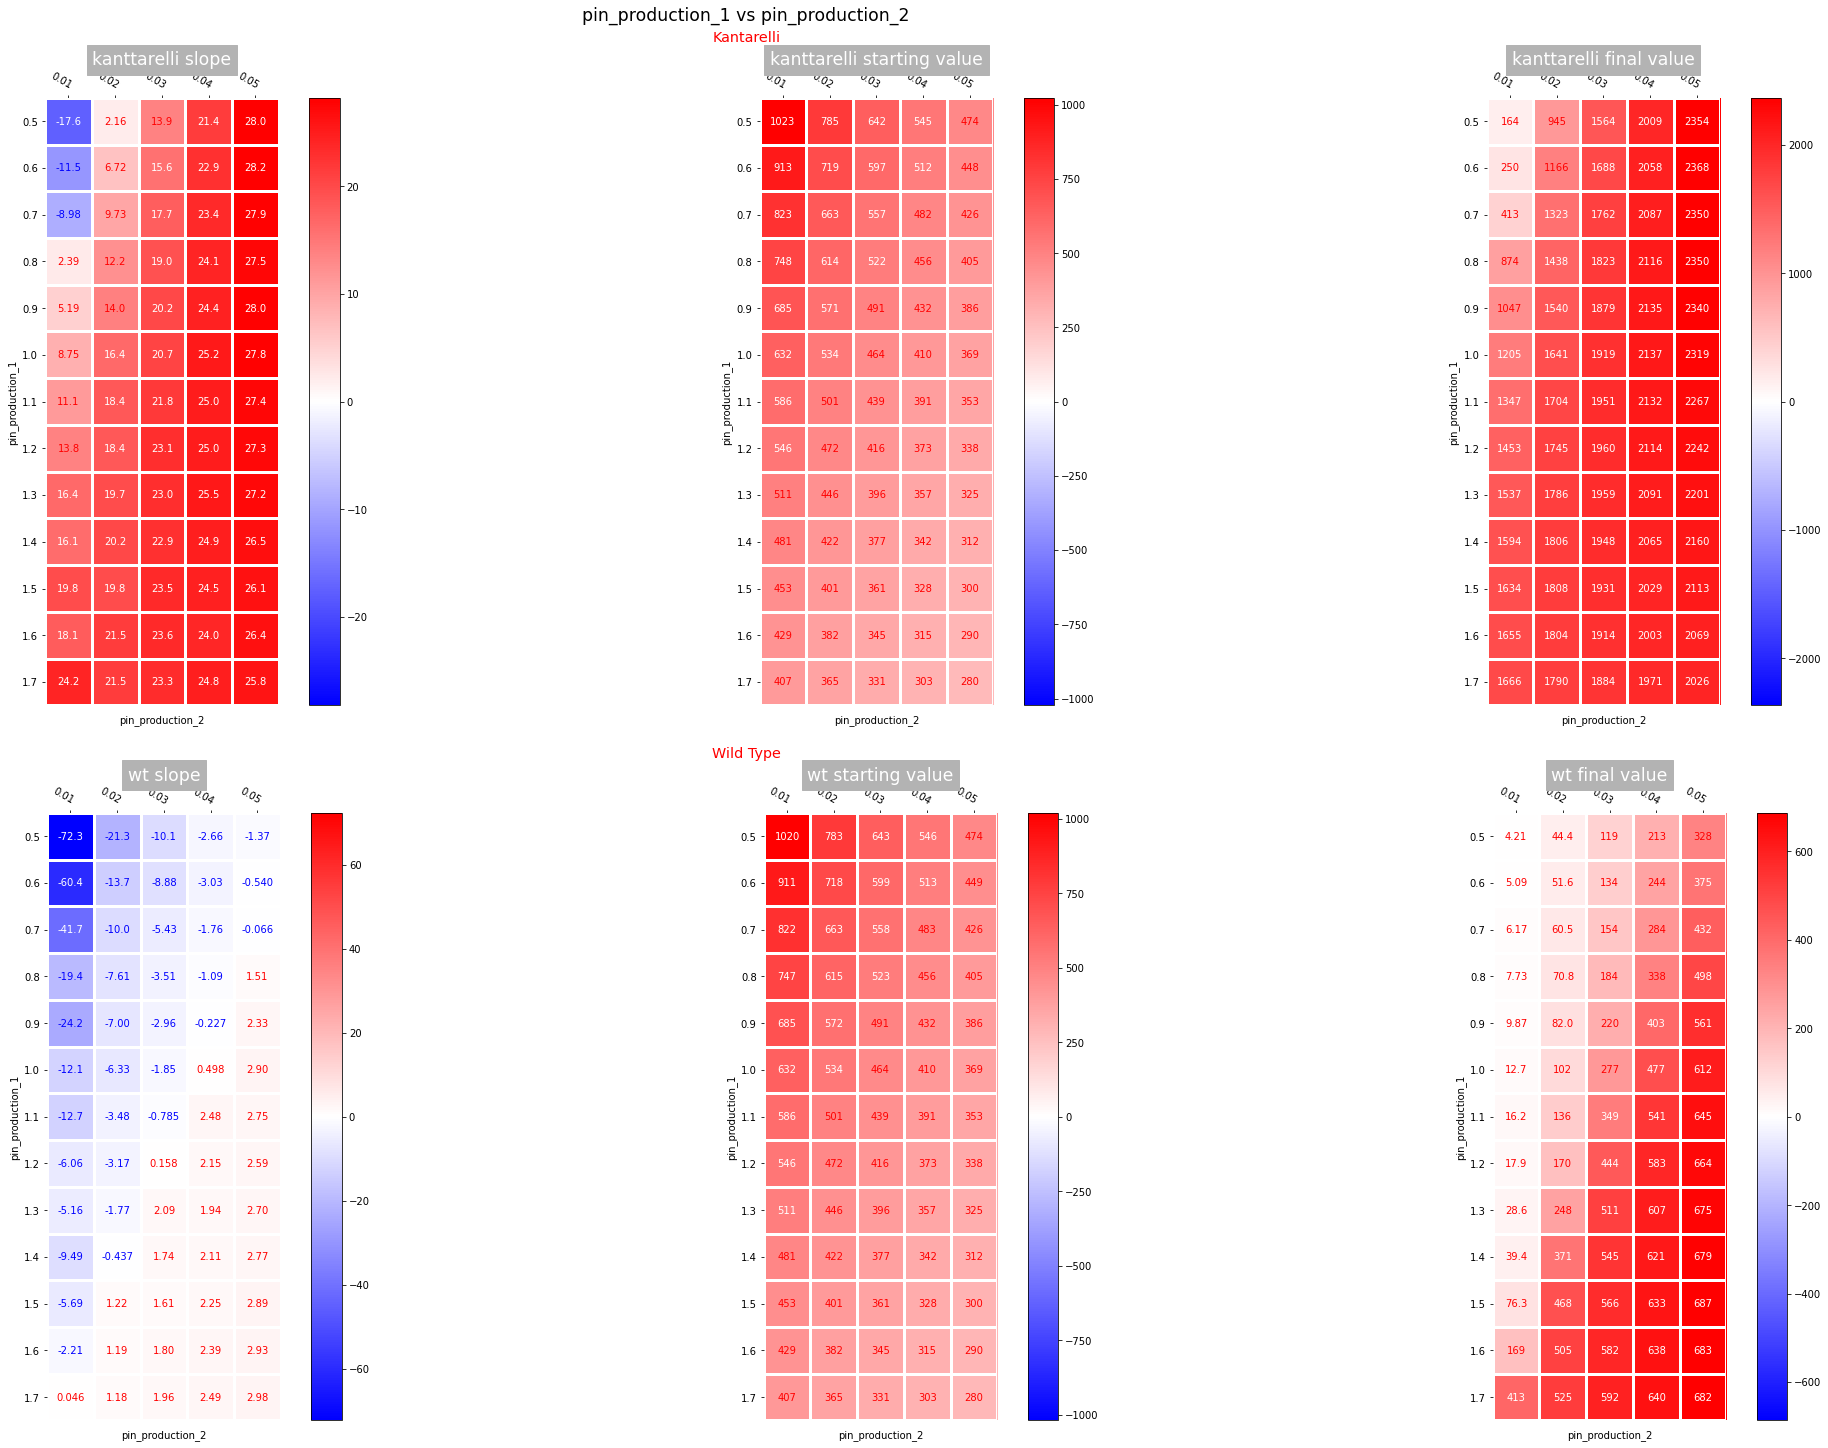

In [37]:

#gain_ratios vs active_gain
names=["rnai60","wt","pole"]
gain_ratio = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.]
active_gain = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
print("gain_ratio vs active_gain")
draw_heatmaps("gain_ratio","active_gain",gain_ratios,active_gain)

#active_gain vs decay
print("active_gain vs decay")
draw_heatmaps("active_gain","decay",[0.1, 0.2, 0.3, 0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9, 2. ],[0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])

#decay vs pin_decay
pin_decay=[0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 0.25]
decay = [0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3]
print("pin_decay vs decay")
draw_heatmaps("pin_decay","decay",pin_decay,decay)

#decay vs pin_production 
decay = [0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3]
pin_production_1 = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
print("decay vs pin_production_1")
draw_heatmaps("decay","pin_production_1",decay,pin_production_1)

#dormant_gain vs decay
# decay = [0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ]
# dormant_gain = [0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75,    0.8 , 0.85, 0.9 , 0.95, 1.  ]
# print("dormant_gain vs decay")
# draw_heatmaps("decay","activr",decay,dormant_gain)

#pin_decay vs pin_production
# pin_decay=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
#        0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
#        0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
#        0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
#        0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ]
# pin_production_1 = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
# print("pin_decay vs pin_production")
# draw_heatmaps("pin_decay","pin_production_1",pin_decay,pin_production_1)     
#pin_production_1 vs pin_production_2
pin_production_1 = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3,1.4,1.5,1.6,1.7]
pin_production_2 = [0.01,0.02,0.03,0.04,0.05]
print("pin_production_1 vs pin_production_2")
draw_heatmaps("pin_production_1","pin_production_2",pin_production_1,pin_production_2)



gain_ratio vs gain_value
pin_decay 0.04,decay 0.15


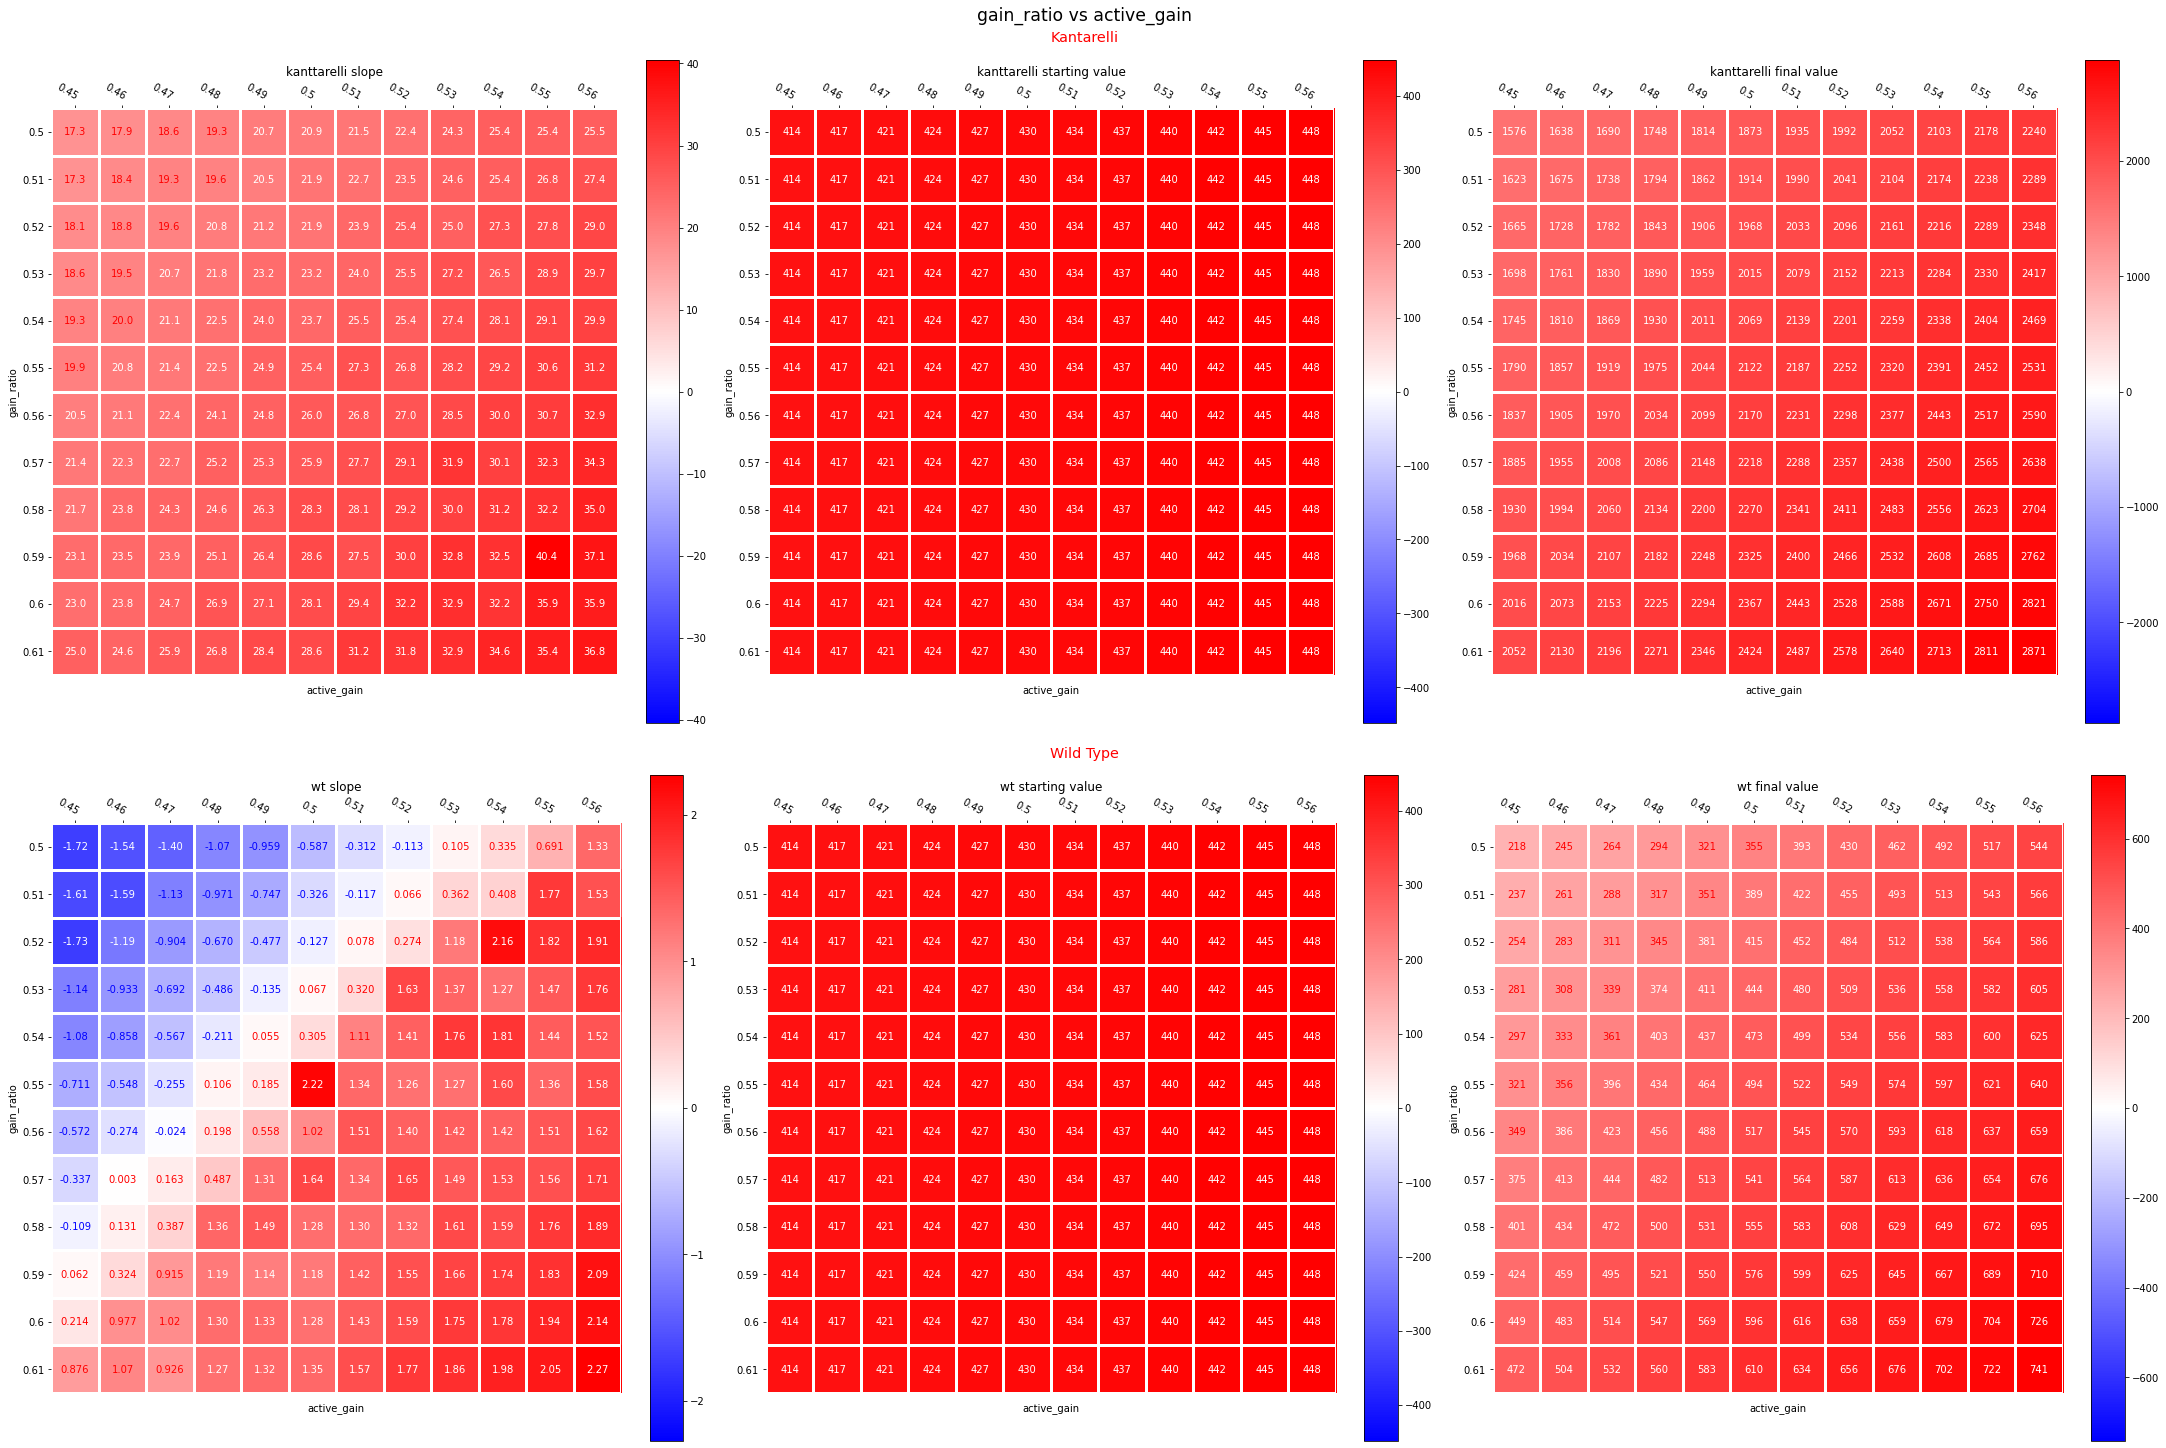

pin_decay 0.04,decay 0.175


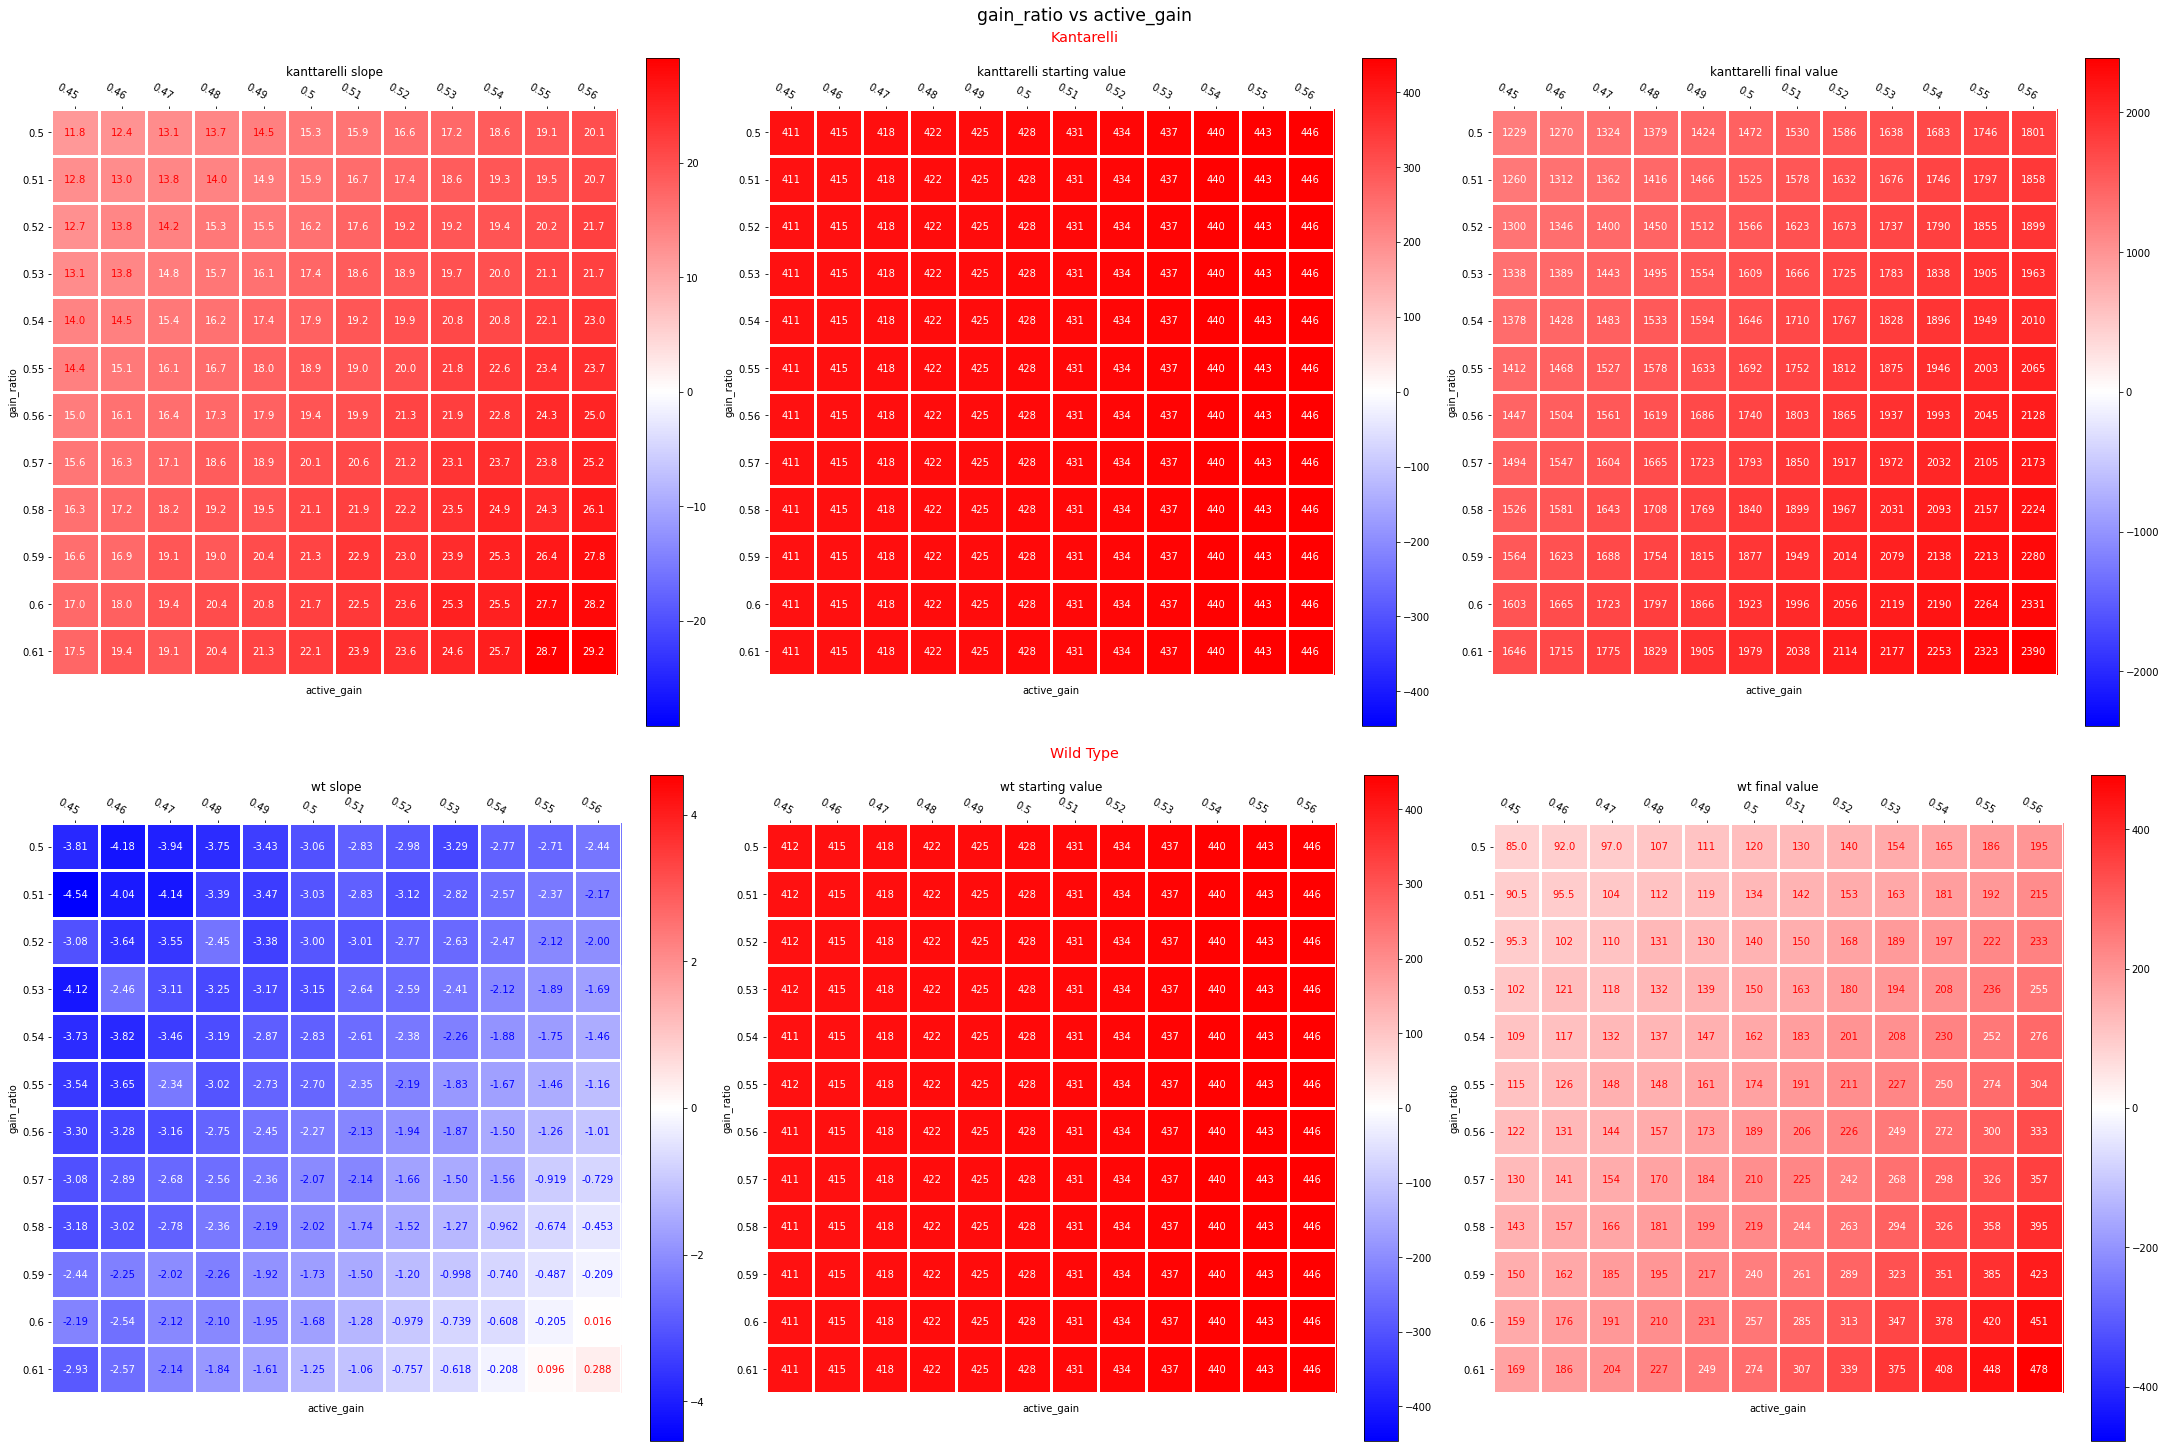

pin_decay 0.04,decay 0.2


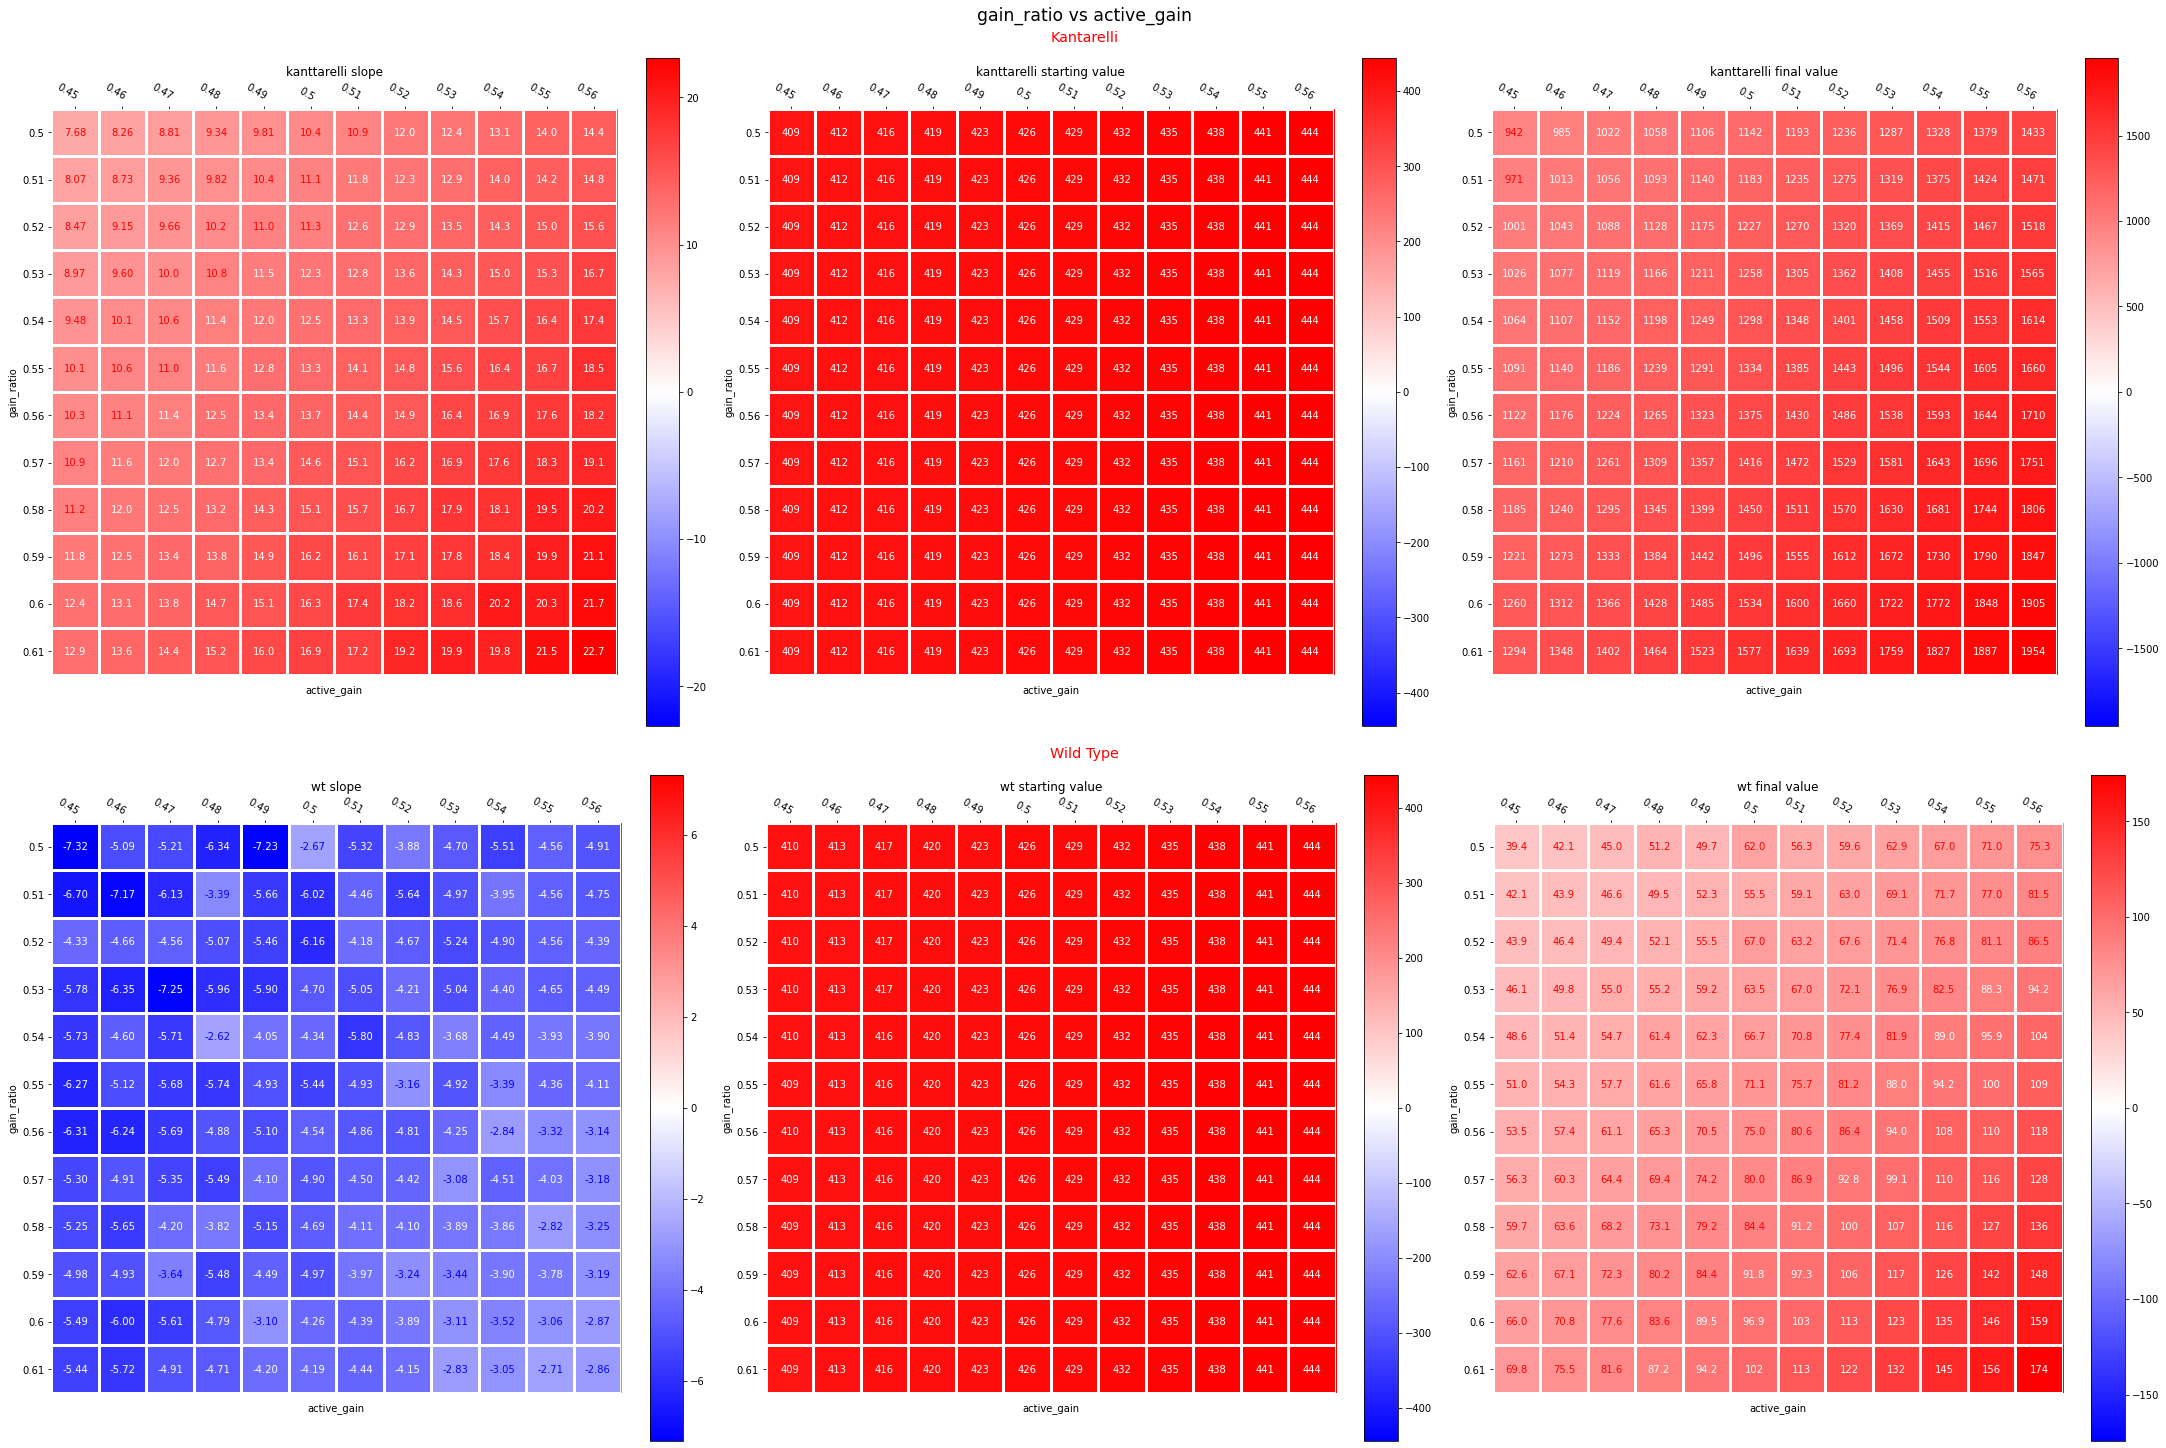

pin_decay 0.05,decay 0.15


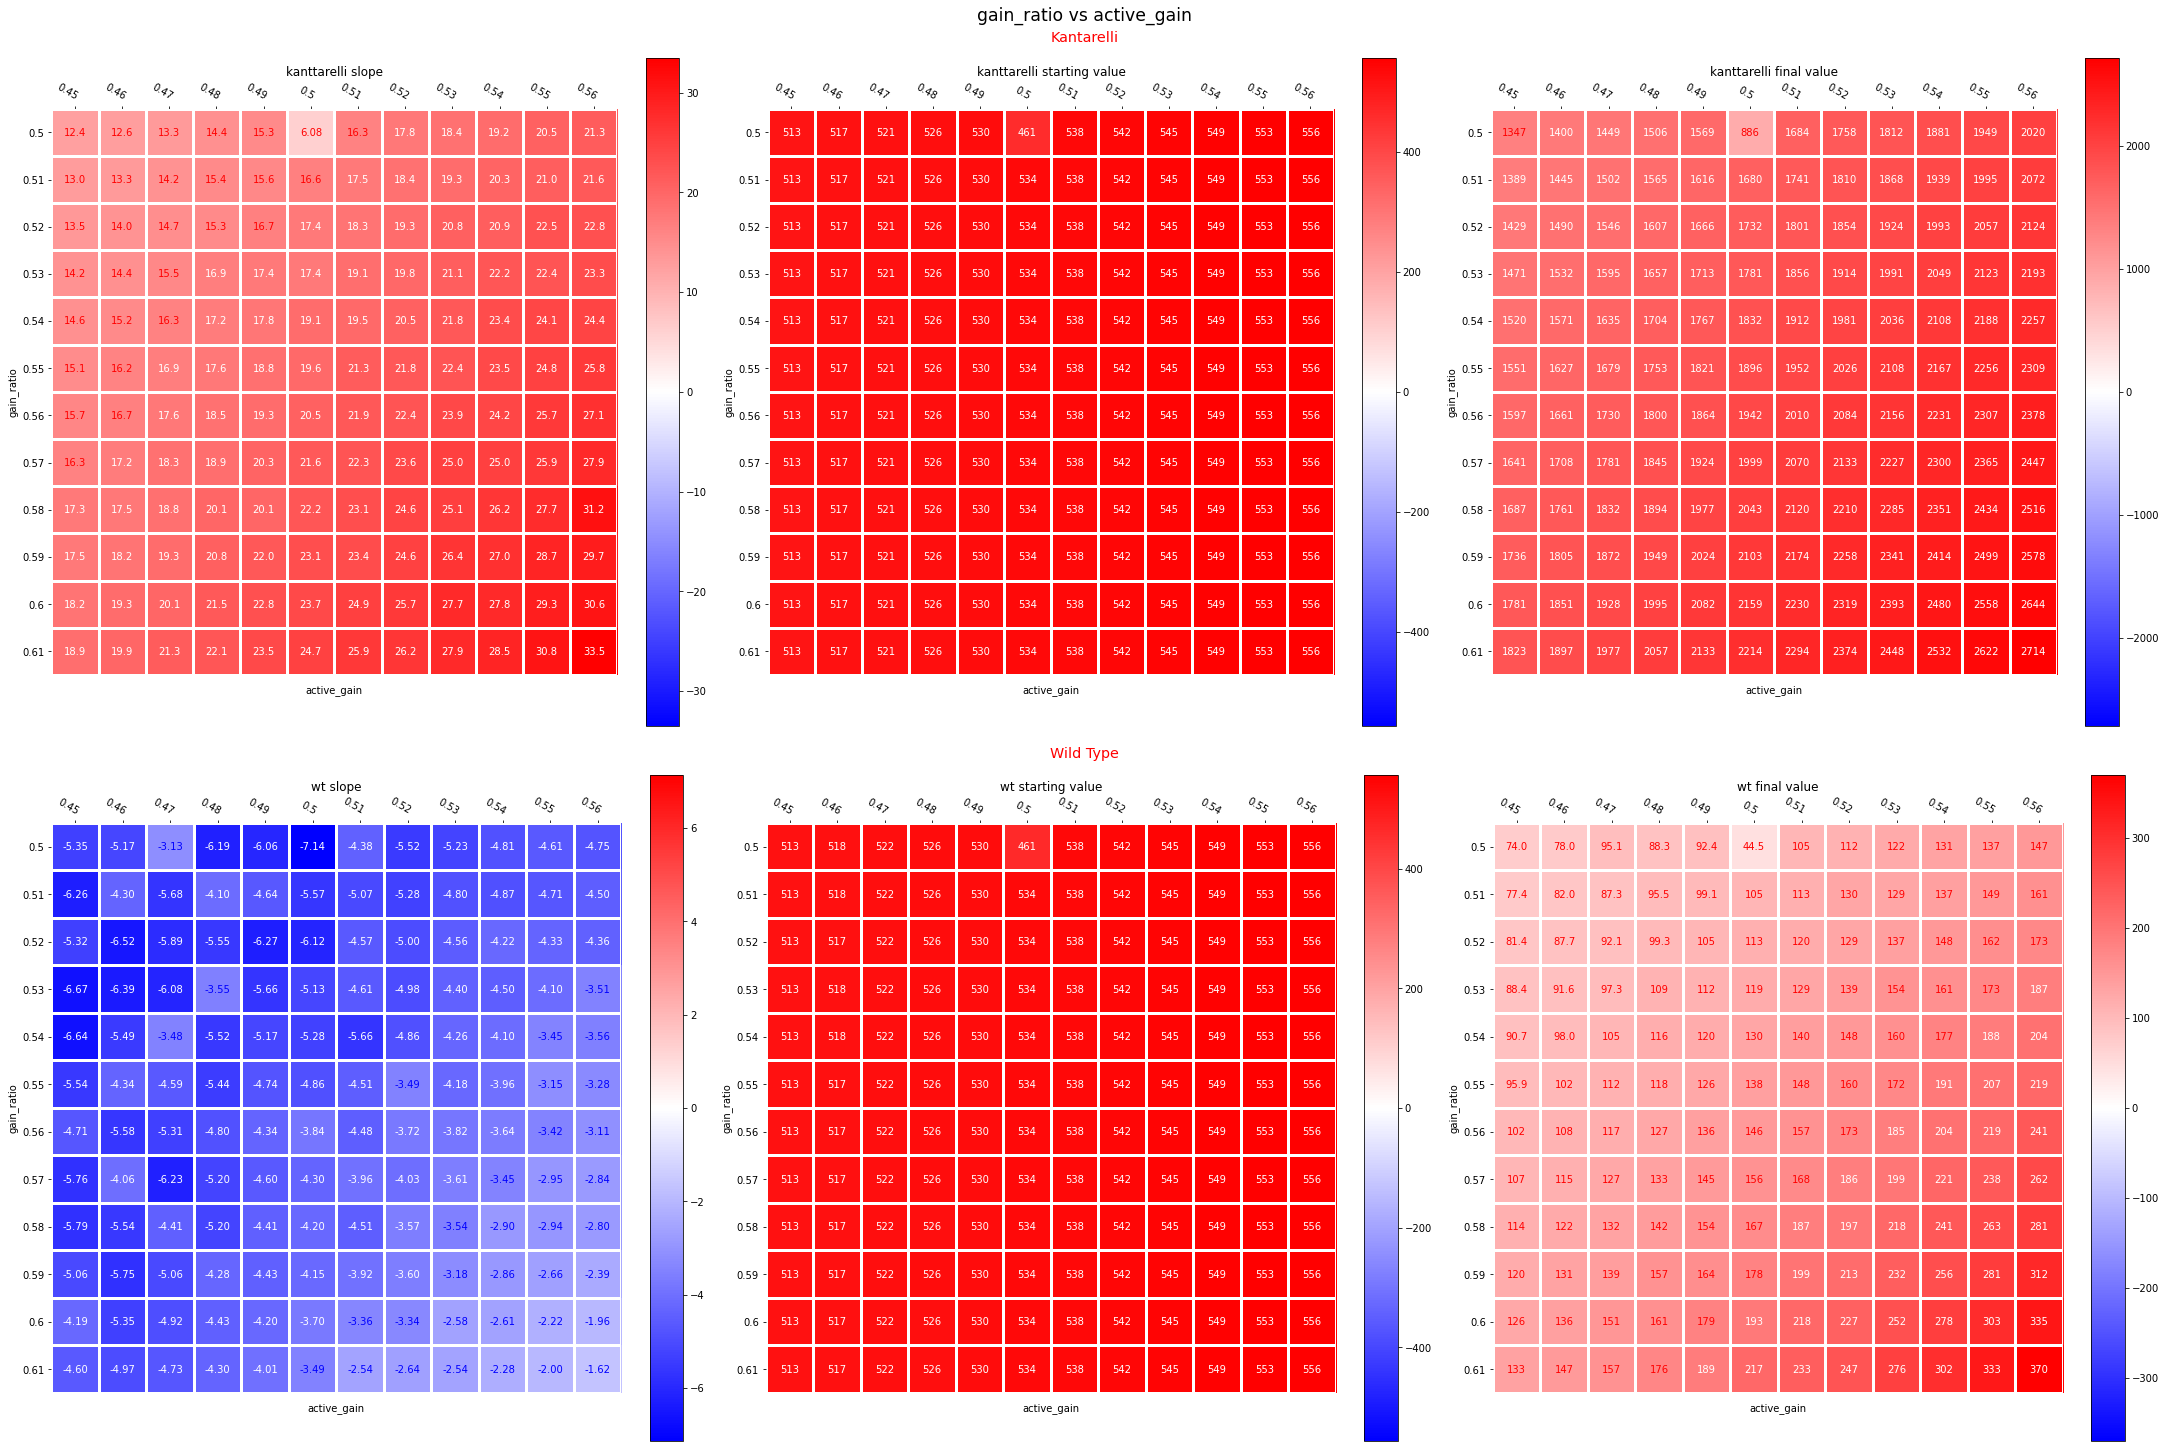

pin_decay 0.05,decay 0.175


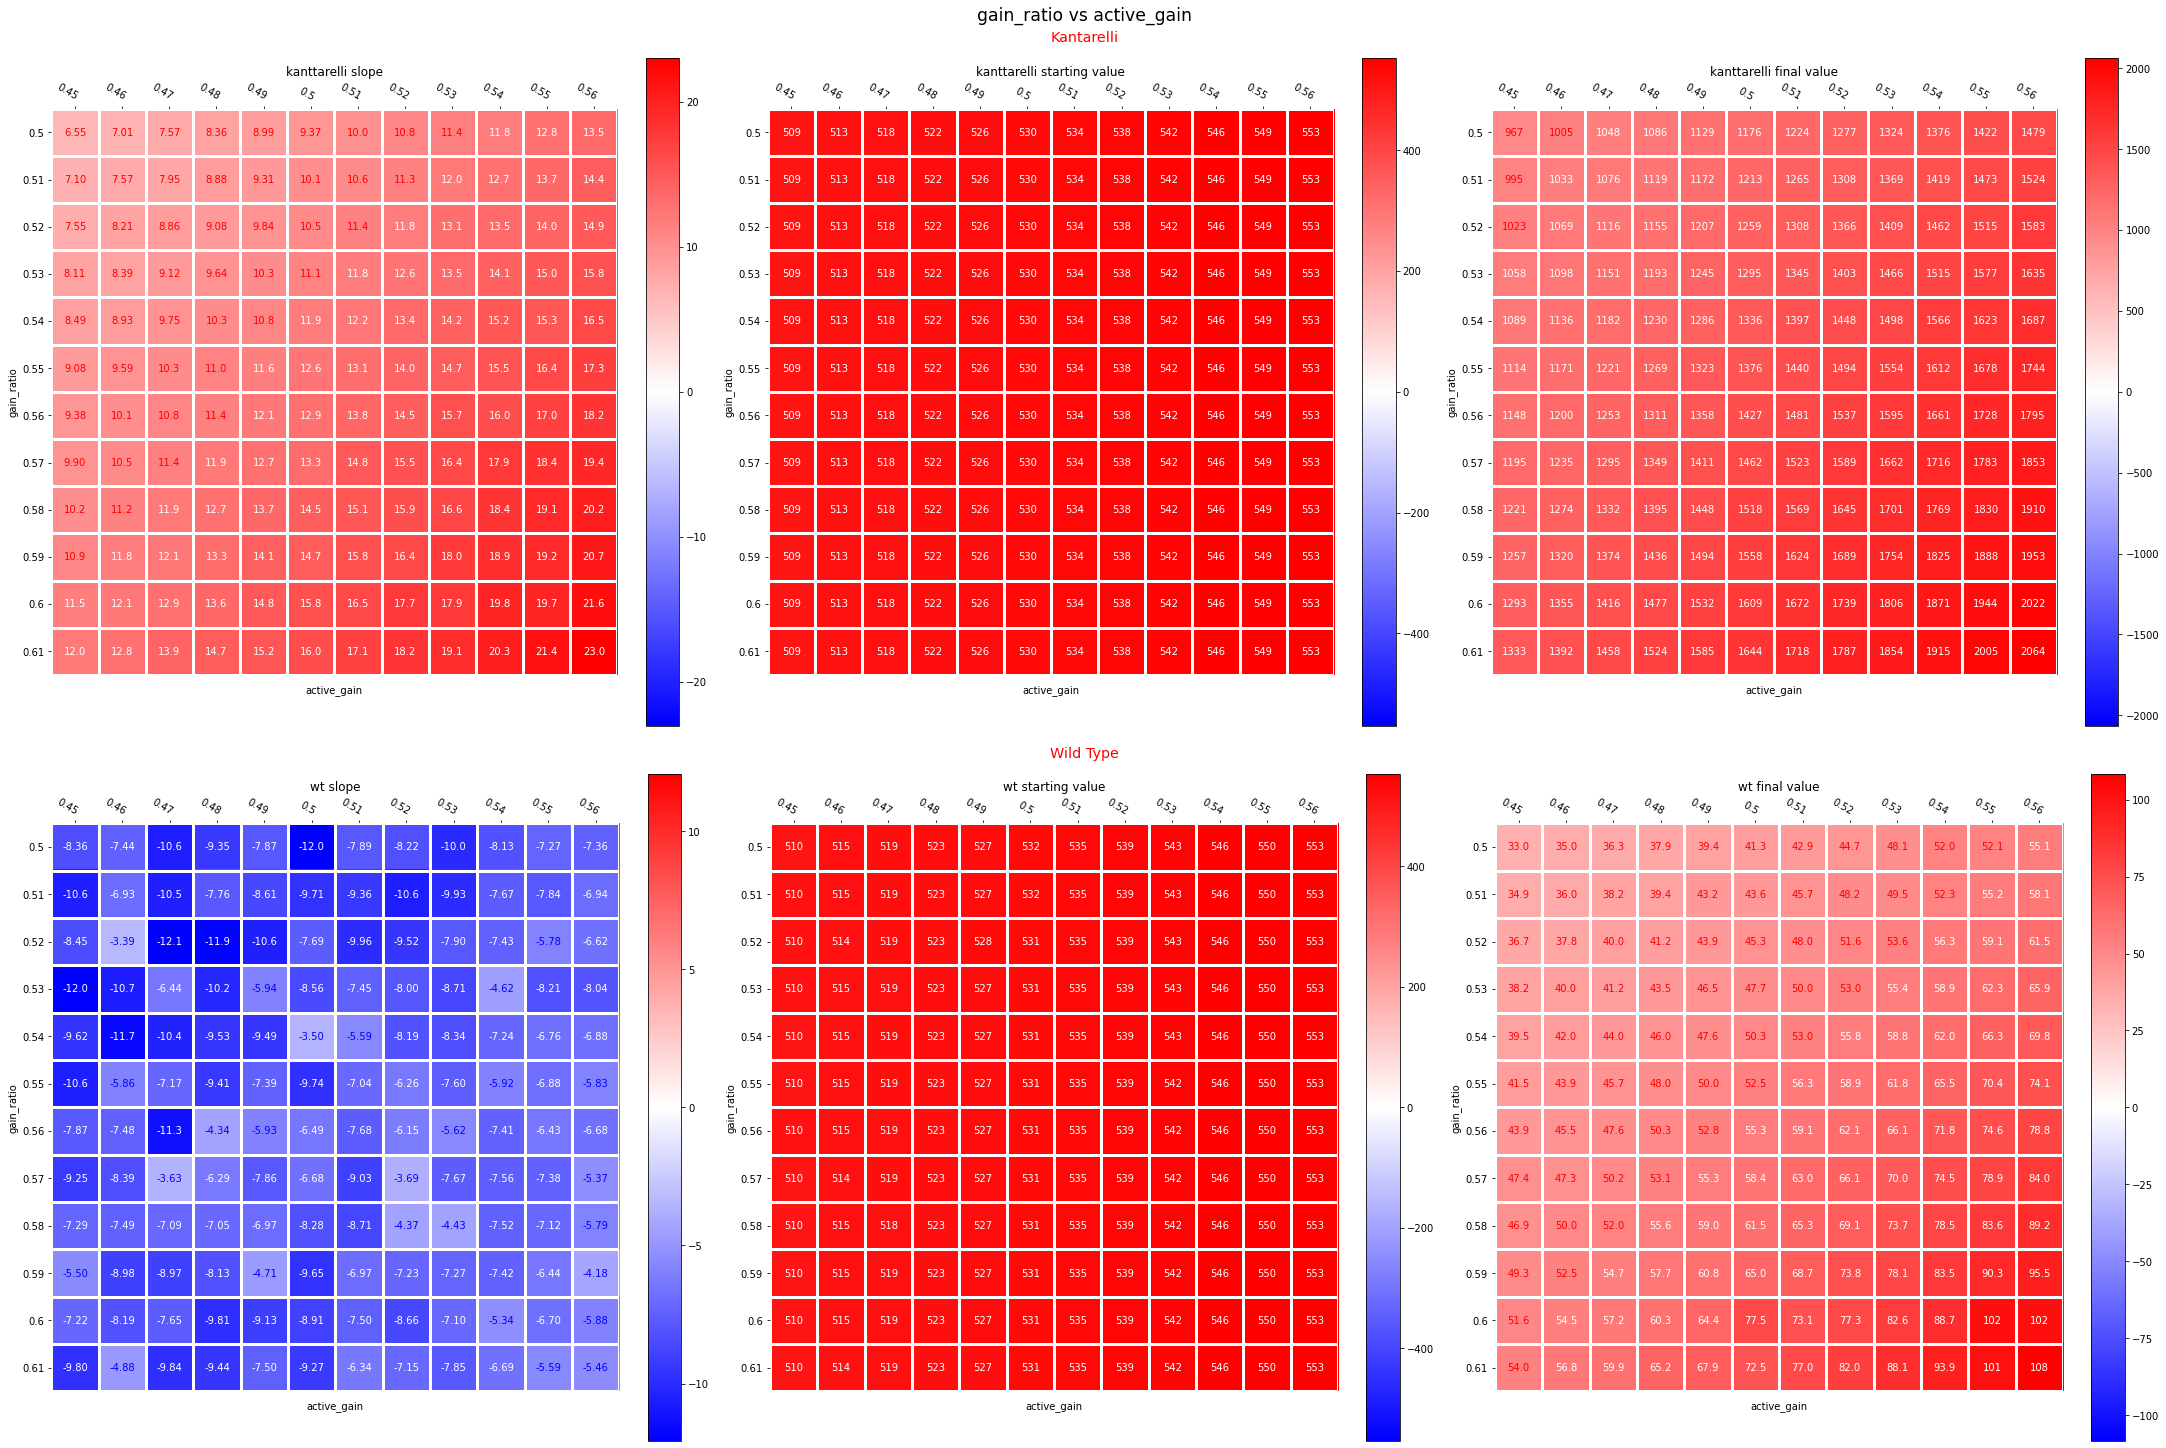

pin_decay 0.05,decay 0.2


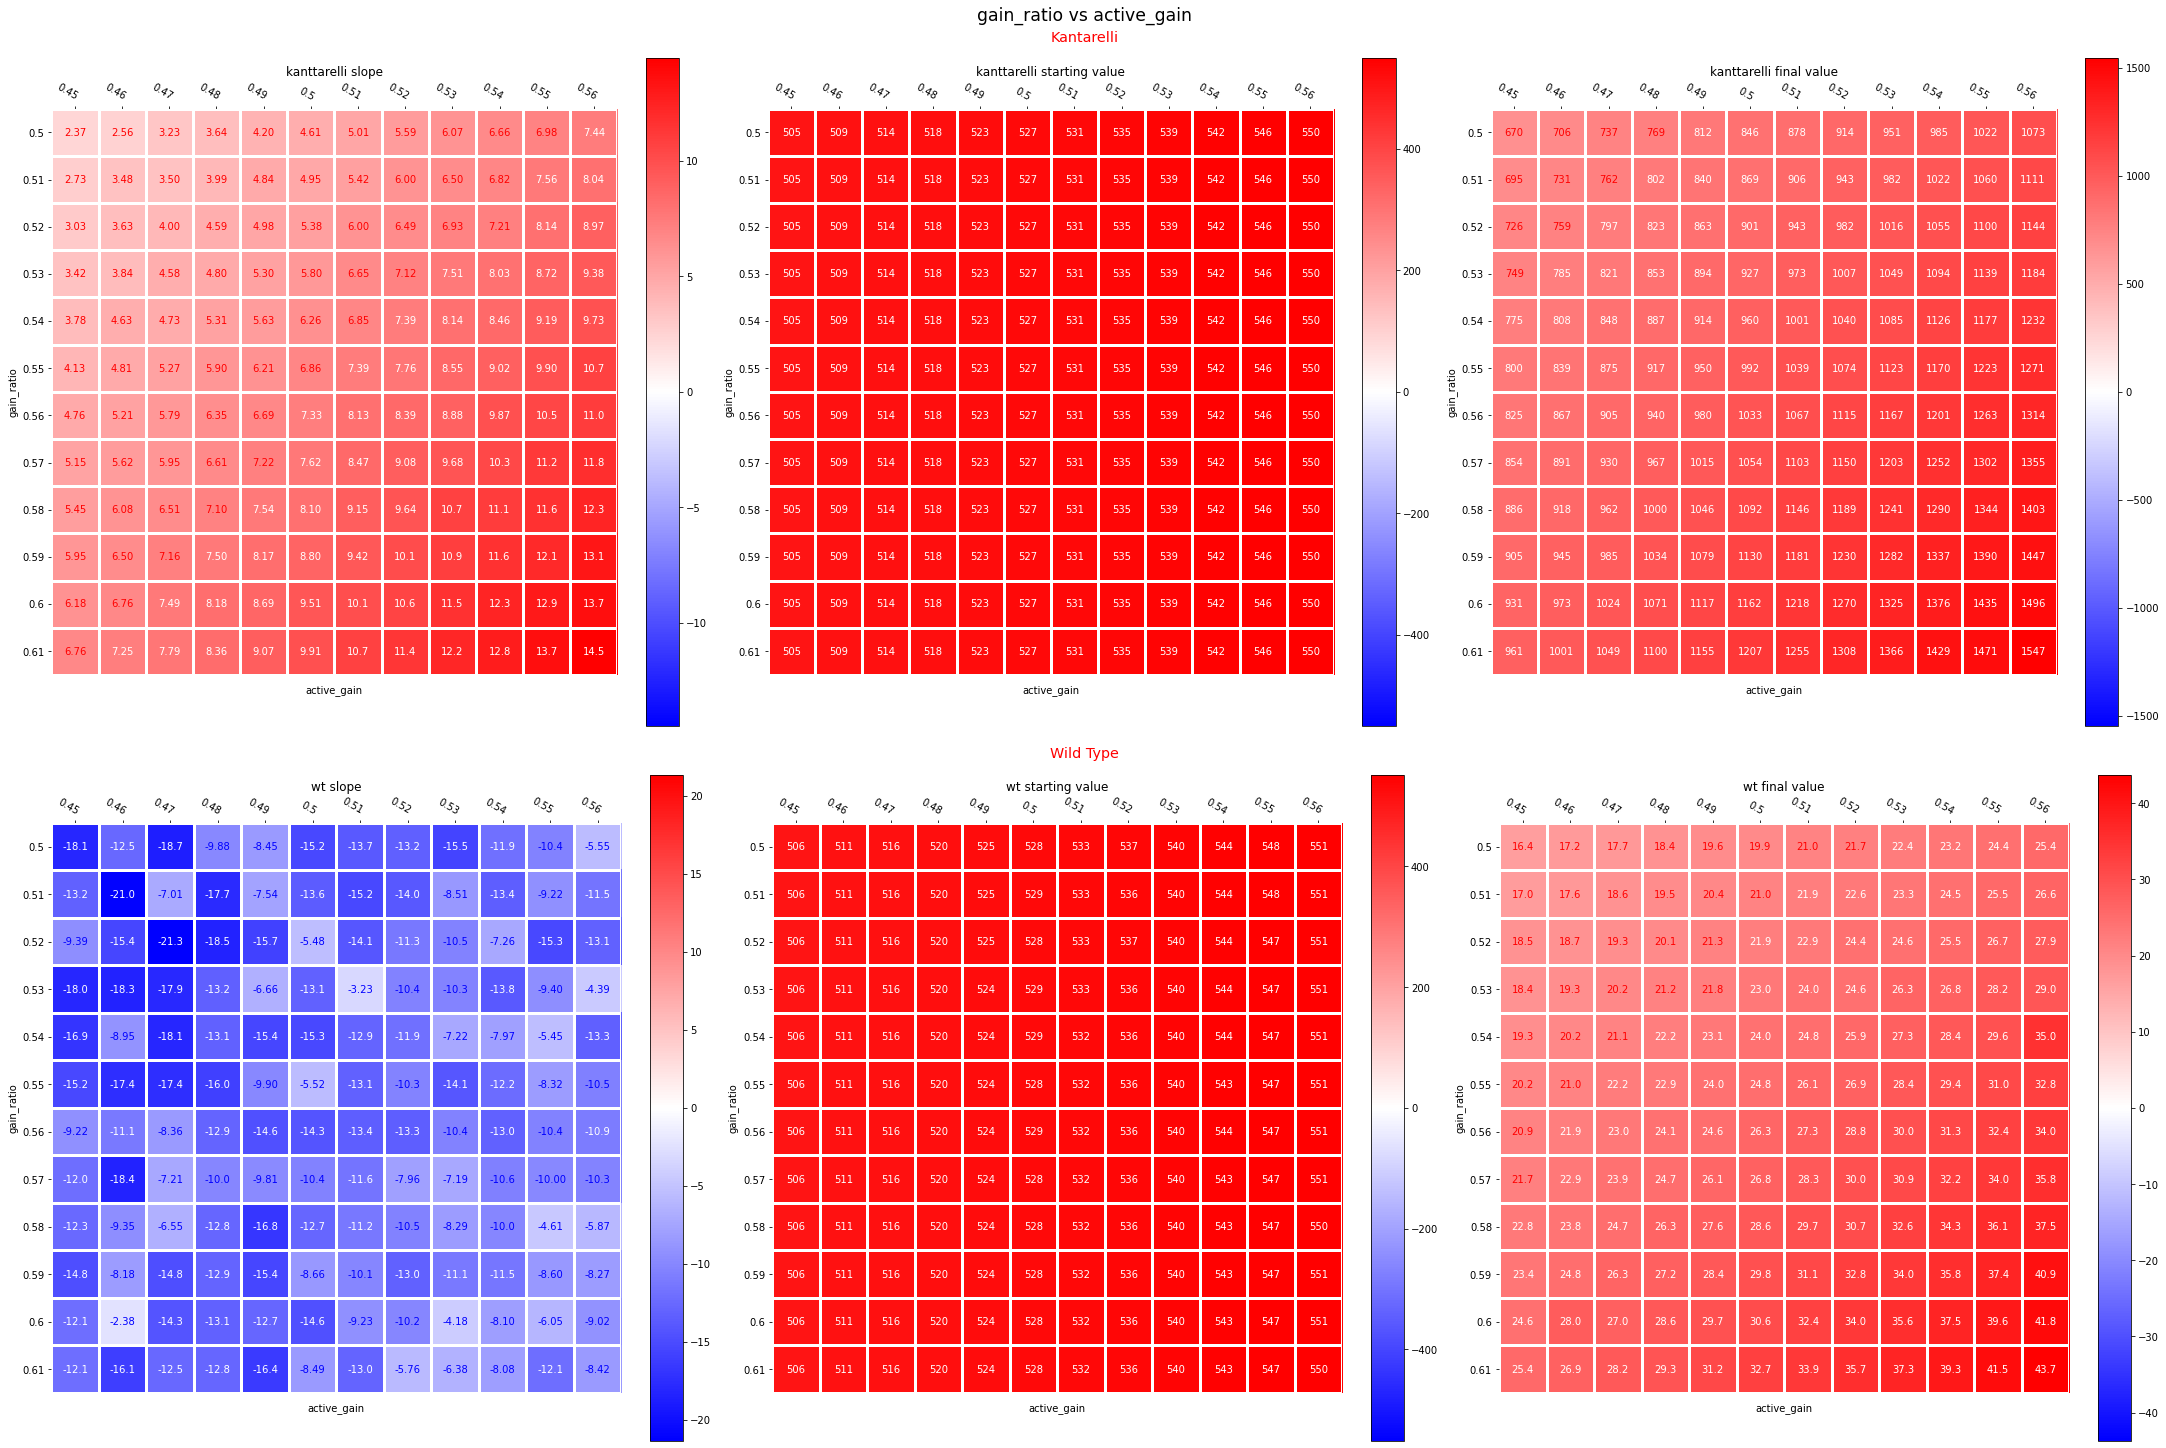

In [112]:
active_gain= [0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56]
gain_ratios= [0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61]
pin_decay= [0.04, 0.05]
decay= [0.15, 0.175, 0.2]

names=["rnai60","wt","pole"]
print("gain_ratio vs active_gain")
for pd in pin_decay:
    for d in decay:
        print(f"pin_decay {pd},decay {d}")
        draw_heatmaps("gain_ratio","active_gain",gain_ratios,active_gain,save=False,extra_parameters={"pin_decay":pd,"decay":d})

active_gain vs decay
pin_decay 0.04
pin_decay 0.05


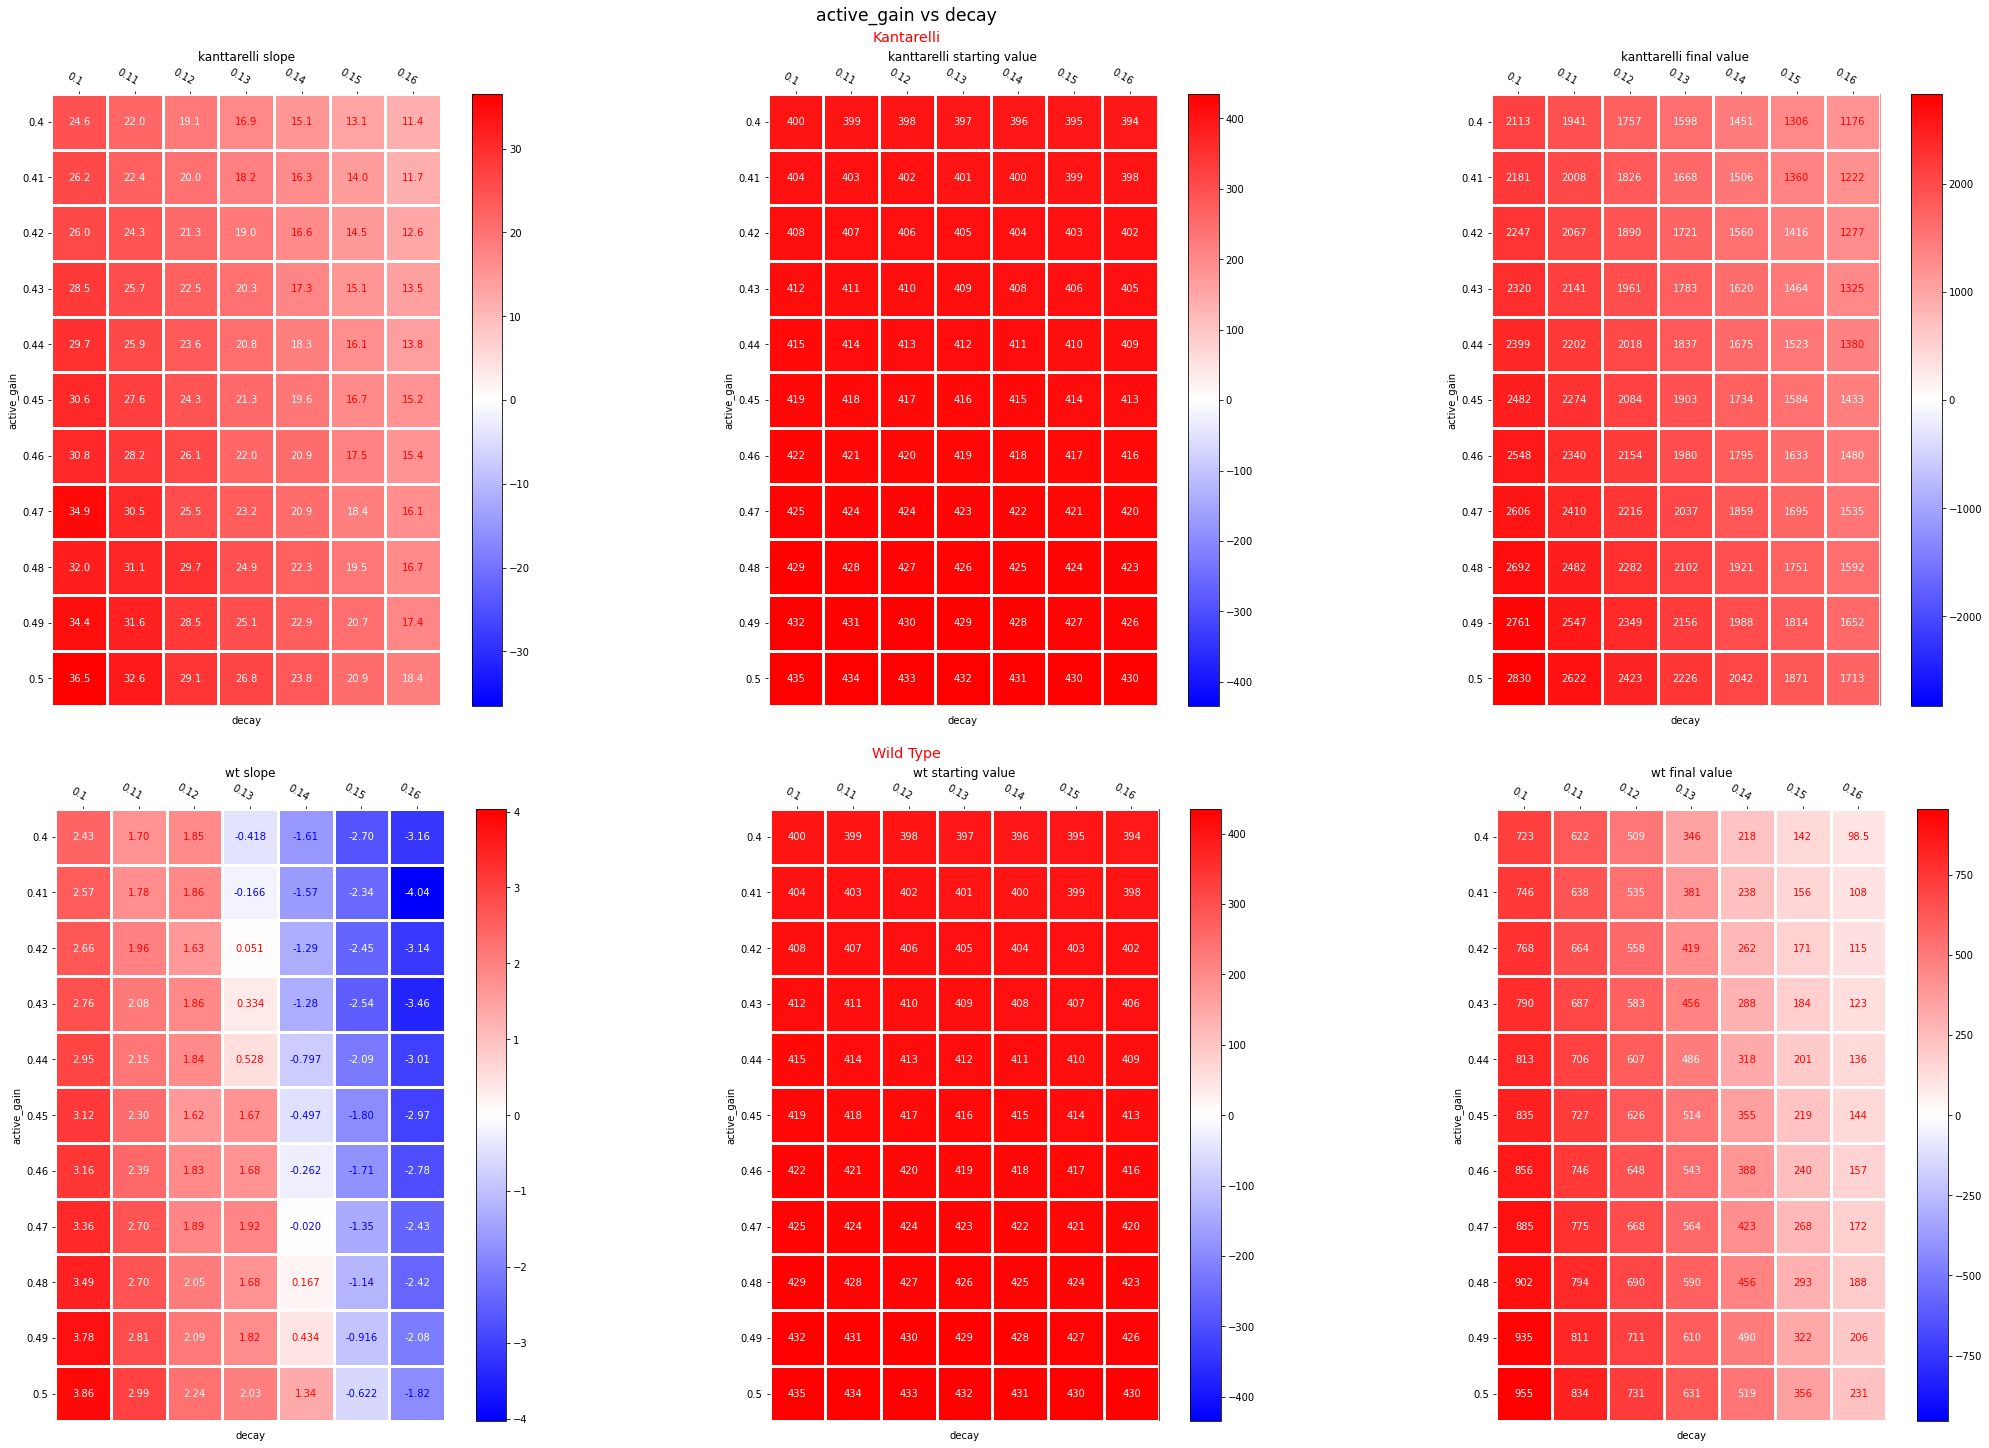

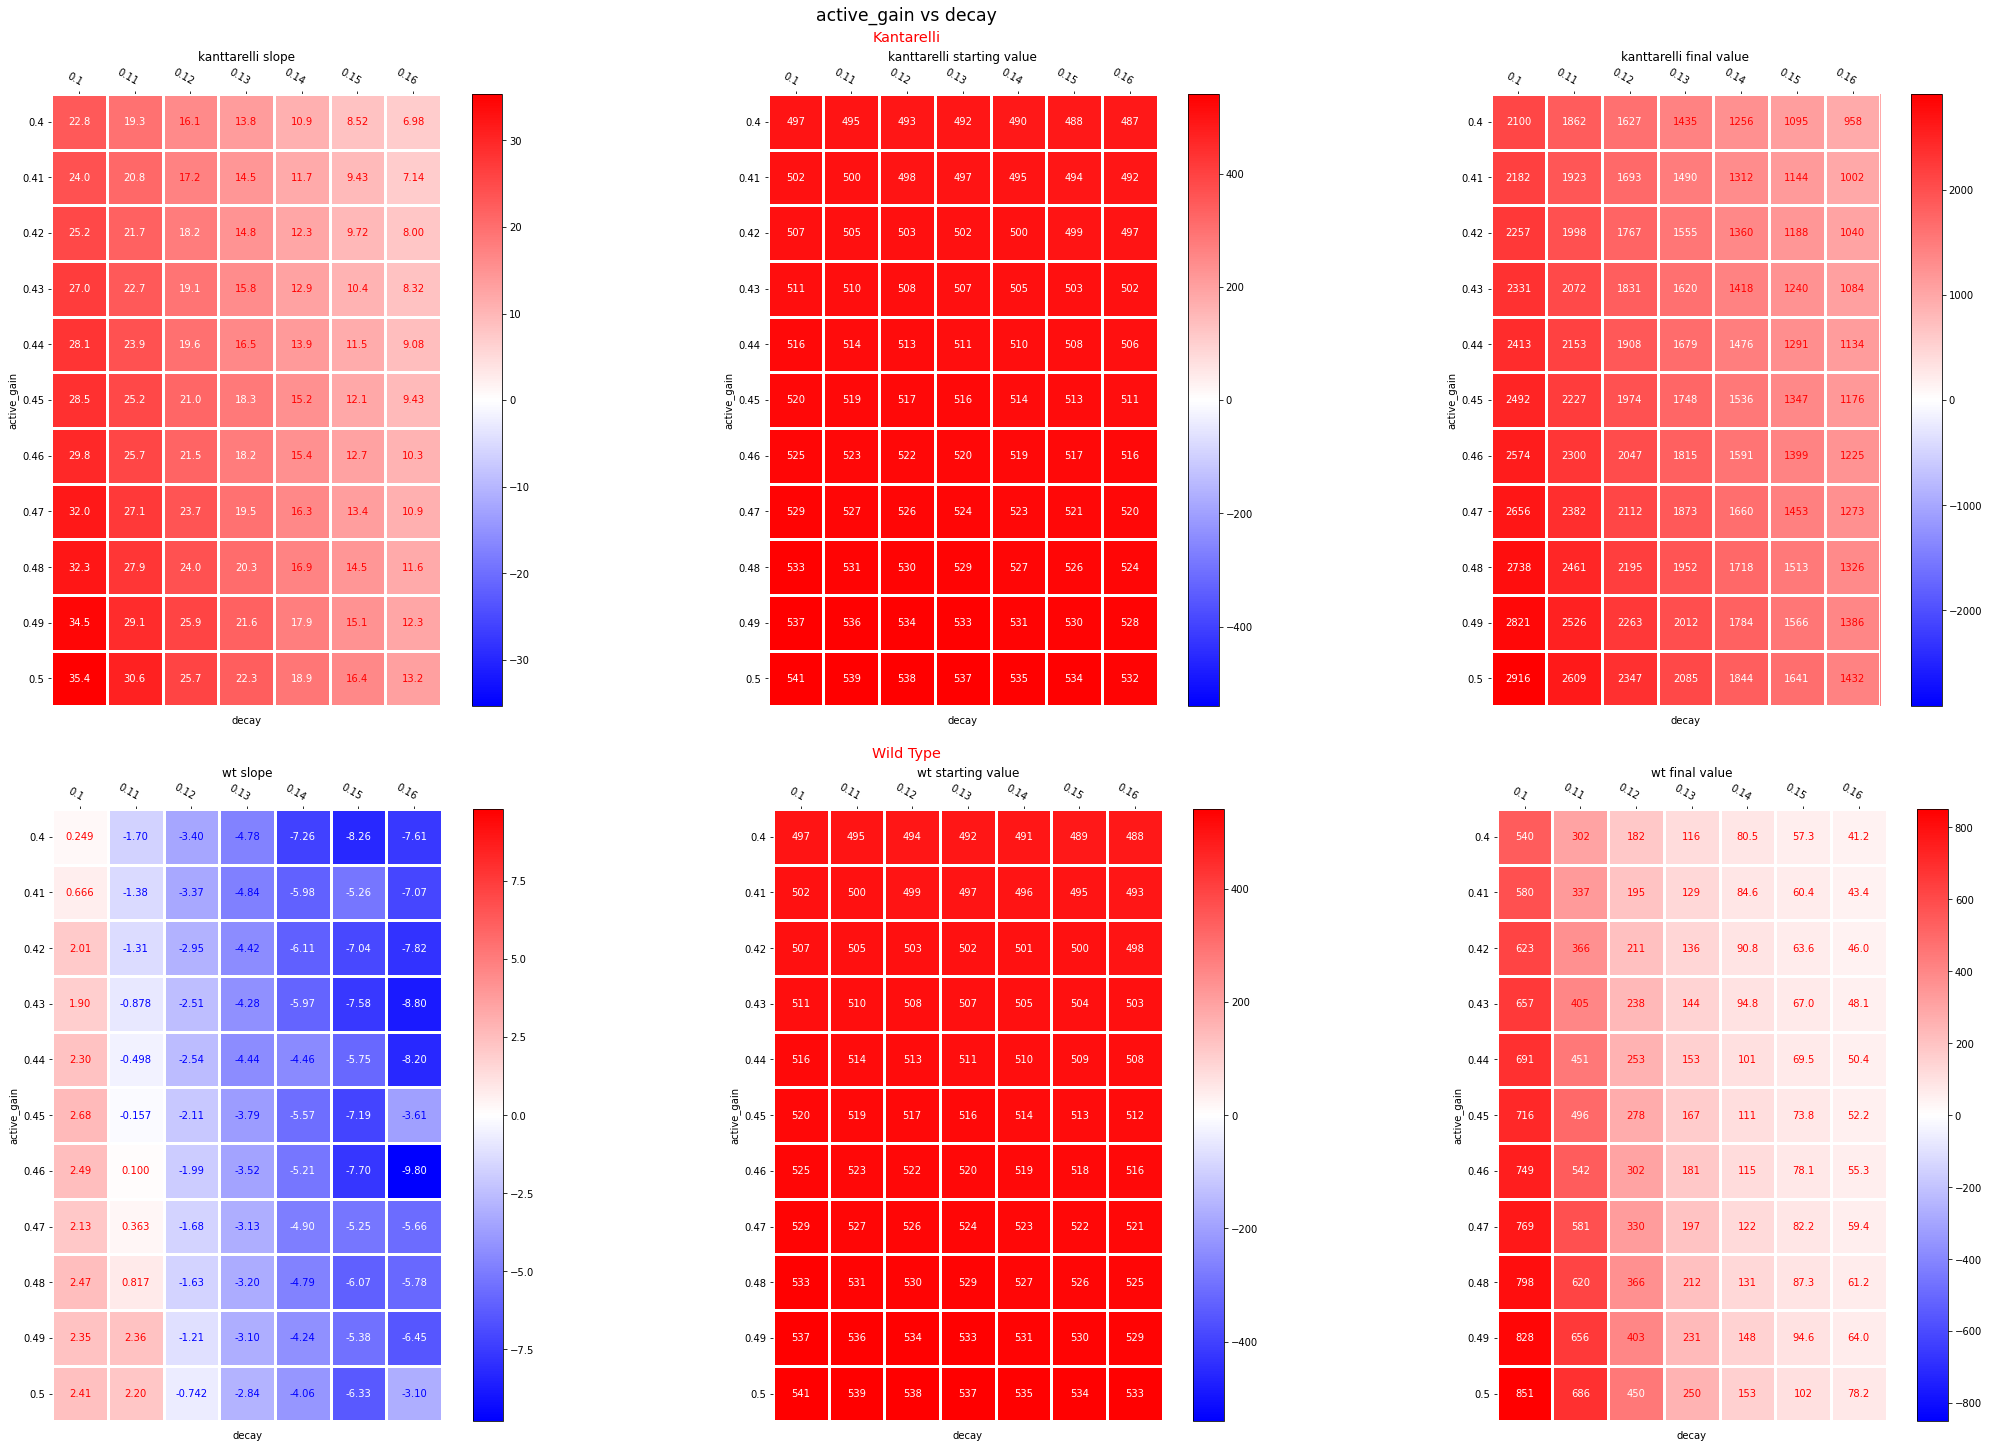

In [130]:
pin_decay= [0.04,0.05]
decay= [0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16]
active_gain= [0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5]

print("active_gain vs decay")
for pd in pin_decay:
    print(f"pin_decay {pd}")
    draw_heatmaps("active_gain","decay",active_gain,decay,save=True,extra_parameters={"pin_decay":pd},filename=f"precise test/active_gain vs decay pin_decay {pd}.png")